# Определение уязвимых групп населения

Задачу, описанную в брифе, поставила молодая НКО, которая хочет помогать малообеспеченным людям. Чтобы делать это эффективно, НКО нужно понять, где живут такие люди, и открыть там свои филиалы.
Кроме того, в НКО хотят выяснить, с какими факторами связана бедность и как эти факторы связаны между собой.

Цель:
* кластеризовать регионы России и определить, какие из них наиболее
остро нуждаются в помощи малообеспеченным/неблагополучным
слоям населения;
* описать группы населения, сталкивающиеся с бедностью;
* определить:
    * факторы, влияющие на уровень бедности;
    * влияет ли число детей, пенсионеров и других социально уязвимых
групп на уровень бедности в регионе;
    * связаны ли уровень бедности/социального неблагополучия с
производством и потреблением в регионе;
    * какие ещё зависимости можно наблюдать относительно
социально незащищённых слоёв населения.

In [1627]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics 
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
import pickle
import plotly.graph_objs as go

In [1628]:
# зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42

In [1629]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы
!pip freeze > requirements.txt

## Часть 1. Анализ и обработка данных

Знаем, что в разных датасетах может быть разное написание регионов, поэтому напишем функцию для приведения к общему виду.

In [1630]:
# создадим словарь, к этим именам будем приводить все данные
district = {
    'москва':'г. Москва', 
    'санкт':'г. Санкт-Петербург', 
    'севастополь':'г. Севастополь',
    'адыгея':'Республика Адыгея (Адыгея)',
    'республика адыгея':'Республика Адыгея (Адыгея)',
    'башкорт':'Республика Башкортостан',
    'бурятия':'Республика Бурятия',
    'владимир':'Владимирская область', 
    'bладимирская':'Владимирская область', 
    'воронежская ':'Воронежская область',
    'bоронежская ':'Воронежская область',    
    'bолгоградская область':'Волгоградская область', 
    'волгоградская область':'Волгоградская область',     
    'bологодская ':'Вологодская область',    
    'дагестан':'Республика Дагестан',
    'еврейская':'Еврейская автономная область', 
    'ингушетия':'Республика Ингушетия',
    'кабардино':'Кабардино-Балкарская Республика',
    'кабардино-балкарская\nреспублика':'Кабардино-Балкарская Республика', 
    'карачаево':'Карачаево-Черкесская Республика',
    'карачаево-черкесская\nреспублика':'Карачаево-Черкесская Республика',
    'кемеров':'Кемеровская область — Кузбасс',
    'кемеровская область':'Кемеровская область — Кузбасс',    
    'крым':'Республика Крым', 
    'республика саха':'Республика Саха (Якутия)', 
    'северная':'Республика Северная Осетия — Алания',
    'республика северная\nосетия-алания':'Республика Северная Осетия — Алания',
    'татарстан':'Республика Татарстан (Татарстан)',
    'республика татарстан':'Республика Татарстан (Татарстан)', 
    'тыва':'Республика Тыва',
    'республика тыва':'Республика Тыва',
    'чечня':'Чеченская Республика', 
    'чеченская':'Чеченская Республика',
    'чуваш':'Чувашская Республика — Чувашия',
    'чувашская республика':'Чувашская Республика — Чувашия', 
    '\nненецкий':'Ненецкий автономный округ',
    'ханты-мансийский ао':'Ханты-Мансийский автономный округ — Югра',   
    'ямало-ненецкий':'Ямало-Ненецкий автономный округ',
    'ямало-hенецкий ао':'Ямало-Ненецкий автономный округ',
    'ямало-ненецкий \nавтономный округ':'Ямало-Ненецкий автономный округ', 
    'ямало-ненецкий ао':'Ямало-Ненецкий автономный округ',
    'ямало-ненецкий ао':'Ямало-Ненецкий автономный округ',
    'ямало-ненецкий автономный округ':'Ямало-Ненецкий автономный округ',  
    'ямало-ненецкий автономный округ':'Ямало-Ненецкий автономный округ', 
    'ханты-мансийский':'Ханты-Мансийский автономный округ — Югра',
    'ханты-мансийский \nавтономный округ - югра':'Ханты-Мансийский автономный округ — Югра',
    'ненецкий автономный округ (архангельская область)':'Ненецкий автономный округ',
    'ненецкий автономный округ':'Ненецкий автономный округ',    
    'ненецкий авт. округ':'Ненецкий автономный округ',
    'архангельская':'Архангельская область',
    'архангельская область':'Архангельская область',
    'тюменская':'Тюменская область',
    'тюменская область без автономного округа':'Тюменская область',
    'тюменская область без\nавтономных округов':'Тюменская область',     
    'чукотский авт. округ':'Чукотский автономный округ',
    'чукотский авт.округ':'Чукотский автономный округ',
    'чукотский':'Чукотский автономный округ',    
    'новгородская': 'Новгородская область'}

In [1631]:
# Cоздадим функцию смены названия региона
def change_region_name(name):
    # обходим наш словарь
    for n in district: 
        # имя региона приводим к нижнему регистру и
        # проверяем есть ли оно в словаре
        if n in name.lower():
            # если нашли, то вернем имя из словаря
            return district[n]
    # если ничего не найдено, 
    # то возвращаем переданное 
    # в функцию имя    
    return name

In [1632]:
# МЕТОД Z-ОТКЛОНЕНИЙ
# возвращаем только выбросы, удалять их не будем
def outliers_z_score_mod(data, feature, log_scale=False, left=3, right = 3):  
    if log_scale:
        # логарифмируем
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    # получаем выбросы
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    return outliers

**child_mortality_rural_1990_2021.xls** — число умерших на первом году жизни детей за год, по всем регионам, в сельской местности.

In [1633]:
data_child_mortality_rural = pd.read_excel('social_russia_data/child_mortality_rural_1990_2021.xls', skiprows=2)
data_child_mortality_rural = data_child_mortality_rural.rename(columns={'Unnamed: 0': 'region'})

display(data_child_mortality_rural)

region Unnamed: 1          Unnamed: 2  \
0                 Российская Федерация   Оба пола  сельское население   
1        Центральный федеральный округ   Оба пола  сельское население   
2                 Белгородская область   Оба пола  сельское население   
3                     Брянская область   Оба пола  сельское население   
4                 Владимирская область   Оба пола  сельское население   
..                                 ...        ...                 ...   
114            Северо-Кавказский район   Оба пола  сельское население   
115                    Уральский район   Оба пола  сельское население   
116            Западно-Сибирский район   Оба пола  сельское население   
117           Восточно-Сибирский район   Оба пола  сельское население   
118              Дальневосточный район   Оба пола  сельское население   

        1990     1991     1992    1993    1994    1995    1996  ...    2012  \
0    11186.0  10943.0  10111.0  9840.0  9010.0  8582.0  7983.0  ...  5463.0   
1     1615.0   1550.0   1361.0  1426.0  1347.0  1321.0  1200.0  ...   625.0   
2      103.0     92.0     75.0    79.0    80.0    72.0    72.0  ...    43.0   
3      124.0    109.0     83.0   121.0    99.0   104.0    96.0  ...    46.0   
4       80.0     58.0     60.0    62.0    46.0    50.0    47.0  ...    30.0   
..       ...      ...      ...     ...     ...     ...     ...  ...     ...   
114   2675.0   2711.0   2524.0  2064.0     NaN     NaN     NaN  ...     NaN   
115   1415.0   1421.0   1424.0  1512.0     NaN     NaN     NaN  ...     NaN   
116   1242.0   1286.0   1084.0  1132.0     NaN     NaN     NaN  ...     NaN   
117   1215.0   1062.0    968.0   920.0     NaN     NaN     NaN  ...     NaN   
118    757.0    691.0    633.0   662.0     NaN     NaN     NaN  ...     NaN   

       2013    2014    2015    2016    2017    2018    2019    2020    2021  
0    5059.0  4681.0  4165.0  3568.0  3032.0  2521.0  2122.0  1916.0  1852.0  
1     608.0   487.0   490.0   426.0   347.0   291.0   211.0   228.0   212.0  
2      48.0    41.0    42.0    36.0    34.0    33.0    16.0    22.0    20.0  
3      47.0    39.0    44.0    36.0    31.0    12.0    11.0    12.0    13.0  
4      31.0    23.0    31.0    28.0    17.0    22.0    15.0    10.0    14.0  
..      ...     ...     ...     ...     ...     ...     ...     ...     ...  
114     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
115     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
116     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
117     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
118     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  

[119 rows x 35 columns]

Вторая и третьи колонки - не информативные, одинаковые для всех строк, удалим их. Видим лишние пробелы, избавимся от них. Будем это делать для всех датасетов. Также видим, что есть итговые строки, будем их удалять, т.е. информация о федеральном округе, районах - удаляем.
Строку "Архангельская область" - она общая для входящих в нее строк, тоже самое с "Тюменская область" и "Чеченская и Ингушская Республики".

In [1634]:
# удалим пробелы в названиях регионов
data_child_mortality_rural['region'] = data_child_mortality_rural['region'].str.strip()

# удалим строки по Чеченская и Ингушская Республики, Тюменской и Архангельской областям
data_child_mortality_rural = data_child_mortality_rural[data_child_mortality_rural['region']!='Архангельская область'] 
data_child_mortality_rural = data_child_mortality_rural[data_child_mortality_rural['region']!='Тюменская область']
data_child_mortality_rural = data_child_mortality_rural[data_child_mortality_rural['region']!='Чеченская и Ингушская Республики']

# убираем строки содержащие "Российская Федерация", федеральный округ и район
region_for_delete = data_child_mortality_rural[data_child_mortality_rural['region'].str.contains('федеральный округ|Федерация|район')].index
data_child_mortality_rural.drop(region_for_delete, axis = 0, inplace=True)

# меняем название регионов в соответствии с нашим словарем
data_child_mortality_rural['region'] = data_child_mortality_rural['region'].apply(change_region_name)

In [1635]:
# удаляем лишние столбцы
data_child_mortality_rural = data_child_mortality_rural.drop(columns=['Unnamed: 1', 'Unnamed: 2'])

display(data_child_mortality_rural)

region   1990   1991   1992   1993   1994   1995  \
2            Белгородская область  103.0   92.0   75.0   79.0   80.0   72.0   
3                Брянская область  124.0  109.0   83.0  121.0   99.0  104.0   
4            Владимирская область   80.0   58.0   60.0   62.0   46.0   50.0   
5             Воронежская область  138.0  179.0  156.0  149.0  154.0  137.0   
6              Ивановская область   74.0   44.0   40.0   57.0   50.0   41.0   
..                            ...    ...    ...    ...    ...    ...    ...   
101              Амурская область  142.0  124.0  106.0  108.0  111.0   99.0   
102           Магаданская область   17.0   11.0   11.0    5.0    8.0    5.0   
103           Сахалинская область   29.0   22.0   19.0   25.0   18.0   14.0   
104  Еврейская автономная область   49.0   44.0   39.0   45.0   31.0   25.0   
105    Чукотский автономный округ   20.0   21.0   25.0   20.0   14.0   17.0   

      1996   1997   1998  ...  2012  2013  2014  2015  2016  2017  2018  2019  \
2     72.0   67.0   61.0  ...  43.0  48.0  41.0  42.0  36.0  34.0  33.0  16.0   
3     96.0   67.0   75.0  ...  46.0  47.0  39.0  44.0  36.0  31.0  12.0  11.0   
4     47.0   38.0   39.0  ...  30.0  31.0  23.0  31.0  28.0  17.0  22.0  15.0   
5    133.0  132.0  125.0  ...  32.0  33.0  33.0  25.0  24.0  18.0  22.0   7.0   
6     31.0   39.0   27.0  ...  13.0  19.0  10.0  16.0  15.0   4.0   7.0   9.0   
..     ...    ...    ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   
101  100.0  118.0   86.0  ...  63.0  50.0  39.0  31.0  23.0  20.0  17.0  16.0   
102    6.0    8.0    3.0  ...   2.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
103    8.0   17.0   12.0  ...  13.0  11.0   8.0   8.0   9.0   4.0   5.0   3.0   
104   28.0   24.0   23.0  ...  11.0  16.0  14.0  14.0  16.0   9.0   9.0   3.0   
105   17.0   12.0   13.0  ...   9.0  13.0   8.0   8.0   8.0   5.0   5.0   4.0   

     2020  2021  
2    22.0  20.0  
3    12.0  13.0  
4    10.0  14.0  
5    12.0  10.0  
6     3.0   4.0  
..    ...   ...  
101  13.0  15.0  
102   0.0   0.0  
103   5.0   2.0  
104   5.0   6.0  
105   1.0   6.0  

[91 rows x 33 columns]

В таблице присутствуют данные за период 1990-2021 года.

In [1636]:
data_child_mortality_rural.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91 entries, 2 to 105
Data columns (total 33 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   region  91 non-null     object 
 1   1990    87 non-null     float64
 2   1991    87 non-null     float64
 3   1992    87 non-null     float64
 4   1993    87 non-null     float64
 5   1994    87 non-null     float64
 6   1995    87 non-null     float64
 7   1996    87 non-null     float64
 8   1997    84 non-null     float64
 9   1998    84 non-null     float64
 10  1999    84 non-null     float64
 11  2000    85 non-null     float64
 12  2001    85 non-null     float64
 13  2002    85 non-null     float64
 14  2003    85 non-null     float64
 15  2004    85 non-null     float64
 16  2005    84 non-null     float64
 17  2006    84 non-null     float64
 18  2007    85 non-null     float64
 19  2008    85 non-null     float64
 20  2009    85 non-null     float64
 21  2010    85 non-null     float64
 22  2011    

В датасете 91 строки. Region - категориальный признак, признаки по годам - числа, есть пропуски.

In [1637]:
# узнаем есть ли дубли
print('Количество дубликатов: {}'.format(data_child_mortality_rural[data_child_mortality_rural.duplicated()].shape[0]))

Количество дубликатов: 0


Дублирующихся строк нет.

In [1638]:
# получим столбцы с пропусками
cols_null_percent = data_child_mortality_rural.isnull().sum()
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

2011    12
2012    11
2014     8
2013     8
2006     7
1998     7
2005     7
1999     7
2021     7
1997     7
2009     6
2020     6
2019     6
2018     6
2017     6
2016     6
2015     6
2000     6
2010     6
2008     6
2007     6
2004     6
2003     6
2002     6
2001     6
1995     4
1994     4
1993     4
1992     4
1991     4
1996     4
1990     4
dtype: int64

Есть пропуски.

In [1639]:
#посмотрим статистические характеристики
data_child_mortality_rural.describe()

1990        1991        1992        1993        1994        1995  \
count   87.000000   87.000000   87.000000   87.000000   87.000000   87.000000   
mean   127.114943  123.942529  115.149425  112.218391  102.862069   97.804598   
std    120.656386  124.331922  114.240416  109.336096  103.114316   95.998406   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%     58.000000   48.000000   49.000000   49.000000   44.000000   43.000000   
50%     96.000000   82.000000   78.000000   78.000000   75.000000   76.000000   
75%    172.000000  159.000000  152.500000  141.500000  130.500000  119.500000   
max    662.000000  684.000000  645.000000  646.000000  599.000000  561.000000   

             1996        1997        1998        1999  ...        2012  \
count   87.000000   84.000000   84.000000   84.000000  ...   80.000000   
mean    91.402299   91.059524   85.238095   83.833333  ...   66.987500   
std     92.336400   89.115243   86.543898   86.996307  ...   81.701602   
min      0.000000    4.000000    3.000000    1.000000  ...    1.000000   
25%     37.500000   41.000000   36.750000   36.000000  ...   27.750000   
50%     66.000000   67.000000   62.000000   60.000000  ...   46.500000   
75%    105.500000  115.500000  101.250000  105.000000  ...   67.500000   
max    589.000000  593.000000  604.000000  616.000000  ...  539.000000   

             2013        2014        2015        2016        2017        2018  \
count   83.000000   83.000000   85.000000   85.000000   85.000000   85.000000   
mean    60.951807   55.590361   49.000000   41.976471   35.670588   29.658824   
std     65.258567   66.422894   59.916211   48.120626   43.624040   35.527841   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%     25.500000   21.500000   20.000000   17.000000   14.000000    9.000000   
50%     41.000000   34.000000   31.000000   29.000000   21.000000   19.000000   
75%     74.500000   68.000000   56.000000   46.000000   41.000000   33.000000   
max    449.000000  461.000000  438.000000  342.000000  295.000000  243.000000   

             2019        2020        2021  
count   85.000000   85.000000   84.000000  
mean    24.964706   22.541176   21.940476  
std     29.886471   27.277914   27.195566  
min      0.000000    0.000000    0.000000  
25%      9.000000    8.000000    8.000000  
50%     16.000000   13.000000   13.000000  
75%     32.000000   29.000000   25.000000  
max    207.000000  181.000000  176.000000  

[8 rows x 32 columns]

Есть года, когда дети не умирали в каких-то регионах, а есть года, где везде были смерти - это конец 90-х. Максимальная смертность снижается с увеличением года. 

In [1640]:
data_child_mortality_rural.describe(include='object')

region
count                     91
unique                    91
top     Белгородская область
freq                       1

В датасете осталось 91 объект, названия не повторяются.

**child_mortality_urban_1990_2021.xls** — число умерших на первом году жизни детей за год, по всем регионам, в городской местности.

In [1641]:
data_child_mortality_urban = pd.read_excel('social_russia_data/child_mortality_urban_1990_2021.xls', skiprows=2)
data_child_mortality_urban = data_child_mortality_urban.rename(columns={'Unnamed: 0': 'region'})

display(data_child_mortality_urban)

region Unnamed: 1           Unnamed: 2  \
0                 Российская Федерация   Оба пола  городское население   
1        Центральный федеральный округ   Оба пола  городское население   
2                 Белгородская область   Оба пола  городское население   
3                     Брянская область   Оба пола  городское население   
4                 Владимирская область   Оба пола  городское население   
..                                 ...        ...                  ...   
114            Северо-Кавказский район   Оба пола  городское население   
115                    Уральский район   Оба пола  городское население   
116            Западно-Сибирский район   Оба пола  городское население   
117           Восточно-Сибирский район   Оба пола  городское население   
118              Дальневосточный район   Оба пола  городское население   

        1990     1991     1992     1993     1994     1995     1996  ...  \
0    23902.0  21549.0  19097.0  18106.0  17131.0  16258.0  14842.0  ...   
1     5317.0   4734.0   4175.0   3899.0   3871.0   3631.0   3254.0  ...   
2      209.0    198.0    165.0    165.0    153.0    131.0    102.0  ...   
3      198.0    195.0    200.0    176.0    157.0    125.0    116.0  ...   
4      221.0    209.0    179.0    148.0    165.0    146.0    114.0  ...   
..       ...      ...      ...      ...      ...      ...      ...  ...   
114   2591.0   2594.0   2433.0   2112.0      NaN      NaN      NaN  ...   
115   3402.0   3044.0   2707.0   2626.0      NaN      NaN      NaN  ...   
116   2645.0   2404.0   2132.0   2095.0      NaN      NaN      NaN  ...   
117   1898.0   1794.0   1498.0   1518.0      NaN      NaN      NaN  ...   
118   1600.0   1400.0   1246.0   1115.0      NaN      NaN      NaN  ...   

        2012     2013    2014    2015    2016    2017    2018    2019    2020  \
0    10843.0  10418.0  9641.0  8499.0  7860.0  6545.0  5723.0  5206.0  4573.0   
1     2789.0   2735.0  2402.0  2228.0  2146.0  1785.0  1593.0  1409.0  1153.0   
2       84.0     68.0    62.0    68.0    72.0    43.0    40.0    23.0    25.0   
3       81.0     77.0    87.0    67.0    67.0    65.0    33.0    26.0    29.0   
4       97.0     86.0    87.0    76.0    72.0    59.0    45.0    43.0    51.0   
..       ...      ...     ...     ...     ...     ...     ...     ...     ...   
114      NaN      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
115      NaN      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
116      NaN      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
117      NaN      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
118      NaN      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

       2021  
0    4664.0  
1    1192.0  
2      34.0  
3      14.0  
4      52.0  
..      ...  
114     NaN  
115     NaN  
116     NaN  
117     NaN  
118     NaN  

[119 rows x 35 columns]

Вторая и третья колонки - одинаковые значения для каждой строки, удаляем. Изменим наименования регионов, удалим лишние строки.

In [1642]:
# удаляем лишние столбцы
data_child_mortality_urban = data_child_mortality_urban.drop(columns=['Unnamed: 1', 'Unnamed: 2'])

# удалим пробелы в названиях регионов
data_child_mortality_urban['region'] = data_child_mortality_urban['region'].str.strip()

# удалим строки по Чеченская и Ингушская Республики, Тюменской и Архангельской областям
data_child_mortality_urban = data_child_mortality_urban[data_child_mortality_urban['region']!='Архангельская область'] 
data_child_mortality_urban = data_child_mortality_urban[data_child_mortality_urban['region']!='Тюменская область']
data_child_mortality_urban = data_child_mortality_urban[data_child_mortality_urban['region']!='Чеченская и Ингушская Республики']

# убираем строки содержащие "Российская Федерация", федеральный округ и район
region_for_delete = data_child_mortality_urban[data_child_mortality_urban['region'].str.contains('федеральный округ|Федерация|район')].index
data_child_mortality_urban.drop(region_for_delete, axis = 0, inplace=True)

# меняем название регионов в соответствии с нашим словарем
data_child_mortality_urban['region'] = data_child_mortality_urban['region'].apply(change_region_name)

display(data_child_mortality_urban)

region   1990   1991   1992   1993   1994   1995  \
2            Белгородская область  209.0  198.0  165.0  165.0  153.0  131.0   
3                Брянская область  198.0  195.0  200.0  176.0  157.0  125.0   
4            Владимирская область  221.0  209.0  179.0  148.0  165.0  146.0   
5             Воронежская область  261.0  262.0  262.0  213.0  194.0  184.0   
6              Ивановская область  181.0  187.0  174.0  168.0  142.0  141.0   
..                            ...    ...    ...    ...    ...    ...    ...   
101              Амурская область  201.0  169.0  174.0  136.0  131.0  151.0   
102           Магаданская область   76.0   71.0   44.0   39.0   36.0   27.0   
103           Сахалинская область  142.0   93.0  101.0   85.0  100.0  122.0   
104  Еврейская автономная область   45.0   50.0   46.0   50.0   45.0   37.0   
105    Чукотский автономный округ   21.0   19.0   19.0   22.0    8.0   15.0   

      1996   1997   1998  ...   2012   2013   2014   2015  2016  2017  2018  \
2    102.0  100.0   99.0  ...   84.0   68.0   62.0   68.0  72.0  43.0  40.0   
3    116.0  135.0  107.0  ...   81.0   77.0   87.0   67.0  67.0  65.0  33.0   
4    114.0  123.0  130.0  ...   97.0   86.0   87.0   76.0  72.0  59.0  45.0   
5    140.0  143.0  177.0  ...  134.0  153.0  112.0  101.0  96.0  90.0  77.0   
6    128.0  127.0  110.0  ...   58.0   67.0   58.0   48.0  51.0  31.0  28.0   
..     ...    ...    ...  ...    ...    ...    ...    ...   ...   ...   ...   
101  145.0  150.0  160.0  ...   98.0   69.0   62.0   52.0  30.0  28.0  29.0   
102   35.0   29.0   23.0  ...   14.0   17.0   11.0    9.0   6.0   6.0   5.0   
103   72.0   74.0   88.0  ...   27.0   24.0   33.0   33.0  17.0  25.0  12.0   
104   51.0   25.0   34.0  ...   27.0   30.0   21.0   17.0  19.0  12.0   9.0   
105   15.0   14.0   15.0  ...    6.0    3.0    8.0    3.0   3.0   2.0   3.0   

     2019  2020  2021  
2    23.0  25.0  34.0  
3    26.0  29.0  14.0  
4    43.0  51.0  52.0  
5    74.0  58.0  73.0  
6    31.0  25.0  20.0  
..    ...   ...   ...  
101  27.0  29.0  21.0  
102   8.0   4.0   7.0  
103  22.0  20.0  14.0  
104  13.0   6.0  12.0  
105   2.0   7.0   2.0  

[91 rows x 33 columns]

In [1643]:
data_child_mortality_urban.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91 entries, 2 to 105
Data columns (total 33 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   region  91 non-null     object 
 1   1990    87 non-null     float64
 2   1991    87 non-null     float64
 3   1992    87 non-null     float64
 4   1993    87 non-null     float64
 5   1994    87 non-null     float64
 6   1995    87 non-null     float64
 7   1996    87 non-null     float64
 8   1997    85 non-null     float64
 9   1998    85 non-null     float64
 10  1999    85 non-null     float64
 11  2000    86 non-null     float64
 12  2001    86 non-null     float64
 13  2002    86 non-null     float64
 14  2003    86 non-null     float64
 15  2004    86 non-null     float64
 16  2005    85 non-null     float64
 17  2006    85 non-null     float64
 18  2007    86 non-null     float64
 19  2008    86 non-null     float64
 20  2009    86 non-null     float64
 21  2010    86 non-null     float64
 22  2011    

В датасете 91 строка. Region - категориальный признак, признаки по годам - числа, есть пропуски. В таблице присутствуют данные за период 1990-2021 года, как в предыдущей таблице.

In [1644]:
print('Количество дубликатов: {}'.format(data_child_mortality_urban[data_child_mortality_urban.duplicated()].shape[0]))

Количество дубликатов: 0


Дубликаты также отсутствуют.

In [1645]:
data_child_mortality_urban['region'].value_counts()

region
Белгородская область          1
Алтайский край                1
Республика Тыва               1
Республика Алтай              1
Челябинская область           1
                             ..
г. Санкт-Петербург            1
Псковская область             1
Новгородская область          1
Мурманская область            1
Чукотский автономный округ    1
Name: count, Length: 91, dtype: int64

Повторений по наименованию нет.

In [1646]:
# получим столбцы с пропусками
cols_null_percent = data_child_mortality_urban.isnull().sum()
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

2012    10
2011    10
2014     8
2013     8
2021     7
2005     6
2020     6
2019     6
2018     6
2017     6
2016     6
2015     6
2006     6
1997     6
1998     6
1999     6
2003     5
2010     5
2004     5
2001     5
2000     5
2009     5
2008     5
2007     5
2002     5
1991     4
1996     4
1995     4
1994     4
1993     4
1992     4
1990     4
dtype: int64

Обработаем пропуски позже.

In [1647]:
# посмотрим статистические характеристики
data_child_mortality_urban.describe()

1990         1991         1992         1993         1994  \
count    87.000000    87.000000    87.000000    87.000000    87.000000   
mean    270.586207   244.275862   216.540230   205.183908   194.206897   
std     264.197449   229.330354   194.383989   194.597888   190.144507   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%     104.500000    93.500000    91.500000    81.000000    79.500000   
50%     194.000000   174.000000   161.000000   137.000000   135.000000   
75%     344.500000   325.000000   307.000000   294.500000   259.500000   
max    1617.000000  1351.000000  1121.000000  1056.000000  1153.000000   

              1995        1996        1997        1998        1999  ...  \
count    87.000000   87.000000   85.000000   85.000000   85.000000  ...   
mean    183.850575  168.068966  162.870588  160.941176  158.352941  ...   
std     176.191461  161.121130  155.212664  148.244357  144.451319  ...   
min       0.000000    0.000000    1.000000    1.000000    1.000000  ...   
25%      76.000000   70.500000   70.000000   70.000000   65.000000  ...   
50%     123.000000  114.000000  119.000000  107.000000  113.000000  ...   
75%     233.000000  201.000000  212.000000  209.000000  195.000000  ...   
max    1067.000000  901.000000  975.000000  873.000000  844.000000  ...   

              2012        2013        2014        2015        2016  \
count    81.000000   83.000000   83.000000   85.000000   85.000000   
mean    131.814815  125.518072  114.831325   99.988235   92.470588   
std     146.819371  137.320114  122.306574  113.624119  107.890883   
min       1.000000    3.000000    2.000000    3.000000    1.000000   
25%      50.000000   49.500000   43.000000   38.000000   36.000000   
50%      77.000000   84.000000   69.000000   62.000000   61.000000   
75%     188.000000  181.000000  153.500000  136.000000  114.000000   
max    1053.000000  992.000000  819.000000  845.000000  811.000000   

             2017        2018        2019        2020        2021  
count   85.000000   85.000000   85.000000   85.000000   84.000000  
mean    77.000000   67.329412   61.247059   53.800000   54.738095  
std     97.822117   88.976507   81.673698   61.775669   65.503816  
min      2.000000    0.000000    0.000000    1.000000    1.000000  
25%     27.000000   25.000000   22.000000   20.000000   18.500000  
50%     45.000000   39.000000   35.000000   32.000000   30.500000  
75%     98.000000   79.000000   74.000000   66.000000   68.500000  
max    763.000000  701.000000  642.000000  440.000000  459.000000  

[8 rows x 32 columns]

Видим почти такую же картину, как и в предыдущем датасете, но есть минимум по количеству смертей и после конца 90-х, смертность к 2021 году снижается.

In [1648]:
# объединим датасеты, получим детскую смертность в городской и сельской местностях
data_child_mortality_rural.set_index('region', inplace=True)
data_child_mortality_urban.set_index('region', inplace=True)

# объелиним данные
child_mortality = data_child_mortality_urban.add(data_child_mortality_rural)
print('Число умерших на первом году жизни детей за год:')
child_mortality.head()

Число умерших на первом году жизни детей за год:


1990   1991   1992   1993   1994   1995   1996   1997  \
region                                                                         
Белгородская область  312.0  290.0  240.0  244.0  233.0  203.0  174.0  167.0   
Брянская область      322.0  304.0  283.0  297.0  256.0  229.0  212.0  202.0   
Владимирская область  301.0  267.0  239.0  210.0  211.0  196.0  161.0  161.0   
Воронежская область   399.0  441.0  418.0  362.0  348.0  321.0  273.0  275.0   
Ивановская область    255.0  231.0  214.0  225.0  192.0  182.0  159.0  166.0   

                       1998   1999  ...   2012   2013   2014   2015   2016  \
region                              ...                                      
Белгородская область  160.0  161.0  ...  127.0  116.0  103.0  110.0  108.0   
Брянская область      182.0  184.0  ...  127.0  124.0  126.0  111.0  103.0   
Владимирская область  169.0  174.0  ...  127.0  117.0  110.0  107.0  100.0   
Воронежская область   302.0  280.0  ...  166.0  186.0  145.0  126.0  120.0   
Ивановская область    137.0  160.0  ...   71.0   86.0   68.0   64.0   66.0   

                       2017  2018  2019  2020  2021  
region                                               
Белгородская область   77.0  73.0  39.0  47.0  54.0  
Брянская область       96.0  45.0  37.0  41.0  27.0  
Владимирская область   76.0  67.0  58.0  61.0  66.0  
Воронежская область   108.0  99.0  81.0  70.0  83.0  
Ивановская область     35.0  35.0  40.0  28.0  24.0  

[5 rows x 32 columns]

In [1649]:
child_mortality.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91 entries, Белгородская область to Чукотский автономный округ
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1990    87 non-null     float64
 1   1991    87 non-null     float64
 2   1992    87 non-null     float64
 3   1993    87 non-null     float64
 4   1994    87 non-null     float64
 5   1995    87 non-null     float64
 6   1996    87 non-null     float64
 7   1997    83 non-null     float64
 8   1998    83 non-null     float64
 9   1999    83 non-null     float64
 10  2000    84 non-null     float64
 11  2001    84 non-null     float64
 12  2002    84 non-null     float64
 13  2003    84 non-null     float64
 14  2004    84 non-null     float64
 15  2005    83 non-null     float64
 16  2006    83 non-null     float64
 17  2007    84 non-null     float64
 18  2008    84 non-null     float64
 19  2009    84 non-null     float64
 20  2010    84 non-null     float64
 21  201

В объедененном датасете 87 записей.

In [1650]:
#заменим пропуски для каждого года значениями из предыдущих годов
for year in range(1997, 2021):
    child_mortality[str(year)] = child_mortality[str(year)].combine_first(child_mortality[str(year-1)])

In [1651]:
# далее будем работать только с 2015-2020 годами
child_mortality = child_mortality[['2015', '2016', '2017', '2018', '2019', '2020']] 

# возьмем среднее по этим годам
child_mortality_mean = child_mortality.mean(axis=1).copy()

**disabled_total_by_age_2017_2022.csv** — число людей с инвалидностью по регионам, по месяцам, по возрастным группам.

In [1652]:
disabled_total_by_age = pd.read_csv('social_russia_data/disabled_total_by_age_2017_2022.csv')

display(disabled_total_by_age)

region       total     18_30     31_40  \
0              Российская Федерация  11640873.0  550895.0  766054.0   
1     Центральный федеральный округ   3420310.0  118579.0  172662.0   
2              Белгородская область    223030.0    6318.0   10383.0   
3                  Брянская область    110418.0    4215.0    6568.0   
4              Владимирская область    133352.0    4454.0    6811.0   
...                             ...         ...       ...       ...   
6075   Еврейская автономная область     11669.0     629.0    1167.0   
6076     Чукотский автономный округ      1671.0     177.0     220.0   
6077       Республика Саха (Якутия)     51362.0    4186.0    5536.0   
6078                Приморский край    100734.0    4885.0    9090.0   
6079                    г. Байконур      1284.0     150.0     127.0   

          41_50      51_60        60_        date  
0     1030652.0  2135436.0  7157836.0  2017-01-01  
1      257484.0   598102.0  2273483.0  2017-01-01  
2       16596.0    37444.0   152289.0  2017-01-01  
3       10230.0    21481.0    67924.0  2017-01-01  
4        9606.0    23322.0    89159.0  2017-01-01  
...         ...        ...        ...         ...  
6075     1447.0     1624.0     6802.0  2022-04-01  
6076      301.0      366.0      607.0  2022-04-01  
6077     6957.0    10118.0    24565.0  2022-04-01  
6078    12536.0    15527.0    58696.0  2022-04-01  
6079      174.0      401.0      432.0  2022-04-01  

[6080 rows x 8 columns]

Тут даты уже идут по строкам, нужно преобразовать таблицу.

In [1653]:
# посмотрим на названия регионов
disabled_total_by_age['region']

0                Российская Федерация
1       Центральный федеральный округ
2                Белгородская область
3                    Брянская область
4                Владимирская область
                    ...              
6075     Еврейская автономная область
6076       Чукотский автономный округ
6077         Республика Саха (Якутия)
6078                  Приморский край
6079                      г. Байконур
Name: region, Length: 6080, dtype: object

Нужно преобразовать названия и убрать лишние.

In [1654]:
# убираем строки содержащие "Российская Федерация", федеральный округ и район
region_for_delete = disabled_total_by_age[disabled_total_by_age['region'].str.contains('федеральный округ|Федерация|район|Байконур')].index
disabled_total_by_age.drop(region_for_delete, axis = 0, inplace=True)

In [1655]:
# меняем название регионов в соответствии с нашим словарем
disabled_total_by_age['region'] = disabled_total_by_age['region'].apply(change_region_name)

In [1656]:
# Выполняем группировку по году, не будем учитывать возрастные группы
disabled_total_by_age['date'] = pd.to_datetime(disabled_total_by_age['date']).dt.year
disabled_total_by_age = disabled_total_by_age.groupby(['region','date'])['total'].sum().unstack()

display(disabled_total_by_age)

date                                   2017        2018        2019  \
region                                                                
Алтайский край                    1987350.0   2120203.0   2100077.0   
Амурская область                   816315.0    797050.0    785693.0   
Архангельская область             1056888.0   1038542.0   1031766.0   
Астраханская область               533426.0    525601.0    523200.0   
Белгородская область              2625755.0   2522995.0   2446166.0   
...                                     ...         ...         ...   
Ямало-Ненецкий автономный округ    161326.0    161661.0    162704.0   
Ярославская область               1324880.0   1273883.0   1229274.0   
г. Москва                        12682541.0  12486572.0  12263791.0   
г. Санкт-Петербург                7355432.0   7150459.0   6967149.0   
г. Севастополь                     235208.0    238290.0    242334.0   

date                                   2020        2021       2022  
region                                                              
Алтайский край                    2060817.0   1986766.0   646296.0  
Амурская область                   766768.0    733732.0   236444.0  
Архангельская область             1016584.0    978993.0   316492.0  
Астраханская область               520687.0    511039.0   167664.0  
Белгородская область              2359129.0   2252362.0   723760.0  
...                                     ...         ...        ...  
Ямало-Ненецкий автономный округ    165063.0    166606.0    56076.0  
Ярославская область               1183293.0   1122990.0   358243.0  
г. Москва                        11900696.0  11409205.0  3689032.0  
г. Санкт-Петербург                6732866.0   6392711.0  2047326.0  
г. Севастополь                     245088.0    248908.0    82741.0  

[85 rows x 6 columns]

Период предоставленных данных 2017-2022 годы.

In [1657]:
disabled_total_by_age.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, Алтайский край to г. Севастополь
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2017    85 non-null     float64
 1   2018    85 non-null     float64
 2   2019    85 non-null     float64
 3   2020    85 non-null     float64
 4   2021    85 non-null     float64
 5   2022    85 non-null     float64
dtypes: float64(6)
memory usage: 4.6+ KB


Пропусков нет. В датасете 86 записей.

In [1658]:
print('Количество дубликатов: {}'.format(disabled_total_by_age[disabled_total_by_age.duplicated()].shape[0]))

Количество дубликатов: 0


In [1659]:
# посмотрим статистические характеристики
disabled_total_by_age.describe()

date           2017          2018          2019          2020          2021  \
count  8.500000e+01  8.500000e+01  8.500000e+01  8.500000e+01  8.500000e+01   
mean   1.615510e+06  1.603360e+06  1.591298e+06  1.563711e+06  1.517598e+06   
std    1.752771e+06  1.735443e+06  1.712146e+06  1.670361e+06  1.609471e+06   
min    1.866900e+04  1.887200e+04  1.967100e+04  1.957400e+04  1.975100e+04   
25%    6.854810e+05  7.291940e+05  6.879420e+05  6.926540e+05  6.621670e+05   
50%    1.177038e+06  1.160925e+06  1.152863e+06  1.112742e+06  1.075458e+06   
75%    1.987350e+06  2.109237e+06  2.100077e+06  2.060817e+06  2.126683e+06   
max    1.268254e+07  1.248657e+07  1.226379e+07  1.190070e+07  1.140920e+07   

date           2022  
count  8.500000e+01  
mean   4.942204e+05  
std    5.221060e+05  
min    6.660000e+03  
25%    2.132050e+05  
50%    3.508410e+05  
75%    6.905790e+05  
max    3.689032e+06

Число людей с инвалидностью уменьшается к 2022 году (или просто инвалидность дают реже).

In [1660]:
# далее будем работать только с 2017-2020 годами
disabled_total_by_age = disabled_total_by_age[[2017, 2018, 2019, 2020]] 

# получим среднее за выбранный период
disabled_total_by_age_mean = disabled_total_by_age.mean(axis=1).copy()

**morbidity_2005_2020_age_disease.xls** — заболеваемость на 100 тыс.человек населения, по возрастным группам и группам заболеваний.

In [1661]:
morbidity_age_disease = pd.read_excel('social_russia_data/morbidity_2005_2020_age_disease.xls', skiprows=2)
morbidity_age_disease = morbidity_age_disease.rename(columns={'Unnamed: 0': 'region','Unnamed: 1':"Заболевание",'Unnamed: 2':"Возраст"})

display(morbidity_age_disease)

region  \
0               Российская Федерация   
1               Российская Федерация   
2               Российская Федерация   
3               Российская Федерация   
4               Российская Федерация   
...                              ...   
8154      Крымский федеральный округ   
8155      Крымский федеральный округ   
8156      Крымский федеральный округ   
8157      Крымский федеральный округ   
8158      Крымский федеральный округ   

                                            Заболевание          Возраст  \
0              Беременность, роды и послеродовой период         0-14 лет   
1              Беременность, роды и послеродовой период        15-17 лет   
2              Беременность, роды и послеродовой период  18 лет и старше   
3              Беременность, роды и послеродовой период            Всего   
4             Болезни глаза и его придаточного аппарата         0-14 лет   
...                                                 ...              ...   
8154  Психические расстройства и расстройства поведения            Всего   
8155  Травмы, отравления и другие последствия воздей...         0-14 лет   
8156  Травмы, отравления и другие последствия воздей...        15-17 лет   
8157  Травмы, отравления и другие последствия воздей...  18 лет и старше   
8158  Травмы, отравления и другие последствия воздей...            Всего   

        2005    2006    2007    2008    2009    2010    2011    2012    2013  \
0       21.3    17.6    17.9    22.1    18.1    18.9    16.2    17.7    12.2   
1     1537.3  1527.5  1605.2  1681.5  1618.9  1451.3  1247.6  1229.1  1272.3   
2     6731.7  6833.5  7229.7  7516.9  8007.5  8084.4  7981.6  8141.8  8084.6   
3     5719.4  5861.2  6258.7  6556.6  7011.6  7085.3  6979.7  7121.5  7067.6   
4     5643.4  5581.1  5760.8  5775.9  5743.6  5884.8  5931.9  6206.9  6104.5   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
8154     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
8155     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
8156     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
8157     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
8158     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

         2014    2015    2016  
0        12.1     8.1    15.5  
1      1186.5   914.0   794.0  
2      8219.9  7734.1  7278.6  
3      7145.3  6700.2  6291.1  
4      5919.4  5910.3  5971.5  
...       ...     ...     ...  
8154    421.9     NaN     NaN  
8155   5100.4     NaN     NaN  
8156  10408.1     NaN     NaN  
8157   3904.8     NaN     NaN  
8158   4255.8  5092.3     NaN  

[8159 rows x 15 columns]

Нужно убрать или строки Всего или детализированные строки.

In [1662]:
# удалим пробелы в названиях регионов
morbidity_age_disease['region'] = morbidity_age_disease['region'].str.strip()

# убираем строки содержащие "Российская Федерация", федеральный округ и район
region_for_delete = morbidity_age_disease[morbidity_age_disease['region'].str.contains('федеральный округ|Федерация|район')].index
morbidity_age_disease.drop(region_for_delete, axis = 0, inplace=True)

# меняем название регионов в соответствии с нашим словарем
morbidity_age_disease['region'] = morbidity_age_disease['region'].apply(change_region_name)

In [1663]:
display(morbidity_age_disease)

region  \
146         Белгородская область   
147         Белгородская область   
148         Белгородская область   
149         Белгородская область   
150         Белгородская область   
...                          ...   
8086  Чукотский автономный округ   
8087  Чукотский автономный округ   
8088  Чукотский автономный округ   
8089  Чукотский автономный округ   
8090  Чукотский автономный округ   

                                            Заболевание          Возраст  \
146            Беременность, роды и послеродовой период         0-14 лет   
147            Беременность, роды и послеродовой период        15-17 лет   
148            Беременность, роды и послеродовой период  18 лет и старше   
149            Беременность, роды и послеродовой период            Всего   
150           Болезни глаза и его придаточного аппарата         0-14 лет   
...                                                 ...              ...   
8086  Психические расстройства и расстройства поведения            Всего   
8087  Травмы, отравления и другие последствия воздей...         0-14 лет   
8088  Травмы, отравления и другие последствия воздей...        15-17 лет   
8089  Травмы, отравления и другие последствия воздей...  18 лет и старше   
8090  Травмы, отравления и другие последствия воздей...            Всего   

         2005     2006     2007     2008     2009     2010     2011     2012  \
146      21.7     10.3     10.9      2.9     26.9     12.2     46.5     69.5   
147    1181.7   2287.8   2258.2   1704.4   2520.6   1539.2   1362.8   1437.8   
148    5249.8   5976.9   4796.6   4985.9   5791.3   5287.8   5197.0   5469.2   
149    4452.8   5196.3   4236.4   4392.9   5165.4   4684.9   4585.2   4839.8   
150    5747.6   5576.1   5538.1   5050.5   5117.5   5325.5   4968.6   5347.5   
...       ...      ...      ...      ...      ...      ...      ...      ...   
8086   1629.9   1168.2    980.7    950.1    935.7   1201.9   1237.4   1292.5   
8087  12487.7  11893.8  11505.0  12308.3  10556.9  11189.2  11860.7  11239.5   
8088  14018.9  13567.9  14154.4  16488.5  16274.0  17225.6  20253.2  19802.0   
8089  13801.1  14611.8  13770.2  14225.0  10840.7  13137.1  12262.7  11461.9   
8090  13548.9  14010.5  13334.4  13938.2  11010.0  12897.5  12491.6  11745.9   

         2013     2014     2015     2016  
146       0.0      3.0      5.9      0.0  
147     980.4   1261.7   1221.4    875.6  
148    5373.0   5928.4   5551.7   5567.6  
149    4730.8   5215.7   4879.2   4868.6  
150    5655.3   5362.9   5841.5   6187.0  
...       ...      ...      ...      ...  
8086   1102.8   1189.2   1328.7    957.0  
8087  11842.0  11765.8  14204.7  11195.8  
8088  18715.2  26708.4  19175.2  19206.3  
8089  11359.9  10884.0  11213.1  10913.6  
8090  11746.8  11671.9  11213.1  10913.6  

[7232 rows x 15 columns]

In [1664]:
print('Количество дубликатов: {}'.format(morbidity_age_disease[morbidity_age_disease.duplicated()].shape[0]))

Количество дубликатов: 0


In [1665]:
morbidity_age_disease.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7232 entries, 146 to 8090
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   region       7232 non-null   object 
 1   Заболевание  7232 non-null   object 
 2   Возраст      7232 non-null   object 
 3   2005         5727 non-null   float64
 4   2006         5727 non-null   float64
 5   2007         5727 non-null   float64
 6   2008         5727 non-null   float64
 7   2009         5727 non-null   float64
 8   2010         5727 non-null   float64
 9   2011         5727 non-null   float64
 10  2012         5395 non-null   float64
 11  2013         5727 non-null   float64
 12  2014         5780 non-null   float64
 13  2015         5525 non-null   float64
 14  2016         5525 non-null   float64
dtypes: float64(12), object(3)
memory usage: 904.0+ KB


Есть пропуски.

In [1666]:
# посмотрим на статистические характеристики
morbidity_age_disease.describe()

2005           2006           2007           2008  \
count    5727.000000    5727.000000    5727.000000    5727.000000   
mean    11806.303737   12324.091741   12580.821599   12688.670648   
std     30039.224925   31387.708588   32132.961460   32434.556520   
min         0.000000       0.000000       0.000000       0.000000   
25%      1035.850000    1152.100000    1160.150000    1164.250000   
50%      2833.500000    2975.900000    2991.500000    2999.000000   
75%      5970.950000    6218.850000    6371.900000    6517.900000   
max    306401.600000  322149.500000  346146.700000  345619.800000   

                2009           2010           2011           2012  \
count    5727.000000    5727.000000    5727.000000    5395.000000   
mean    13719.102532   13362.941732   13659.330679   14380.477294   
std     35688.072128   34600.455978   35637.321766   36127.399403   
min         0.000000       0.000000       0.000000       0.000000   
25%      1160.550000    1110.950000     989.400000    1248.600000   
50%      2997.600000    2992.400000    2896.400000    3182.600000   
75%      6595.550000    6658.650000    6649.400000    7147.700000   
max    383126.400000  373361.900000  368374.300000  372318.200000   

                2013           2014           2015           2016  
count    5727.000000    5780.000000    5525.000000    5525.000000  
mean    13603.935079   12698.096298   13798.322914   13899.622733  
std     35021.670533   33122.637270   34449.930137   34979.910748  
min         0.000000       0.000000       0.000000       0.000000  
25%      1095.450000    1284.100000    1240.800000    1188.100000  
50%      2990.900000    3291.700000    3041.200000    2960.300000  
75%      6672.550000    7024.375000    6621.500000    6444.700000  
max    358529.600000  328771.000000  316082.200000  301686.200000

Тут особой тенденции не наблюдается.

In [1667]:
morbidity_age_disease['Заболевание'].value_counts()

Заболевание
Беременность, роды и послеродовой период                                        400
Болезни глаза и его придаточного аппарата                                       400
Психические расстройства и расстройства поведения                               400
Прочие болезни                                                                  400
Новообразования                                                                 400
Некоторые инфекционные и паразитарные болезни                                   400
Все заболевания                                                                 400
Врожденные аномалии (пороки развития), деформации и хромосомные нарушения       400
Болезни эндокринной системы, расстройства питания и нарушения обмена веществ    400
Болезни уха и сосцевидного отростка                                             400
Болезни системы кровообращения                                                  400
Болезни органов пищеварения                                     

Всего 18 заболеваний и не понятная строка "Все заболевания", это не всего по указанным заболеваниям. Может быть это другие заболевания, кроме указанных, но есть значение - Прочие заболевания. Уберем её.

In [1668]:
morbidity_age_disease = morbidity_age_disease[morbidity_age_disease['Заболевание']!='Все заболевания']

In [1669]:
morbidity_age_disease['Возраст'].value_counts()

Возраст
0-14 лет           1783
15-17 лет          1683
18 лет и старше    1683
Всего              1683
Name: count, dtype: int64

Уберем строки Всего, а группы по возрастам сделаем две "0-17" и "18 и старше". Отдельные заболевания не будем выделять, сложим значения.

In [1670]:
morbidity_age_disease.head(5)

region                                Заболевание  \
146  Белгородская область   Беременность, роды и послеродовой период   
147  Белгородская область   Беременность, роды и послеродовой период   
148  Белгородская область   Беременность, роды и послеродовой период   
149  Белгородская область   Беременность, роды и послеродовой период   
150  Белгородская область  Болезни глаза и его придаточного аппарата   

             Возраст    2005    2006    2007    2008    2009    2010    2011  \
146         0-14 лет    21.7    10.3    10.9     2.9    26.9    12.2    46.5   
147        15-17 лет  1181.7  2287.8  2258.2  1704.4  2520.6  1539.2  1362.8   
148  18 лет и старше  5249.8  5976.9  4796.6  4985.9  5791.3  5287.8  5197.0   
149            Всего  4452.8  5196.3  4236.4  4392.9  5165.4  4684.9  4585.2   
150         0-14 лет  5747.6  5576.1  5538.1  5050.5  5117.5  5325.5  4968.6   

       2012    2013    2014    2015    2016  
146    69.5     0.0     3.0     5.9     0.0  
147  1437.8   980.4  1261.7  1221.4   875.6  
148  5469.2  5373.0  5928.4  5551.7  5567.6  
149  4839.8  4730.8  5215.7  4879.2  4868.6  
150  5347.5  5655.3  5362.9  5841.5  6187.0

In [1671]:
# оставляем записи все, кроме, где возраст = Всего
morbidity_age_disease = morbidity_age_disease[morbidity_age_disease['Возраст']!='Всего']

In [1672]:
# далее будем работать только с 2015-2016 годами
morbidity_age_disease = morbidity_age_disease[['region', 'Возраст', '2015', '2016']] 

In [1673]:
# собираем данные для возраста "18 лет и старше"
morbidity_age_disease_18 = morbidity_age_disease[morbidity_age_disease['Возраст']=='18 лет и старше']
morbidity_age_disease_18 = morbidity_age_disease_18.groupby(['region']).agg({'2016': 'sum', '2015': 'sum'})

In [1674]:
morbidity_age_disease_18.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, Алтайский край to г. Севастополь
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2016    85 non-null     float64
 1   2015    85 non-null     float64
dtypes: float64(2)
memory usage: 2.0+ KB


Получили 85 записей без пропусков.

In [1675]:
# получим средние за выбранный период
morbidity_age_disease_18_mean = morbidity_age_disease_18.mean(axis=1).copy()
morbidity_age_disease_18_mean

region
Алтайский край                     97527.85
Амурская область                   53503.80
Архангельская область              68511.25
Астраханская область               47842.70
Белгородская область               56243.05
                                     ...   
Ямало-Ненецкий автономный округ    76471.65
Ярославская область                60468.10
г. Москва                          42805.50
г. Санкт-Петербург                 72330.65
г. Севастополь                     36059.45
Length: 85, dtype: float64

In [1676]:
# собираем данные для оставшегося, исключая возраст "18 лет и старше"
morbidity_age_disease_17 = morbidity_age_disease[morbidity_age_disease['Возраст']!='18 лет и старше']
morbidity_age_disease_17 = morbidity_age_disease_17.groupby(['region']).agg({'2016': 'sum', '2015': 'sum'})

In [1677]:
morbidity_age_disease_17.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, Алтайский край to г. Севастополь
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2016    85 non-null     float64
 1   2015    85 non-null     float64
dtypes: float64(2)
memory usage: 2.0+ KB


Получили 85 записей без пропусков.

In [1678]:
# работать будем со средними значениями за выбранный период
morbidity_age_disease_17_mean = morbidity_age_disease_17.mean(axis=1).copy()
morbidity_age_disease_17_mean

region
Алтайский край                     347194.95
Амурская область                   340228.25
Архангельская область              441127.35
Астраханская область               234717.10
Белгородская область               306777.05
                                     ...    
Ямало-Ненецкий автономный округ    397540.05
Ярославская область                357985.90
г. Москва                          291803.05
г. Санкт-Петербург                 402231.35
г. Севастополь                     239135.75
Length: 85, dtype: float64

**poverty_percent_by_regions_1992_2020.csv** — процент людей, живущих за чертой бедности (с денежными доходами ниже величины прожиточного минимума), оценка за год по регионам.

In [1679]:
poverty_percent_by_regions = pd.read_csv('social_russia_data/poverty_percent_by_regions_1992_2020.csv')

display(poverty_percent_by_regions)

region  year  poverty_percent
0                   Российская Федерация  1992             33.5
1                   Российская Федерация  1993             31.3
2                   Российская Федерация  1994             22.4
3                   Российская Федерация  1995             24.8
4                   Российская Федерация  1996             22.1
...                                  ...   ...              ...
2334          Чукотский автономный округ  2017              8.5
2335          Чукотский автономный округ  2018              8.8
2336          Чукотский автономный округ  2019              8.5
2337          Чукотский автономный округ  2020              8.0
2338          Крымский федеральный округ  2015              0.0

[2339 rows x 3 columns]

Нужно преобразовать таблицу, чтобы привести её к виду, как у других таблиц, с колонками по годам. Также нужно отобрать нужные регионы и выполнить изменение имени.

In [1680]:
# удалим пробелы в названиях регионов
poverty_percent_by_regions['region'] = poverty_percent_by_regions['region'].str.strip()

# убираем строки содержащие "Российская Федерация", федеральный округ и район
region_for_delete = poverty_percent_by_regions[poverty_percent_by_regions['region'].str.contains('федеральный округ|Федерация|район')].index
poverty_percent_by_regions.drop(region_for_delete, axis = 0, inplace=True)

# меняем название регионов в соответствии с нашим словарем
poverty_percent_by_regions['region'] = poverty_percent_by_regions['region'].apply(change_region_name)

In [1681]:
poverty_percent_by_regions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2180 entries, 45 to 2337
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   region           2180 non-null   object 
 1   year             2180 non-null   int64  
 2   poverty_percent  2180 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 68.1+ KB


В таблице нет пропусков.

In [1682]:
print('Количество дубликатов: {}'.format(poverty_percent_by_regions[poverty_percent_by_regions.duplicated()].shape[0]))

Количество дубликатов: 1


In [1683]:
# обнаружили дубликат, удалим его
poverty_percent_by_regions = poverty_percent_by_regions.drop_duplicates()

In [1684]:
# преобразуем наши данные в таблицу с колонками по годам
poverty_percent_by_regions = pd.pivot_table(data=poverty_percent_by_regions, values='poverty_percent', columns='year', index='region').reset_index()

display(poverty_percent_by_regions)

year                           region  1995  1996  1997  1998  1999  2000  \
0                      Алтайский край  33.7  46.8  45.7  52.9  53.8  53.9   
1                    Амурская область  36.1  28.2  26.3  31.2  38.0  47.7   
2               Архангельская область  26.2  26.8  23.9  31.6  42.6  33.5   
3                Астраханская область  32.3  30.7  25.0  30.4  36.0  33.4   
4                Белгородская область  19.9  17.6  18.9  20.1  24.2  33.6   
..                                ...   ...   ...   ...   ...   ...   ...   
80    Ямало-Ненецкий автономный округ   0.0   0.0   0.0   0.0   0.0  11.1   
81                Ярославская область  21.3  20.4  18.5  22.5  27.0  30.7   
82                          г. Москва  19.2  18.0  16.5  16.4  22.4  23.6   
83                 г. Санкт-Петербург  20.1  22.6  23.2  24.7  33.1  27.3   
84                     г. Севастополь   NaN   NaN   NaN   NaN   NaN   NaN   

year  2001  2002  2003  ...  2011  2012   2013   2014   2015   2016  2017  \
0     47.3  38.9  33.9  ...  22.6  20.6  17.60  17.10  18.00  17.80  17.5   
1     45.3  44.6  35.6  ...  20.4  16.0  16.20  14.80  15.20  17.00  16.7   
2     27.4  26.5  23.5  ...  14.4  13.1  14.55  14.65  16.35  15.05  14.1   
3     31.1  26.2  22.9  ...  14.2  12.5  11.80  12.00  14.20  16.10  15.5   
4     29.1  25.4  22.9  ...   8.6   6.5   7.60   7.70   8.50   8.10   7.8   
..     ...   ...   ...  ...   ...   ...    ...    ...    ...    ...   ...   
80     9.3   7.7   8.0  ...   7.4   6.4   6.40   6.70   7.50   7.10   6.1   
81    26.8  21.4  19.2  ...  13.4  10.9  10.80  10.30  10.80  11.00  10.7   
82    21.8  20.7  18.6  ...  10.0   9.6   8.70   8.80   8.90   8.50   7.5   
83    23.8  21.2  15.7  ...   9.1   9.0   8.20   8.70   8.50   8.30   7.3   
84     NaN   NaN   NaN  ...   NaN   NaN    NaN    NaN  15.10  11.70  10.9   

year  2018   2019   2020  
0     17.4  17.60  17.50  
1     15.6  15.70  15.20  
2     13.0  13.15  12.55  
3     15.1  15.50  15.60  
4      7.5   7.80   7.20  
..     ...    ...    ...  
80     5.8   5.50   4.80  
81    10.2  10.30   9.90  
82     6.6   6.40   6.00  
83     6.5   6.40   5.90  
84    10.8  11.60  11.00  

[85 rows x 27 columns]

In [1685]:
poverty_percent_by_regions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   region  85 non-null     object 
 1   1995    82 non-null     float64
 2   1996    82 non-null     float64
 3   1997    82 non-null     float64
 4   1998    82 non-null     float64
 5   1999    82 non-null     float64
 6   2000    82 non-null     float64
 7   2001    82 non-null     float64
 8   2002    82 non-null     float64
 9   2003    83 non-null     float64
 10  2004    83 non-null     float64
 11  2005    83 non-null     float64
 12  2006    83 non-null     float64
 13  2007    83 non-null     float64
 14  2008    83 non-null     float64
 15  2009    83 non-null     float64
 16  2010    83 non-null     float64
 17  2011    83 non-null     float64
 18  2012    83 non-null     float64
 19  2013    83 non-null     float64
 20  2014    83 non-null     float64
 21  2015    85 non-null     float64
 22  2016

В датасете 85 записей. В более ранних годах есть пропуски.

In [1686]:
# смотрим статистические характеристики
poverty_percent_by_regions.describe()

year        1995       1996       1997       1998       1999       2000  \
count  82.000000  82.000000  82.000000  82.000000  82.000000  82.000000   
mean   29.997561  28.298780  25.195122  29.806098  37.592683  40.830488   
std    15.818211  15.529267  12.578935  14.857482  17.070238  15.162378   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
25%    22.000000  20.150000  18.525000  21.775000  29.425000  30.975000   
50%    27.750000  25.150000  23.350000  26.850000  35.050000  38.750000   
75%    34.100000  31.225000  28.550000  36.325000  47.375000  49.850000   
max    98.400000  91.400000  70.200000  74.300000  90.500000  94.300000   

year        2001       2002       2003       2004  ...       2011       2012  \
count  82.000000  82.000000  83.000000  83.000000  ...  83.000000  83.000000   
mean   36.690244  32.448780  27.863855  24.630120  ...  15.063855  13.148193   
std    13.965289  11.766643  11.203762  10.049023  ...   4.915718   4.314591   
min     0.000000   7.700000   0.000000   0.000000  ...   0.000000   6.400000   
25%    27.050000  24.300000  20.950000  18.850000  ...  12.400000  10.450000   
50%    36.550000  31.100000  27.700000  23.200000  ...  15.000000  12.500000   
75%    45.100000  38.625000  32.950000  28.850000  ...  17.950000  15.600000   
max    88.000000  87.400000  79.900000  68.900000  ...  35.800000  30.700000   

year        2013       2014       2015       2016       2017       2018  \
count  83.000000  83.000000  85.000000  85.000000  85.000000  85.000000   
mean   13.592169  13.666265  15.172941  15.257647  14.745882  14.249412   
std     4.693401   4.781507   5.190058   5.323021   5.176010   5.113233   
min     6.400000   6.700000   7.100000   7.100000   6.100000   5.800000   
25%    10.700000  10.550000  11.900000  11.700000  10.900000  10.300000   
50%    12.700000  13.000000  14.350000  14.600000  14.200000  13.600000   
75%    16.050000  15.450000  17.300000  17.700000  16.900000  16.400000   
max    33.400000  35.200000  36.900000  37.800000  35.800000  34.400000   

year        2019       2020  
count  85.000000  85.000000  
mean   14.228235  13.865294  
std     5.141460   5.046970  
min     5.500000   4.800000  
25%    10.600000  10.400000  
50%    13.600000  13.200000  
75%    16.200000  15.600000  
max    34.100000  31.700000  

[8 rows x 26 columns]

Показатель уменьшается с каждым годом.

In [1687]:
poverty_percent_by_regions.head(5)

year                 region  1995  1996  1997  1998  1999  2000  2001  2002  \
0            Алтайский край  33.7  46.8  45.7  52.9  53.8  53.9  47.3  38.9   
1          Амурская область  36.1  28.2  26.3  31.2  38.0  47.7  45.3  44.6   
2     Архангельская область  26.2  26.8  23.9  31.6  42.6  33.5  27.4  26.5   
3      Астраханская область  32.3  30.7  25.0  30.4  36.0  33.4  31.1  26.2   
4      Белгородская область  19.9  17.6  18.9  20.1  24.2  33.6  29.1  25.4   

year  2003  ...  2011  2012   2013   2014   2015   2016  2017  2018   2019  \
0     33.9  ...  22.6  20.6  17.60  17.10  18.00  17.80  17.5  17.4  17.60   
1     35.6  ...  20.4  16.0  16.20  14.80  15.20  17.00  16.7  15.6  15.70   
2     23.5  ...  14.4  13.1  14.55  14.65  16.35  15.05  14.1  13.0  13.15   
3     22.9  ...  14.2  12.5  11.80  12.00  14.20  16.10  15.5  15.1  15.50   
4     22.9  ...   8.6   6.5   7.60   7.70   8.50   8.10   7.8   7.5   7.80   

year   2020  
0     17.50  
1     15.20  
2     12.55  
3     15.60  
4      7.20  

[5 rows x 27 columns]

In [1688]:
# далее будем работать только с 2015-2020 годами
poverty_percent_by_regions = poverty_percent_by_regions[['region', 2015, 2016, 2017, 2018, 2019, 2020]] 
poverty_percent_by_regions.set_index('region', inplace=True)

In [1689]:
poverty_percent_by_regions.head(5)

year                    2015   2016  2017  2018   2019   2020
region                                                       
Алтайский край         18.00  17.80  17.5  17.4  17.60  17.50
Амурская область       15.20  17.00  16.7  15.6  15.70  15.20
Архангельская область  16.35  15.05  14.1  13.0  13.15  12.55
Астраханская область   14.20  16.10  15.5  15.1  15.50  15.60
Белгородская область    8.50   8.10   7.8   7.5   7.80   7.20

In [1690]:
# получим средние значения за выбранный период
poverty_percent_by_regions_mean = poverty_percent_by_regions.mean(axis=1).copy()
poverty_percent_by_regions_mean

region
Алтайский край                     17.633333
Амурская область                   15.900000
Архангельская область              14.033333
Астраханская область               15.333333
Белгородская область                7.816667
                                     ...    
Ямало-Ненецкий автономный округ     6.133333
Ярославская область                10.483333
г. Москва                           7.316667
г. Санкт-Петербург                  7.150000
г. Севастополь                     11.850000
Length: 85, dtype: float64

**welfare_expense_share_2015_2020** — расходы на социальную политику от общих расходов бюджета региона, % в год.

In [1691]:
welfare_expense_share = pd.read_excel('social_russia_data/welfare_expense_share_2015_2020.xlsx')

display(welfare_expense_share)

region  2015  2016  2017  2018  2019  2020
0              Российская Федерация  15.8  16.6  20.4  20.3  19.8  21.3
1   Центральный\n федеральный округ   NaN   NaN   NaN   NaN   NaN   NaN
2              Белгородская область  11.3  11.8  16.4  15.6  13.8  16.1
3                  Брянская область  22.0  26.6  24.7  23.7  20.7  23.1
4              Владимирская область  18.1  18.0  24.0  23.4  23.4  26.0
..                              ...   ...   ...   ...   ...   ...   ...
89                 Амурская область  19.2  28.9  26.3  24.1  22.7  21.7
90              Магаданская область   9.8  10.6  13.4  12.8  12.3  11.1
91              Сахалинская область   6.4   9.9  16.8  14.3  13.8  16.5
92     Еврейская автономная область  18.4  17.7  28.3  27.8  25.7  31.2
93       Чукотский автономный округ   6.9   6.5   7.8   7.0   4.7   6.4

[94 rows x 7 columns]

In [1692]:
# убираем строки содержащие "Российская Федерация", федеральный округ и район
region_for_delete = welfare_expense_share[welfare_expense_share['region'].str.contains('федеральный округ|Федерация|район')].index
welfare_expense_share.drop(region_for_delete, axis = 0, inplace=True)

# меняем название регионов в соответствии с нашим словарем
welfare_expense_share['region'] = welfare_expense_share['region'].apply(change_region_name)

In [1693]:
welfare_expense_share.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, 2 to 93
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   region  85 non-null     object 
 1   2015    85 non-null     float64
 2   2016    85 non-null     float64
 3   2017    85 non-null     float64
 4   2018    85 non-null     float64
 5   2019    85 non-null     float64
 6   2020    85 non-null     float64
dtypes: float64(6), object(1)
memory usage: 5.3+ KB


Пропусков нет. В датасете 85 записей. Период информации 2015-2020 год.

In [1694]:
print('Количество дубликатов: {}'.format(welfare_expense_share[welfare_expense_share.duplicated()].shape[0]))

Количество дубликатов: 0


In [1695]:
# посмотрим статистические характеристики
welfare_expense_share.describe()

2015       2016       2017       2018       2019       2020
count  85.000000  85.000000  85.000000  85.000000  85.000000  85.000000
mean   15.904706  17.063529  22.982353  22.260000  21.030588  22.927059
std     3.133722   4.459122   4.990233   4.797971   4.549595   5.237829
min     6.400000   6.500000   7.800000   7.000000   4.700000   6.400000
25%    13.800000  15.100000  21.400000  20.900000  19.200000  21.600000
50%    16.200000  16.800000  24.200000  23.400000  22.000000  23.500000
75%    18.100000  18.800000  25.900000  25.400000  23.800000  25.700000
max    22.000000  29.100000  30.900000  29.800000  29.500000  35.100000

Расходы на социальную политику увеличиваются с каждым годом.

In [1696]:
# регион проиндексируем, будем работать со средними значениями за выбранный период
welfare_expense_share.set_index('region', inplace=True)
welfare_expense_share_mean = welfare_expense_share.mean(axis=1).copy()
welfare_expense_share_mean

region
Белгородская область            14.166667
Брянская область                23.466667
Владимирская область            22.150000
Воронежская область             19.150000
Ивановская область              25.483333
                                  ...    
Амурская область                23.816667
Магаданская область             11.666667
Сахалинская область             12.950000
Еврейская автономная область    24.850000
Чукотский автономный округ       6.550000
Length: 85, dtype: float64

**cash_real_income_wages_2015_2020** — среднедушевые и реальные денежные доходы населения, номинальная и реальная начисленная зарплата, по регионам.

In [1697]:
cash_real_income_wages = pd.read_excel('social_russia_data/cash_real_income_wages_2015_2020.xlsx')

display(cash_real_income_wages)

region      2015     2016     2017     2018  \
0              Российская Федерация  302541.0  30865.0  31897.0  33266.0   
1   Центральный\n федеральный округ   38832.0  40200.0  41897.0  44009.0   
2              Белгородская область   28043.0  29799.0  30342.0  30778.0   
3                  Брянская область   23428.0  24006.0  25107.0  26585.0   
4              Владимирская область   22712.0  22365.0  23554.0  23539.0   
..                              ...       ...      ...      ...      ...   
93                 Амурская область   28240.0  27976.0  29213.0  30937.0   
94              Магаданская область   50750.0  51367.0  54849.0  59774.0   
95              Сахалинская область   47872.0  49468.0  50502.0  53783.0   
96     Еврейская автономная область   23759.0  23069.0  23679.0  24696.0   
97       Чукотский автономный округ   63308.0  67706.0  73019.0  78812.0   

       2019     2020  
0   35338.0  36073.0  
1   47252.0  48226.0  
2   32352.0  32841.0  
3   28371.0  28596.0  
4   25358.0  25922.0  
..      ...      ...  
93  33304.0  35499.0  
94  65357.0  70864.0  
95  59015.0  60770.0  
96  26602.0  28048.0  
97  83385.0  89541.0  

[98 rows x 7 columns]

In [1698]:
# удалим пробелы в названиях регионов
cash_real_income_wages['region'] = cash_real_income_wages['region'].str.strip()

# удалим ненужные строки
cash_real_income_wages = cash_real_income_wages[cash_real_income_wages['region'] != 'в том числе:'] 

# удалим строки по Тюменской и Архангельской областям - это общие строки, далее они расшифровываются
cash_real_income_wages = cash_real_income_wages[cash_real_income_wages['region']!='Архангельская область'] 
cash_real_income_wages = cash_real_income_wages[cash_real_income_wages['region']!='Тюменская область']

# убираем строки содержащие "Российская Федерация", федеральный округ и район
region_for_delete = cash_real_income_wages[cash_real_income_wages['region'].str.contains('федеральный округ|Федерация|район')].index
cash_real_income_wages.drop(region_for_delete, axis = 0, inplace=True)

# меняем название регионов в соответствии с нашим словарем
cash_real_income_wages['region'] = cash_real_income_wages['region'].apply(change_region_name)

In [1699]:
cash_real_income_wages.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, 2 to 97
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   region  85 non-null     object 
 1   2015    85 non-null     float64
 2   2016    85 non-null     float64
 3   2017    85 non-null     float64
 4   2018    85 non-null     float64
 5   2019    85 non-null     float64
 6   2020    85 non-null     float64
dtypes: float64(6), object(1)
memory usage: 5.3+ KB


Нет пропусков. Период информации 2015-2020 года. В датасете 85 записей.

In [1700]:
print('Количество дубликатов: {}'.format(cash_real_income_wages[cash_real_income_wages.duplicated()].shape[0]))

Количество дубликатов: 0


In [1701]:
#посмотрим статистические характеристики
cash_real_income_wages.describe()

2015          2016          2017          2018          2019  \
count     85.000000     85.000000     85.000000     85.000000     85.000000   
mean   27731.329412  28274.258824  29161.635294  30324.141176  32092.941176   
std    11022.438164  11499.583402  12152.216838  13189.834585  14017.262212   
min    15191.000000  14963.000000  15011.000000  15609.000000  16614.000000   
25%    21879.000000  22145.000000  22714.000000  23385.000000  24495.000000   
50%    24991.000000  25355.000000  26058.000000  26828.000000  28334.000000   
75%    29366.000000  29284.000000  29668.000000  30937.000000  32479.000000   
max    72146.000000  72358.000000  76027.000000  79398.000000  83385.000000   

               2020  
count     85.000000  
mean   33020.517647  
std    14912.478645  
min    16877.000000  
25%    24864.000000  
50%    28596.000000  
75%    33149.000000  
max    89928.000000

Доходы населения в 2020 году выросли по сравнению с предыдущими годами.

In [1702]:
# регион установим в качестве индекса, будем работать со средними значениями за выбранный период
cash_real_income_wages.set_index('region', inplace=True)
cash_real_income_wages_mean = cash_real_income_wages.mean(axis=1).copy()
cash_real_income_wages_mean

region
Белгородская область            30692.500000
Брянская область                26015.500000
Владимирская область            23908.333333
Воронежская область             30422.833333
Ивановская область              24567.833333
                                    ...     
Амурская область                30861.500000
Магаданская область             58826.833333
Сахалинская область             53568.333333
Еврейская автономная область    24975.500000
Чукотский автономный округ      75961.833333
Length: 85, dtype: float64

**poverty_socdem_20\*.xls** — распределение малоимущего населения по социально-демографическим группам (дети, трудящиеся, пенсионеры) за 2017–2020 гг., по регионам.

In [1703]:
poverty_socdem_2017 = pd.read_excel('social_russia_data/poverty_socdem_2017.xls', skiprows=2) # датасет по 2017 году
poverty_socdem_2017 = poverty_socdem_2017.rename(columns={'Unnamed: 0': 'region'})

display(poverty_socdem_2017)

region  Все население  Дети в возрасте до 16 лет  \
0           Российская Федерация            100                       39.3   
1           Белгородская область            100                       43.4   
2               Брянская область            100                       42.9   
3           Владимирская область            100                       34.8   
4            Воронежская область            100                       38.6   
..                           ...            ...                        ...   
83              Амурская область            100                       39.9   
84           Магаданская область            100                       32.2   
85           Сахалинская область            100                       36.4   
86  Еврейская автономная область            100                       36.0   
87    Чукотский автономный округ            100                       46.9   

    Население старше трудоспособного возраста  \
0                                         6.6   
1                                        11.8   
2                                         4.9   
3                                         8.6   
4                                         5.9   
..                                        ...   
83                                        6.0   
84                                       14.8   
85                                        6.4   
86                                        9.9   
87                                        2.7   

    Население трудоспособного возраста  
0                                 54.1  
1                                 44.8  
2                                 52.2  
3                                 56.6  
4                                 55.6  
..                                 ...  
83                                54.1  
84                                53.0  
85                                57.1  
86                                54.1  
87                                50.4  

[88 rows x 5 columns]

Колонку "Все население" уберем, это всегда 100%.

In [1704]:
# удалим пробелы в названиях регионов
poverty_socdem_2017['region'] = poverty_socdem_2017['region'].str.strip()

# удалим общие строки по Тюменской и Архангельской областям
poverty_socdem_2017 = poverty_socdem_2017[poverty_socdem_2017['region']!='Архангельская область'] 
poverty_socdem_2017 = poverty_socdem_2017[poverty_socdem_2017['region']!='Тюменская область']

# убираем строки содержащие "Российская Федерация", федеральный округ и район
region_for_delete = poverty_socdem_2017[poverty_socdem_2017['region'].str.contains('федеральный округ|Федерация|район')].index
poverty_socdem_2017.drop(region_for_delete, axis = 0, inplace=True)

# меняем название регионов в соответствии с нашим словарем
poverty_socdem_2017['region'] = poverty_socdem_2017['region'].apply(change_region_name)

# удаляем лишние столбцы
poverty_socdem_2017 = poverty_socdem_2017.drop(columns=['Все население'])

display(poverty_socdem_2017)

region  Дети в возрасте до 16 лет  \
1           Белгородская область                       43.4   
2               Брянская область                       42.9   
3           Владимирская область                       34.8   
4            Воронежская область                       38.6   
5             Ивановская область                       33.2   
..                           ...                        ...   
83              Амурская область                       39.9   
84           Магаданская область                       32.2   
85           Сахалинская область                       36.4   
86  Еврейская автономная область                       36.0   
87    Чукотский автономный округ                       46.9   

    Население старше трудоспособного возраста  \
1                                        11.8   
2                                         4.9   
3                                         8.6   
4                                         5.9   
5                                        10.9   
..                                        ...   
83                                        6.0   
84                                       14.8   
85                                        6.4   
86                                        9.9   
87                                        2.7   

    Население трудоспособного возраста  
1                                 44.8  
2                                 52.2  
3                                 56.6  
4                                 55.6  
5                                 55.9  
..                                 ...  
83                                54.1  
84                                53.0  
85                                57.1  
86                                54.1  
87                                50.4  

[85 rows x 4 columns]

In [1705]:
poverty_socdem_2017.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, 1 to 87
Data columns (total 4 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   region                                     85 non-null     object 
 1   Дети в возрасте до 16 лет                  85 non-null     float64
 2   Население старше трудоспособного возраста  85 non-null     float64
 3   Население трудоспособного возраста         85 non-null     float64
dtypes: float64(3), object(1)
memory usage: 3.3+ KB


В датасете 85 записей, пропусков нет.

In [1706]:
print('Количество дубликатов: {}'.format(poverty_socdem_2017[poverty_socdem_2017.duplicated()].shape[0]))

Количество дубликатов: 0


In [1707]:
#посмотрим статистические характеристики
poverty_socdem_2017.describe()

Дети в возрасте до 16 лет  Население старше трудоспособного возраста  \
count                  85.000000                                  85.000000   
mean                   38.432941                                   6.695294   
std                     4.552037                                   2.920083   
min                    26.600000                                   0.000000   
25%                    35.300000                                   4.700000   
50%                    38.400000                                   6.400000   
75%                    41.300000                                   8.600000   
max                    52.500000                                  14.800000   

       Население трудоспособного возраста  
count                           85.000000  
mean                            54.872941  
std                              4.373878  
min                             44.800000  
25%                             51.800000  
50%                             55.500000  
75%                             57.100000  
max                             73.400000

Больше всего процент населения трудоспособного возраста.

In [1708]:
poverty_socdem_2018 = pd.read_excel('social_russia_data/poverty_socdem_2018.xls', skiprows=2) # датасет 2018 года
poverty_socdem_2018 = poverty_socdem_2018.rename(columns={'Unnamed: 0': 'region'})

display(poverty_socdem_2018)

region  Все население  Дети в возрасте до 16 лет  \
0           Российская Федерация            100                       39.9   
1           Белгородская область            100                       44.8   
2               Брянская область            100                       40.3   
3           Владимирская область            100                       48.9   
4            Воронежская область            100                       32.6   
..                           ...            ...                        ...   
83              Амурская область            100                       40.6   
84           Магаданская область            100                       30.7   
85           Сахалинская область            100                       32.9   
86  Еврейская автономная область            100                       33.7   
87    Чукотский автономный округ            100                       51.0   

    Население старше трудоспособного возраста  \
0                                         6.5   
1                                        12.9   
2                                         1.8   
3                                         8.3   
4                                         8.0   
..                                        ...   
83                                        4.6   
84                                       11.5   
85                                        4.3   
86                                        7.4   
87                                        0.0   

    Население трудоспособного возраста  
0                                 53.7  
1                                 42.3  
2                                 57.9  
3                                 42.8  
4                                 59.4  
..                                 ...  
83                                54.8  
84                                57.8  
85                                62.8  
86                                58.9  
87                                49.0  

[88 rows x 5 columns]

Применим аналогичную обработку как для 2017 года.

In [1709]:
# удалим пробелы в названиях регионов
poverty_socdem_2018['region'] = poverty_socdem_2018['region'].str.strip()

# удалим общие строки по Тюменской и Архангельской областям
poverty_socdem_2018 = poverty_socdem_2018[poverty_socdem_2018['region']!='Архангельская область'] 
poverty_socdem_2018 = poverty_socdem_2018[poverty_socdem_2018['region']!='Тюменская область']

# убираем строки содержащие "Российская Федерация", федеральный округ и район
region_for_delete = poverty_socdem_2018[poverty_socdem_2018['region'].str.contains('федеральный округ|Федерация|район')].index
poverty_socdem_2018.drop(region_for_delete, axis = 0, inplace=True)

# меняем название регионов в соответствии с нашим словарем
poverty_socdem_2018['region'] = poverty_socdem_2018['region'].apply(change_region_name)

# удаляем лишние столбцы
poverty_socdem_2018 = poverty_socdem_2018.drop(columns=['Все население'])

display(poverty_socdem_2018)

region  Дети в возрасте до 16 лет  \
1           Белгородская область                       44.8   
2               Брянская область                       40.3   
3           Владимирская область                       48.9   
4            Воронежская область                       32.6   
5             Ивановская область                       31.2   
..                           ...                        ...   
83              Амурская область                       40.6   
84           Магаданская область                       30.7   
85           Сахалинская область                       32.9   
86  Еврейская автономная область                       33.7   
87    Чукотский автономный округ                       51.0   

    Население старше трудоспособного возраста  \
1                                        12.9   
2                                         1.8   
3                                         8.3   
4                                         8.0   
5                                         9.5   
..                                        ...   
83                                        4.6   
84                                       11.5   
85                                        4.3   
86                                        7.4   
87                                        0.0   

    Население трудоспособного возраста  
1                                 42.3  
2                                 57.9  
3                                 42.8  
4                                 59.4  
5                                 59.3  
..                                 ...  
83                                54.8  
84                                57.8  
85                                62.8  
86                                58.9  
87                                49.0  

[85 rows x 4 columns]

In [1710]:
poverty_socdem_2018.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, 1 to 87
Data columns (total 4 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   region                                     85 non-null     object 
 1   Дети в возрасте до 16 лет                  85 non-null     float64
 2   Население старше трудоспособного возраста  85 non-null     float64
 3   Население трудоспособного возраста         85 non-null     float64
dtypes: float64(3), object(1)
memory usage: 3.3+ KB


В таблице нет пропусков, всего 85 записей.

In [1711]:
#посмотрим статистические характеристики
poverty_socdem_2018.describe()

Дети в возрасте до 16 лет  Население старше трудоспособного возраста  \
count                  85.000000                                  85.000000   
mean                   39.120000                                   6.397647   
std                     5.751124                                   3.191207   
min                    19.000000                                   0.000000   
25%                    35.400000                                   4.500000   
50%                    39.400000                                   5.900000   
75%                    42.500000                                   7.900000   
max                    52.200000                                  17.000000   

       Население трудоспособного возраста  
count                           85.000000  
mean                            54.474118  
std                              4.816370  
min                             42.300000  
25%                             51.100000  
50%                             54.600000  
75%                             57.400000  
max                             66.500000

Датасет похож на предыдущий.

In [1712]:
poverty_socdem_2019 = pd.read_excel('social_russia_data/poverty_socdem_2019.xls', skiprows=2) # датасет за 2019 год
poverty_socdem_2019 = poverty_socdem_2019.rename(columns={'Unnamed: 0': 'region'})

display(poverty_socdem_2019)

region  Все население  Дети в возрасте до 16 лет  \
0           Российская Федерация            100                       41.0   
1           Белгородская область            100                        0.0   
2               Брянская область            100                       37.5   
3           Владимирская область            100                       34.8   
4            Воронежская область            100                       45.2   
..                           ...            ...                        ...   
83              Амурская область            100                       33.9   
84           Магаданская область            100                       45.8   
85           Сахалинская область            100                       44.9   
86  Еврейская автономная область            100                       32.0   
87    Чукотский автономный округ            100                        0.0   

    Население старше трудоспособного возраста  \
0                                         6.9   
1                                         0.0   
2                                         5.1   
3                                         4.8   
4                                         5.4   
..                                        ...   
83                                        7.2   
84                                        0.0   
85                                       12.1   
86                                       10.5   
87                                        0.0   

    Население трудоспособного возраста  
0                                 52.0  
1                                  0.0  
2                                 57.4  
3                                 60.4  
4                                 49.4  
..                                 ...  
83                                58.9  
84                                54.2  
85                                43.0  
86                                57.5  
87                                 0.0  

[88 rows x 5 columns]

In [1713]:
# удалим пробелы в названиях регионов
poverty_socdem_2019['region'] = poverty_socdem_2019['region'].str.strip()

# удалим общие строки по Тюменской и Архангельской областям
poverty_socdem_2019 = poverty_socdem_2019[poverty_socdem_2019['region']!='Архангельская область'] 
poverty_socdem_2019 = poverty_socdem_2019[poverty_socdem_2019['region']!='Тюменская область']

# убираем строки содержащие "Российская Федерация", федеральный округ и район
region_for_delete = poverty_socdem_2019[poverty_socdem_2019['region'].str.contains('федеральный округ|Федерация|район')].index
poverty_socdem_2019.drop(region_for_delete, axis = 0, inplace=True)

# меняем название регионов в соответствии с нашим словарем
poverty_socdem_2019['region'] = poverty_socdem_2019['region'].apply(change_region_name)

# удаляем лишние столбцы
poverty_socdem_2019 = poverty_socdem_2019.drop(columns=['Все население'])

display(poverty_socdem_2019)

region  Дети в возрасте до 16 лет  \
1           Белгородская область                        0.0   
2               Брянская область                       37.5   
3           Владимирская область                       34.8   
4            Воронежская область                       45.2   
5             Ивановская область                       47.5   
..                           ...                        ...   
83              Амурская область                       33.9   
84           Магаданская область                       45.8   
85           Сахалинская область                       44.9   
86  Еврейская автономная область                       32.0   
87    Чукотский автономный округ                        0.0   

    Население старше трудоспособного возраста  \
1                                         0.0   
2                                         5.1   
3                                         4.8   
4                                         5.4   
5                                         5.0   
..                                        ...   
83                                        7.2   
84                                        0.0   
85                                       12.1   
86                                       10.5   
87                                        0.0   

    Население трудоспособного возраста  
1                                  0.0  
2                                 57.4  
3                                 60.4  
4                                 49.4  
5                                 47.5  
..                                 ...  
83                                58.9  
84                                54.2  
85                                43.0  
86                                57.5  
87                                 0.0  

[85 rows x 4 columns]

In [1714]:
poverty_socdem_2019.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, 1 to 87
Data columns (total 4 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   region                                     85 non-null     object 
 1   Дети в возрасте до 16 лет                  85 non-null     float64
 2   Население старше трудоспособного возраста  85 non-null     float64
 3   Население трудоспособного возраста         85 non-null     float64
dtypes: float64(3), object(1)
memory usage: 3.3+ KB


85 записей, нет пропусков.

In [1715]:
#посмотрим статистические характеристики
poverty_socdem_2019.describe()

Дети в возрасте до 16 лет  Население старше трудоспособного возраста  \
count                  85.000000                                  85.000000   
mean                   38.251765                                   6.354118   
std                    10.740451                                   3.561452   
min                     0.000000                                   0.000000   
25%                    37.300000                                   4.600000   
50%                    40.500000                                   6.000000   
75%                    43.700000                                   7.900000   
max                    54.100000                                  18.400000   

       Население трудоспособного возраста  
count                           85.000000  
mean                            49.507059  
std                             13.202415  
min                              0.000000  
25%                             49.400000  
50%                             52.000000  
75%                             54.800000  
max                             61.200000

Тут уже видим, что дети и пенсионеры вместе приближаются к значению трудоспособного населения.

In [1716]:
poverty_socdem_2020 = pd.read_excel('social_russia_data/poverty_socdem_2020.xls', skiprows=2) # датасет за 2020 год
poverty_socdem_2020 = poverty_socdem_2020.rename(columns={'Unnamed: 0': 'region'})

display(poverty_socdem_2020)

region  Все население  Дети в возрасте до 16 лет  \
0           Российская Федерация            100                       39.7   
1           Белгородская область            100                        NaN   
2               Брянская область            100                       44.8   
3           Владимирская область            100                        NaN   
4            Воронежская область            100                       28.5   
..                           ...            ...                        ...   
83              Амурская область            100                       38.4   
84           Магаданская область            100                        NaN   
85           Сахалинская область            100                        NaN   
86  Еврейская автономная область            100                       34.8   
87    Чукотский автономный округ            100                        NaN   

    Население старше трудоспособного возраста  \
0                                         5.2   
1                                         NaN   
2                                         3.7   
3                                         NaN   
4                                         2.3   
..                                        ...   
83                                        4.7   
84                                        NaN   
85                                        NaN   
86                                       10.8   
87                                        NaN   

    Население трудоспособного возраста  
0                                 55.2  
1                                  NaN  
2                                 51.6  
3                                  NaN  
4                                 69.2  
..                                 ...  
83                                56.9  
84                                 NaN  
85                                 NaN  
86                                54.4  
87                                 NaN  

[88 rows x 5 columns]

In [1717]:
# удалим пробелы в названиях регионов
poverty_socdem_2020['region'] = poverty_socdem_2020['region'].str.strip()

# удалим общие строки по Тюменской и Архангельской областям
poverty_socdem_2020 = poverty_socdem_2020[poverty_socdem_2020['region']!='Архангельская область'] 
poverty_socdem_2020 = poverty_socdem_2020[poverty_socdem_2020['region']!='Тюменская область']

# убираем строки содержащие "Российская Федерация", федеральный округ и район
region_for_delete = poverty_socdem_2020[poverty_socdem_2020['region'].str.contains('федеральный округ|Федерация|район')].index
poverty_socdem_2020.drop(region_for_delete, axis = 0, inplace=True)

# меняем название регионов в соответствии с нашим словарем
poverty_socdem_2020['region'] = poverty_socdem_2020['region'].apply(change_region_name)

# удаляем лишние столбцы
poverty_socdem_2020 = poverty_socdem_2020.drop(columns=['Все население'])

display(poverty_socdem_2020)

region  Дети в возрасте до 16 лет  \
1           Белгородская область                        NaN   
2               Брянская область                       44.8   
3           Владимирская область                        NaN   
4            Воронежская область                       28.5   
5             Ивановская область                        NaN   
..                           ...                        ...   
83              Амурская область                       38.4   
84           Магаданская область                        NaN   
85           Сахалинская область                        NaN   
86  Еврейская автономная область                       34.8   
87    Чукотский автономный округ                        NaN   

    Население старше трудоспособного возраста  \
1                                         NaN   
2                                         3.7   
3                                         NaN   
4                                         2.3   
5                                         NaN   
..                                        ...   
83                                        4.7   
84                                        NaN   
85                                        NaN   
86                                       10.8   
87                                        NaN   

    Население трудоспособного возраста  
1                                  NaN  
2                                 51.6  
3                                  NaN  
4                                 69.2  
5                                  NaN  
..                                 ...  
83                                56.9  
84                                 NaN  
85                                 NaN  
86                                54.4  
87                                 NaN  

[85 rows x 4 columns]

In [1718]:
poverty_socdem_2020.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, 1 to 87
Data columns (total 4 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   region                                     85 non-null     object 
 1   Дети в возрасте до 16 лет                  73 non-null     float64
 2   Население старше трудоспособного возраста  73 non-null     float64
 3   Население трудоспособного возраста         73 non-null     float64
dtypes: float64(3), object(1)
memory usage: 3.3+ KB


Есть пропуски. Можно взять значения из предыдущего года (2019).

In [1719]:
#посмотрим статистические характеристики
poverty_socdem_2020.describe()

Дети в возрасте до 16 лет  Население старше трудоспособного возраста  \
count                  73.000000                                  73.000000   
mean                   39.016438                                   5.045205   
std                     6.121774                                   2.883961   
min                    22.200000                                   0.300000   
25%                    34.700000                                   2.900000   
50%                    39.300000                                   4.700000   
75%                    42.800000                                   6.700000   
max                    55.600000                                  13.200000   

       Население трудоспособного возраста  
count                           73.000000  
mean                            55.945205  
std                              5.680157  
min                             42.900000  
25%                             52.400000  
50%                             54.800000  
75%                             59.200000  
max                             73.600000

Трудоспособное население больше, чем пенсионеры и дети вместе взятые, но в датасете есть пропуски.

In [1720]:
# заменим пропуски и нули значениями из предыдущего датасета
poverty_socdem_2020 = poverty_socdem_2020.replace({0: np.nan}).combine_first(poverty_socdem_2019)
display(poverty_socdem_2020)

region  Дети в возрасте до 16 лет  \
1           Белгородская область                        0.0   
2               Брянская область                       44.8   
3           Владимирская область                       34.8   
4            Воронежская область                       28.5   
5             Ивановская область                       47.5   
..                           ...                        ...   
83              Амурская область                       38.4   
84           Магаданская область                       45.8   
85           Сахалинская область                       44.9   
86  Еврейская автономная область                       34.8   
87    Чукотский автономный округ                        0.0   

    Население старше трудоспособного возраста  \
1                                         0.0   
2                                         3.7   
3                                         4.8   
4                                         2.3   
5                                         5.0   
..                                        ...   
83                                        4.7   
84                                        0.0   
85                                       12.1   
86                                       10.8   
87                                        0.0   

    Население трудоспособного возраста  
1                                  0.0  
2                                 51.6  
3                                 60.4  
4                                 69.2  
5                                 47.5  
..                                 ...  
83                                56.9  
84                                54.2  
85                                43.0  
86                                54.4  
87                                 0.0  

[85 rows x 4 columns]

In [1721]:
poverty_socdem_2020.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, 1 to 87
Data columns (total 4 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   region                                     85 non-null     object 
 1   Дети в возрасте до 16 лет                  85 non-null     float64
 2   Население старше трудоспособного возраста  85 non-null     float64
 3   Население трудоспособного возраста         85 non-null     float64
dtypes: float64(3), object(1)
memory usage: 3.3+ KB


In [1722]:
poverty_socdem_2020.describe()

Дети в возрасте до 16 лет  Население старше трудоспособного возраста  \
count                  85.000000                                  85.000000   
mean                   37.292941                                   4.997647   
std                    10.350291                                   3.487767   
min                     0.000000                                   0.000000   
25%                    33.800000                                   2.400000   
50%                    39.200000                                   4.500000   
75%                    43.200000                                   6.700000   
max                    55.600000                                  18.400000   

       Население трудоспособного возраста  
count                           85.000000  
mean                            53.009412  
std                             13.117206  
min                              0.000000  
25%                             51.500000  
50%                             54.500000  
75%                             58.900000  
max                             73.600000

Теперь нет пропусков. Трудоспособного насения в процентном соотношении больше чем пенсионеров и детей.

In [1723]:
# колонку region сделаем индексом
poverty_socdem_2017.set_index('region', inplace=True)
poverty_socdem_2018.set_index('region', inplace=True)
poverty_socdem_2019.set_index('region', inplace=True)
poverty_socdem_2020.set_index('region', inplace=True)

In [1724]:
# объединяем датасеты
poverty_socdem = poverty_socdem_2017.join(poverty_socdem_2018,
                                          rsuffix='_2018',
                                          how='left'
                                          )
poverty_socdem = poverty_socdem.join(poverty_socdem_2019,
                                          rsuffix='_2019',
                                          how='left'
                                          )
poverty_socdem = poverty_socdem.join(poverty_socdem_2020,
                                          rsuffix='_2020',
                                          how='left'
                                          )

In [1725]:
poverty_socdem.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, Белгородская область to Чукотский автономный округ
Data columns (total 12 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Дети в возрасте до 16 лет                       85 non-null     float64
 1   Население старше трудоспособного возраста       85 non-null     float64
 2   Население трудоспособного возраста              85 non-null     float64
 3   Дети в возрасте до 16 лет_2018                  85 non-null     float64
 4   Население старше трудоспособного возраста_2018  85 non-null     float64
 5   Население трудоспособного возраста_2018         85 non-null     float64
 6   Дети в возрасте до 16 лет_2019                  85 non-null     float64
 7   Население старше трудоспособного возраста_2019  85 non-null     float64
 8   Население трудоспособного возраста_2019         85 non-null     float64
 9   Дети в 

In [1726]:
poverty_socdem.head(2)

Дети в возрасте до 16 лет  \
region                                            
Белгородская область                       43.4   
Брянская область                           42.9   

                      Население старше трудоспособного возраста  \
region                                                            
Белгородская область                                       11.8   
Брянская область                                            4.9   

                      Население трудоспособного возраста  \
region                                                     
Белгородская область                                44.8   
Брянская область                                    52.2   

                      Дети в возрасте до 16 лет_2018  \
region                                                 
Белгородская область                            44.8   
Брянская область                                40.3   

                      Население старше трудоспособного возраста_2018  \
region                                                                 
Белгородская область                                            12.9   
Брянская область                                                 1.8   

                      Население трудоспособного возраста_2018  \
region                                                          
Белгородская область                                     42.3   
Брянская область                                         57.9   

                      Дети в возрасте до 16 лет_2019  \
region                                                 
Белгородская область                             0.0   
Брянская область                                37.5   

                      Население старше трудоспособного возраста_2019  \
region                                                                 
Белгородская область                                             0.0   
Брянская область                                                 5.1   

                      Население трудоспособного возраста_2019  \
region                                                          
Белгородская область                                      0.0   
Брянская область                                         57.4   

                      Дети в возрасте до 16 лет_2020  \
region                                                 
Белгородская область                             0.0   
Брянская область                                44.8   

                      Население старше трудоспособного возраста_2020  \
region                                                                 
Белгородская область                                             0.0   
Брянская область                                                 3.7   

                      Население трудоспособного возраста_2020  
region                                                         
Белгородская область                                      0.0  
Брянская область                                         51.6

In [1727]:
# получим новые колонки 
poverty_socdem['Number of children'] = (poverty_socdem['Дети в возрасте до 16 лет'] 
                                        + poverty_socdem['Дети в возрасте до 16 лет_2018']
                                        + poverty_socdem['Дети в возрасте до 16 лет_2019']
                                        + poverty_socdem['Дети в возрасте до 16 лет_2020']) / 4

poverty_socdem['Pensioners'] = (poverty_socdem['Население старше трудоспособного возраста'] 
                                + poverty_socdem['Население старше трудоспособного возраста_2018']
                                + poverty_socdem['Население старше трудоспособного возраста_2019']
                                + poverty_socdem['Население старше трудоспособного возраста_2020']) / 4

poverty_socdem['Working-age population'] = (poverty_socdem['Население трудоспособного возраста']
                                            + poverty_socdem['Население трудоспособного возраста_2018']
                                            + poverty_socdem['Население трудоспособного возраста_2019']
                                            + poverty_socdem['Население трудоспособного возраста_2020']) / 4

# оставляем только новые колонки в датасете
poverty_socdem = poverty_socdem[['Number of children', 'Pensioners', 'Working-age population']]

display(poverty_socdem)

Number of children  Pensioners  \
region                                                         
Белгородская область                      22.050       6.175   
Брянская область                          41.375       3.875   
Владимирская область                      38.325       6.625   
Воронежская область                       36.225       5.400   
Ивановская область                        39.850       7.600   
...                                          ...         ...   
Амурская область                          38.200       5.625   
Магаданская область                       38.625       6.575   
Сахалинская область                       39.775       8.725   
Еврейская автономная область              34.125       9.650   
Чукотский автономный округ                24.475       0.675   

                              Working-age population  
region                                                
Белгородская область                          21.775  
Брянская область                              54.775  
Владимирская область                          55.050  
Воронежская область                           58.400  
Ивановская область                            52.550  
...                                              ...  
Амурская область                              56.175  
Магаданская область                           54.800  
Сахалинская область                           51.475  
Еврейская автономная область                  56.225  
Чукотский автономный округ                    24.850  

[85 rows x 3 columns]

**housing_2020** — характеристика жилищных условий домохозяйств. Оценка домохозяйствами состояния занимаемого ими жилого помещения, обследование 2020 года.

In [1728]:
housing_2020 = pd.read_excel('social_russia_data/housing_2020.xlsx')

display(housing_2020)

Регион  \
0            Российская Федерация   
1   Центральный федеральный округ   
2            Белгородская область   
3                Брянская область   
4            Bладимирская область   
..                            ...   
89               Амурская область   
90            Магаданская область   
91            Сахалинская область   
92         Еврейская авт. область   
93           Чукотский авт. округ   

    Число домохозяйств, проживающих во всех типах жилых помещений  \
0                                               100.0               
1                                                 NaN               
2                                               100.0               
3                                               100.0               
4                                               100.0               
..                                                ...               
89                                              100.0               
90                                              100.0               
91                                              100.0               
92                                              100.0               
93                                              100.0               

    в том числе домохозяйства, указавшие, что при проживании не испытывают стесненности  \
0                                                80.7                                     
1                                                 NaN                                     
2                                                86.3                                     
3                                                94.7                                     
4                                                81.8                                     
..                                                ...                                     
89                                               77.3                                     
90                                               80.3                                     
91                                               84.3                                     
92                                               82.2                                     
93                                               79.1                                     

    в том числе домохозяйства, указавшие, что при проживании испытывают определенную стесненность  \
0                                                15.4                                               
1                                                 NaN                                               
2                                                11.7                                               
3                                                 4.6                                               
4                                                15.8                                               
..                                                ...                                               
89                                               16.8                                               
90                                               15.7                                               
91                                               13.2                                               
92                                               13.1                                               
93                                               17.7                                               

    в том числе домохозяйства, указавшие, что при проживании испытывают большую стесненность  \
0                                                 3.8                                          
1                                                 NaN                                          
2                                                 2.0                                          
3                                                 0.6          

Удалим колонку "Число домохозяйств, проживающих во всех типах жилых помещений" - везде одинаковое значение, приведем наименования регионов к общему виду.

In [1729]:
# удалим пробелы в названиях регионов
housing_2020['Регион'] = housing_2020['Регион'].str.strip()

# убираем строки содержащие "Российская Федерация", федеральный округ и район
region_for_delete = housing_2020[housing_2020['Регион'].str.contains('федеральный округ|Федерация|район')].index
housing_2020.drop(region_for_delete, axis = 0, inplace=True)

# меняем название регионов в соответствии с нашим словарем
housing_2020['Регион'] = housing_2020['Регион'].apply(change_region_name)

# удаляем лишние столбцы
housing_2020 = housing_2020.drop(columns=['Число домохозяйств, проживающих во всех типах жилых помещений'])

In [1730]:
housing_2020.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, 2 to 93
Data columns (total 8 columns):
 #   Column                                                                                         Non-Null Count  Dtype  
---  ------                                                                                         --------------  -----  
 0   Регион                                                                                         85 non-null     object 
 1   в том числе домохозяйства, указавшие, что при проживании не испытывают стесненности            85 non-null     float64
 2   в том числе домохозяйства, указавшие, что при проживании испытывают определенную стесненность  85 non-null     float64
 3   в том числе домохозяйства, указавшие, что при проживании испытывают большую стесненность       85 non-null     float64
 4   затруднились ответить                                                                          85 non-null     float64
 5   Размер общей площади в расчете

В датасете 85 записей, данные представлены только за 2020 год, пропусков нет.

In [1731]:
print('Количество дубликатов: {}'.format(housing_2020[housing_2020.duplicated()].shape[0]))

Количество дубликатов: 0


In [1732]:
#посмотрим статистические характеристики
housing_2020.describe()

в том числе домохозяйства, указавшие, что при проживании не испытывают стесненности  \
count                                          85.000000                                     
mean                                           80.958824                                     
std                                             5.049995                                     
min                                            67.200000                                     
25%                                            78.600000                                     
50%                                            81.000000                                     
75%                                            84.000000                                     
max                                            94.700000                                     

       в том числе домохозяйства, указавшие, что при проживании испытывают определенную стесненность  \
count                                          85.000000                                               
mean                                           15.075294                                               
std                                             3.962560                                               
min                                             4.600000                                               
25%                                            12.800000                                               
50%                                            15.000000                                               
75%                                            17.400000                                               
max                                            27.400000                                               

       в том числе домохозяйства, указавшие, что при проживании испытывают большую стесненность  \
count                                          85.000000                                          
mean                                            3.909412                                          
std                                             2.034735                                          
min                                             0.000000                                          
25%                                             3.000000                                          
50%                                             3.700000                                          
75%                                             4.600000                                          
max                                            12.700000                                          

       затруднились ответить  \
count              85.000000   
mean                0.056471   
std                 0.194231   
min                 0.000000   
25%                 0.000000   
50%                 0.000000   
75%                 0.000000   
max                 1.500000   

       Размер общей площади в расчете на члена домохозяйства  \
count                                          85.000000       
mean                                           24.416471       
std                                             2.839720       
min                                            18.800000       
25%                                            22.900000       
50%                                            23.700000       
75%                                            25.600000       
max                                            38.200000       

       Размер жилой площади в расчете на члена домохозяйства  \
count                                          85.000000       
mean                                           17.154118       
std                                             2.286167       
min                                            13.600000       
25%                                            15.800000       
50%                                            16.900000       
75%              

Большинство не испытывает стесненности, почти 81%.

In [1733]:
# переименуем колонки
housing_2020 = housing_2020.rename(columns=
                                   {'в том числе домохозяйства, указавшие, что при проживании не испытывают стесненности': 'do not feel constrained when living', 
                                    'в том числе домохозяйства, указавшие, что при проживании испытывают определенную стесненность': 'feel uncomfortable while living',
                                    'в том числе домохозяйства, указавшие, что при проживании испытывают большую стесненность': 'experience great discomfort while living',
                                    'затруднились ответить': 'did not answer',
                                    'Размер общей площади в расчете на члена домохозяйства': 'total area size',
                                    'Размер жилой площади в расчете на члена домохозяйства': 'size of living space',
                                    'Число жилых комнат в расчете на одно домохозяйство': 'number of rooms'})
housing_2020.head(2)

Регион  do not feel constrained when living  \
2  Белгородская область                                 86.3   
3      Брянская область                                 94.7   

   feel uncomfortable while living  experience great discomfort while living  \
2                             11.7                                       2.0   
3                              4.6                                       0.6   

   did not answer  total area size  size of living space  number of rooms  
2             0.0             25.1                  17.8              2.6  
3             0.0             30.5                  24.1              3.2

In [1734]:
# установим колонку Регион как индекс
housing_2020.set_index('Регион', inplace=True)

**population.xlsx** — численность населения по регионам и федеральным округам на 1 января каждого года за 1999–2022 гг.

In [1735]:
population = pd.read_excel('social_russia_data/population.xlsx', skiprows=1)
population = population.rename(columns={'Unnamed: 0': 'region'})

display(population)

region    Unnamed: 1  \
0                                        все население  w2:p_mest:11   
1                                 Российская Федерация           643   
2    Раздел 1. Муниципальные образования субъектов ...   00000000000   
3                        Центральный федеральный округ           030   
4    Раздел 1. Муниципальные образования субъектов ...   00000000000   
..                                                 ...           ...   
363  Раздел 1. Муниципальные образования субъектов ...   00000000000   
364                         Чукотский автономный округ   77000000000   
365  Раздел 1. Муниципальные образования субъектов ...   00000000000   
366                         Крымский федеральный округ           039   
367  Раздел 1. Муниципальные образования субъектов ...   00000000000   

     январь 1999 г.  январь 2000 г.  январь 2001 г.  январь 2002 г.  \
0               NaN             NaN             NaN             NaN   
1               NaN             NaN             NaN             NaN   
2       147539426.0     146890128.0     146303611.0     145649334.0   
3               NaN             NaN             NaN             NaN   
4        38311159.0      38227656.0      38175094.0      38068452.0   
..              ...             ...             ...             ...   
363        199172.0        195135.0        193198.0        191899.0   
364             NaN             NaN             NaN             NaN   
365         67010.0         61613.0         57534.0         55309.0   
366             NaN             NaN             NaN             NaN   
367             NaN             NaN             NaN             NaN   

     январь 2003 г.  январь 2004 г.  январь 2005 г.  январь 2006 г.  ...  \
0               NaN             NaN             NaN             NaN  ...   
1               NaN             NaN             NaN             NaN  ...   
2       144963650.0     144333586.0     143801046.0     143236582.0  ...   
3               NaN             NaN             NaN             NaN  ...   
4        37946810.0      37965073.0      38044068.0      38109006.0  ...   
..              ...             ...             ...             ...  ...   
363        190585.0        188412.0        185763.0        181653.0  ...   
364             NaN             NaN             NaN             NaN  ...   
365         53137.0         51933.0         51815.0         52391.0  ...   
366             NaN             NaN             NaN             NaN  ...   
367             NaN             NaN             NaN             NaN  ...   

     январь 2013 г.  январь 2014 г.  январь 2015 г.  январь 2016 г.  \
0               NaN             NaN             NaN             NaN   
1               NaN             NaN             NaN             NaN   
2       143347059.0     143666931.0     146267288.0     146544710.0   
3               NaN             NaN             NaN             NaN   
4        38678913.0      38819874.0      38951479.0      39104319.0   
..              ...             ...             ...             ...   
363        172671.0        170377.0        168368.0        166120.0   
364             NaN             NaN             NaN             NaN   
365         50780.0         50555.0         50540.0         50157.0   
366             NaN             NaN             NaN             NaN   
367             NaN             NaN       2294888.0       2323369.0   

     январь 2017 г.  январь 2018 г.  январь 2019 г.  январь 2020 г.  \
0               NaN             NaN             NaN             NaN   
1               NaN             NaN             NaN             NaN   
2       146804372.0     146880432.0     146780720.0     146748590.0   
3               NaN             NaN             NaN             NaN   
4        39209582.0      39311413.0      39378059.0      39433556.0   
..              ...             ...             ...             ...   
363        164217.0        162014.0        159913.0        158305.0

In [1736]:
# В таблице для строки с названием региона значения указаны ниже, исправим это
region_list = population['region'] # список регионов
i = 0 # счетчик
# проверяем каждый регион
for region in region_list:
    # проверяем начинается ли строка с "Раздел 1" или "Раздел 2"
    if (region.startswith('Раздел 1') is True) or (region.startswith('Раздел 2') is True): 
        # Заменяем название на предыдущее название региона
        population['region'].loc[i] = population['region'].iloc[i-1]
    i += 1

Вторую колонку удалим, она нам не нужна. Приведем наименования к общему виду.

In [1737]:
# удалим пробелы в названиях регионов
population['region'] = population['region'].str.strip()

# удалим строки с пустыми значениями, они идут с кодом 00000000000
population = population[population['Unnamed: 1']=='00000000000']

# удалим строки по Чеченская и Ингушская Республики, Тюменской и Архангельской областям
population = population[population['region']!='Архангельская область'] 
population = population[population['region']!='Тюменская область']
population = population[population['region']!='Гришинский сельсовет']

# убираем строки содержащие "Российская Федерация", федеральный округ и район
region_for_delete = population[population['region'].str.contains('федеральный округ|Федерация|район')].index
population.drop(region_for_delete, axis = 0, inplace=True)

# удаляем лишние столбцы
population = population.drop(columns=['Unnamed: 1'])

# меняем название регионов в соответствии с нашим словарем
population['region'] = population['region'].apply(change_region_name)

population.head(4)

region  январь 1999 г.  январь 2000 г.  январь 2001 г.  \
6   Белгородская область       1494868.0       1501699.0       1506976.0   
8       Брянская область       1437471.0       1423178.0       1407965.0   
10  Владимирская область       1592184.0       1575507.0       1558052.0   
12   Воронежская область       2458558.0       2441337.0       2422371.0   

    январь 2002 г.  январь 2003 г.  январь 2004 г.  январь 2005 г.  \
6        1508137.0       1511899.0       1513860.0       1511662.0   
8        1391430.0       1375004.0       1360249.0       1344132.0   
10       1539179.0       1520057.0       1509571.0       1497598.0   
12       2397111.0       2374461.0       2367457.0       2364932.0   

    январь 2006 г.  январь 2007 г.  ...  январь 2013 г.  январь 2014 г.  \
6        1511715.0       1514153.0  ...       1540985.0       1544108.0   
8        1327652.0       1312748.0  ...       1253666.0       1242599.0   
10       1486453.0       1475861.0  ...       1421742.0       1413321.0   
12       2360912.0       2353805.0  ...       2330377.0       2328959.0   

    январь 2015 г.  январь 2016 г.  январь 2017 г.  январь 2018 г.  \
6        1547936.0       1550137.0       1552865.0       1549876.0   
8        1232940.0       1225741.0       1220530.0       1210982.0   
10       1405613.0       1397168.0       1389599.0       1378337.0   
12       2331147.0       2333477.0       2335408.0       2333768.0   

    январь 2019 г.  январь 2020 г.  январь 2021 г.  январь 2022 г.  
6        1547418.0       1549151.0       1541259.0       1531917.0  
8        1200187.0       1192491.0       1182682.0       1168771.0  
10       1365805.0       1358416.0       1342099.0       1323659.0  
12       2327821.0       2324205.0       2305608.0       2287678.0  

[4 rows x 25 columns]

In [1738]:
population.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91 entries, 6 to 365
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   region          91 non-null     object 
 1   январь 1999 г.  87 non-null     float64
 2   январь 2000 г.  87 non-null     float64
 3   январь 2001 г.  87 non-null     float64
 4   январь 2002 г.  87 non-null     float64
 5   январь 2003 г.  81 non-null     float64
 6   январь 2004 г.  83 non-null     float64
 7   январь 2005 г.  83 non-null     float64
 8   январь 2006 г.  83 non-null     float64
 9   январь 2007 г.  83 non-null     float64
 10  январь 2008 г.  83 non-null     float64
 11  январь 2009 г.  83 non-null     float64
 12  январь 2010 г.  83 non-null     float64
 13  январь 2011 г.  83 non-null     float64
 14  январь 2012 г.  83 non-null     float64
 15  январь 2013 г.  83 non-null     float64
 16  январь 2014 г.  83 non-null     float64
 17  январь 2015 г.  85 non-null     float64
 

В датасете 92 записи, есть пропуски, данные представлены за период 1999-2022 года.

In [1739]:
print('Количество дубликатов: {}'.format(population[population.duplicated()].shape[0]))

Количество дубликатов: 0


In [1740]:
#посмотрим статистические характеристики
population.describe()

январь 1999 г.  январь 2000 г.  январь 2001 г.  январь 2002 г.  \
count    8.700000e+01    8.700000e+01    8.700000e+01    8.700000e+01   
mean     1.669309e+06    1.662147e+06    1.655730e+06    1.648615e+06   
std      1.591949e+06    1.598164e+06    1.605934e+06    1.612241e+06   
min      1.901400e+04    1.846900e+04    1.801200e+04    1.775100e+04   
25%      7.348000e+05    7.270135e+05    7.195370e+05    7.155840e+05   
50%      1.239185e+06    1.231054e+06    1.213591e+06    1.193381e+06   
75%      2.304925e+06    2.326270e+06    2.312994e+06    2.293494e+06   
max      9.783242e+06    9.932932e+06    1.011420e+07    1.026990e+07   

       январь 2003 г.  январь 2004 г.  январь 2005 г.  январь 2006 г.  \
count    8.100000e+01    8.300000e+01    8.300000e+01    8.300000e+01   
mean     1.757397e+06    1.738959e+06    1.732543e+06    1.725742e+06   
std      1.615590e+06    1.607416e+06    1.621677e+06    1.636374e+06   
min      4.169900e+04    4.188100e+04    4.190600e+04    4.191400e+04   
25%      8.583120e+05    8.600980e+05    8.460520e+05    8.307625e+05   
50%      1.231097e+06    1.255924e+06    1.245769e+06    1.234940e+06   
75%      2.577702e+06    2.459878e+06    2.444506e+06    2.426528e+06   
max      1.038690e+07    1.053568e+07    1.072643e+07    1.092376e+07   

       январь 2007 г.  январь 2008 г.  ...  январь 2013 г.  январь 2014 г.  \
count    8.300000e+01    8.300000e+01  ...    8.300000e+01    8.300000e+01   
mean     1.721237e+06    1.719850e+06  ...    1.727073e+06    1.730927e+06   
std      1.650609e+06    1.659996e+06  ...    1.734653e+06    1.752404e+06   
min      4.185400e+04    4.190000e+04  ...    4.278900e+04    4.302500e+04   
25%      8.176835e+05    8.101735e+05  ...    7.781135e+05    7.705190e+05   
50%      1.224813e+06    1.215264e+06  ...    1.196196e+06    1.193371e+06   
75%      2.410594e+06    2.398934e+06  ...    2.364564e+06    2.359798e+06   
max      1.109143e+07    1.118685e+07  ...    1.197953e+07    1.210826e+07   

       январь 2015 г.  январь 2016 г.  январь 2017 г.  январь 2018 г.  \
count    8.500000e+01    8.500000e+01    8.500000e+01    8.500000e+01   
mean     1.720792e+06    1.724055e+06    1.727110e+06    1.728005e+06   
std      1.750992e+06    1.766599e+06    1.777274e+06    1.791762e+06   
min      4.337300e+04    4.383800e+04    4.393700e+04    4.399700e+04   
25%      7.652310e+05    7.597210e+05    7.548160e+05    7.472470e+05   
50%      1.191010e+06    1.187685e+06    1.183860e+06    1.176689e+06   
75%      2.331147e+06    2.333477e+06    2.335408e+06    2.333768e+06   
max      1.219760e+07    1.233013e+07    1.238066e+07    1.250647e+07   

       январь 2019 г.  январь 2020 г.  январь 2021 г.  январь 2022 г.  
count    8.500000e+01    8.500000e+01    8.500000e+01    8.500000e+01  
mean     1.726832e+06    1.726454e+06    1.719659e+06    1.712442e+06  
std      1.804734e+06    1.813677e+06    1.810708e+06    1.810023e+06  
min      4.382900e+04    4.411100e+04    4.438900e+04    4.454000e+04  
25%      7.394670e+05    7.334980e+05    7.246860e+05    7.140940e+05  
50%      1.167713e+06    1.160445e+06    1.151042e+06    1.139499e+06  
75%      2.327821e+06    2.317153e+06    2.296353e+06    2.268179e+06  
max      1.261528e+07    1.267808e+07    1.265505e+07    1.263547e+07  

[8 rows x 24 columns]

Значения не сильно меняются из года в год.

In [1741]:
# далее будем работать только с 2015-2020 годами
population = population[['region', 'январь 2015 г.', 'январь 2016 г.', 'январь 2017 г.', 'январь 2018 г.', 'январь 2019 г.', 'январь 2020 г.']] 
population.head(2)

region  январь 2015 г.  январь 2016 г.  январь 2017 г.  \
6  Белгородская область       1547936.0       1550137.0       1552865.0   
8      Брянская область       1232940.0       1225741.0       1220530.0   

   январь 2018 г.  январь 2019 г.  январь 2020 г.  
6       1549876.0       1547418.0       1549151.0  
8       1210982.0       1200187.0       1192491.0

In [1742]:
# установим регион как индекс
population.set_index('region', inplace=True)

# возьмем средние значения за выбранный период
population_mean = population.mean(axis=1).copy()
population_mean

region
Белгородская область            1.549564e+06
Брянская область                1.213812e+06
Владимирская область            1.382490e+06
Воронежская область             2.330971e+06
Ивановская область              1.017646e+06
                                    ...     
Амурская область                7.998293e+05
Магаданская область             1.442433e+05
Сахалинская область             4.885173e+05
Еврейская автономная область    1.631562e+05
Чукотский автономный округ      4.996967e+04
Length: 91, dtype: float64

**gross_regional_product_1996_2020.xls** — валовой региональный продукт на душу населения, в рублях.

In [1743]:
gross_regional_product = pd.read_excel('social_russia_data/gross_regional_product_1996_2020.xls', skiprows=2)
gross_regional_product = gross_regional_product.rename(columns={'Unnamed: 0': 'region'})

display(gross_regional_product)

region     1996     1997     1998     1999  \
0                    Российская Федерация  12225.0  13938.4  15371.1  26200.6   
1           Центральный федеральный округ      NaN      NaN  16564.4  31118.7   
2                    Белгородская область   9575.6  10792.2  12242.8  21398.0   
3                        Брянская область   7275.3   7175.7   7659.1  11752.4   
4                    Владимирская область   7620.7   8431.3   9350.2  15457.1   
..                                    ...      ...      ...      ...      ...   
96                    Магаданская область  26438.6  30770.0  32315.5  50936.4   
97                    Сахалинская область  15476.9  19625.3  21428.2  45662.9   
98           Еврейская автономная область   7177.0   8355.6   7535.3  15344.9   
99             Чукотский автономный округ  30606.1  33540.9  37859.4  49746.0   
100            Крымский федеральный округ      NaN      NaN      NaN      NaN   

        2000      2001      2002      2003      2004  ...       2011  \
0    39532.3   49474.8   60611.4   74840.5   97691.9  ...   317515.3   
1    48205.0   58851.5   75739.2   94244.6  121487.7  ...   417288.1   
2    27969.5   33126.7   41327.4   50271.4   75629.4  ...   331010.0   
3    17413.5   21511.9   27020.0   31953.4   37719.1  ...   137187.1   
4    21073.3   27170.0   32923.6   40809.4   49353.4  ...   181842.6   
..       ...       ...       ...       ...       ...  ...        ...   
96   65704.6   89987.5  121272.5  135180.6  139840.3  ...   464112.9   
97   61595.8   84769.1   85927.4  116731.0  172004.4  ...  1210003.9   
98   19484.8   24877.5   35766.0   45196.1   60029.9  ...   225065.5   
99   65963.0  123130.9  187368.1  256992.1  238227.2  ...   883368.7   
100      NaN       NaN       NaN       NaN       NaN  ...        NaN   

          2012       2013       2014       2015       2016       2017  \
0     348641.5   377006.0   405147.7   449097.9   505337.7   543065.9   
1     451517.2   494482.7   536607.9   580706.6   663881.8   711031.6   
2     354570.6   368874.8   400820.8   447619.7   501467.8   539720.5   
3     164726.6   175865.0   196096.7   221080.0   258752.7   280630.1   
4     200456.4   216320.8   232757.6   262945.5   309713.7   325043.1   
..         ...        ...        ...        ...        ...        ...   
96    511125.4   587477.4   649745.4   854561.5  1054274.8  1117517.3   
97   1298440.0  1364874.7  1631919.0  1716734.4  1564707.9  1605079.4   
98    246301.3   224042.7   247666.9   266405.8   294021.2   338826.6   
99    896822.1   877612.8  1142504.1  1226152.0  1443771.7  1469675.0   
100        NaN        0.0    68526.2        NaN        NaN        NaN   

          2018       2019       2020  
0     614333.2   646144.1   640519.0  
1     792780.9   835858.8   854978.5  
2     588641.5   617426.5   646569.0  
3     304547.1   332442.8   347204.5  
4     349856.4   394560.3   410443.6  
..         ...        ...        ...  
96   1236274.4  1518066.7  2035007.0  
97   2517125.0  2400858.1  2059206.5  
98    339068.1   355545.7   400340.5  
99   1685134.1  1898634.8  2404271.2  
100        NaN        NaN        NaN  

[101 rows x 26 columns]

In [1744]:
# удалим пробелы в названиях регионов
gross_regional_product['region'] = gross_regional_product['region'].str.strip()

# удалим строки по Тюменской и Архангельской областям
gross_regional_product = gross_regional_product[gross_regional_product['region']!='Архангельская область'] 
gross_regional_product = gross_regional_product[gross_regional_product['region']!='Тюменская область']

# убираем строки содержащие "Российская Федерация", федеральный округ и район
region_for_delete = gross_regional_product[gross_regional_product['region'].str.contains('федеральный округ|Федерация|район')].index
gross_regional_product.drop(region_for_delete, axis = 0, inplace=True)

# меняем название регионов в соответствии с нашим словарем
gross_regional_product['region'] = gross_regional_product['region'].apply(change_region_name)

In [1745]:
gross_regional_product.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, 2 to 99
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   region  85 non-null     object 
 1   1996    78 non-null     float64
 2   1997    78 non-null     float64
 3   1998    85 non-null     float64
 4   1999    85 non-null     float64
 5   2000    85 non-null     float64
 6   2001    85 non-null     float64
 7   2002    85 non-null     float64
 8   2003    85 non-null     float64
 9   2004    85 non-null     float64
 10  2005    85 non-null     float64
 11  2006    85 non-null     float64
 12  2007    85 non-null     float64
 13  2008    85 non-null     float64
 14  2009    85 non-null     float64
 15  2010    85 non-null     float64
 16  2011    85 non-null     float64
 17  2012    85 non-null     float64
 18  2013    85 non-null     float64
 19  2014    85 non-null     float64
 20  2015    85 non-null     float64
 21  2016    85 non-null     float64
 22  2017    8

В датасете 85 записей, есть пропуски, данные представлены за период 1996-2020. 

In [1746]:
print('Количество дубликатов: {}'.format(gross_regional_product[gross_regional_product.duplicated()].shape[0]))

Количество дубликатов: 0


In [1747]:
gross_regional_product.describe()

1996          1997          1998          1999           2000  \
count     78.000000     78.000000     85.000000     85.000000      85.000000   
mean   10519.444872  11848.007692  11978.269412  19594.936471   27838.500000   
std     5331.807603   6295.403417   7840.822915  13424.133447   19544.602623   
min        0.000000      0.000000      0.000000      0.000000       0.000000   
25%     7419.725000   8012.550000   7659.100000  12369.400000   17660.500000   
50%     9225.450000  10265.650000  10602.100000  16310.600000   23677.700000   
75%    12913.550000  14254.075000  14394.000000  23709.800000   34214.700000   
max    30606.100000  33540.900000  37859.400000  70506.500000  115630.500000   

                2001           2002           2003           2004  \
count      85.000000      85.000000      85.000000      85.000000   
mean    35675.398824   43896.740000   54032.101176   68158.843529   
std     24924.281058   31694.431644   40121.392302   47358.189475   
min         0.000000       0.000000       0.000000       0.000000   
25%     23253.600000   28261.300000   34295.800000   42889.300000   
50%     30988.500000   38617.700000   47934.100000   58094.500000   
75%     42578.300000   52241.300000   63865.600000   84008.100000   
max    134435.800000  187368.100000  256992.100000  268390.300000   

                2005  ...          2011          2012          2013  \
count      85.000000  ...  8.500000e+01  8.500000e+01  8.500000e+01   
mean    83376.969412  ...  3.248016e+05  3.521301e+05  3.798409e+05   
std     58898.240662  ...  4.853215e+05  4.857119e+05  5.298209e+05   
min         0.000000  ...  0.000000e+00  0.000000e+00  0.000000e+00   
25%     51724.000000  ...  1.511779e+05  1.695529e+05  1.826642e+05   
50%     71587.400000  ...  2.226642e+05  2.455926e+05  2.625783e+05   
75%    104764.500000  ...  2.976092e+05  3.263065e+05  3.563114e+05   
max    381997.100000  ...  3.913589e+06  3.685897e+06  4.035943e+06   

               2014          2015          2016          2017          2018  \
count  8.500000e+01  8.500000e+01  8.500000e+01  8.500000e+01  8.500000e+01   
mean   4.212558e+05  4.738446e+05  5.328900e+05  5.701723e+05  6.612638e+05   
std    5.855457e+05  6.786286e+05  7.612038e+05  8.154701e+05  1.009489e+06   
min    7.800930e+04  1.069557e+05  1.219859e+05  1.256679e+05  1.369307e+05   
25%    2.084061e+05  2.231611e+05  2.582250e+05  2.806301e+05  3.045471e+05   
50%    2.908222e+05  3.177636e+05  3.617048e+05  3.908007e+05  4.296682e+05   
75%    3.791716e+05  4.149865e+05  4.725333e+05  5.140011e+05  5.681917e+05   
max    4.329031e+06  5.210144e+06  5.964557e+06  6.045236e+06  7.296374e+06   

               2019          2020  
count  8.500000e+01  8.500000e+01  
mean   6.947301e+05  6.676350e+05  
std    1.031437e+06  8.135611e+05  
min    1.457231e+05  1.421997e+05  
25%    3.271493e+05  3.428112e+05  
50%    4.492886e+05  4.607202e+05  
75%    5.864683e+05  5.829507e+05  
max    7.530485e+06  5.206287e+06  

[8 rows x 25 columns]

Валовый региональный продукт растет с каждым годом.

In [1748]:
# установим регион индексом
gross_regional_product.set_index('region', inplace=True)

# далее будем работать только с 2015-2020 годами
gross_regional_product = gross_regional_product[['2015', '2016', '2017', '2018', '2019', '2020']] 
gross_regional_product

2015       2016       2017       2018  \
region                                                                     
Белгородская область           447619.7   501467.8   539720.5   588641.5   
Брянская область               221080.0   258752.7   280630.1   304547.1   
Владимирская область           262945.5   309713.7   325043.1   349856.4   
Воронежская область            345566.8   354657.9   374125.7   408140.7   
Ивановская область             174687.5   200504.4   208522.0   230325.5   
...                                 ...        ...        ...        ...   
Амурская область               343385.7   370192.4   373935.1   419905.2   
Магаданская область            854561.5  1054274.8  1117517.3  1236274.4   
Сахалинская область           1716734.4  1564707.9  1605079.4  2517125.0   
Еврейская автономная область   266405.8   294021.2   338826.6   339068.1   
Чукотский автономный округ    1226152.0  1443771.7  1469675.0  1685134.1   

                                   2019       2020  
region                                              
Белгородская область           617426.5   646569.0  
Брянская область               332442.8   347204.5  
Владимирская область           394560.3   410443.6  
Воронежская область            431037.0   459629.5  
Ивановская область             249591.6   273821.5  
...                                 ...        ...  
Амурская область               521060.1   571362.1  
Магаданская область           1518066.7  2035007.0  
Сахалинская область           2400858.1  2059206.5  
Еврейская автономная область   355545.7   400340.5  
Чукотский автономный округ    1898634.8  2404271.2  

[85 rows x 6 columns]

In [1749]:
# будем работать со средними значениями за выбранный период
gross_regional_product_mean = gross_regional_product.mean(axis=1).copy()

**regional_production_\*_\*.csv** — объём отгруженных товаров собственного производства или работ/услуг, выполненных собственными силами, по видам деятельности за 2005–2016 гг., 2017–2020 гг. (в тысячах рублей, значение показателя за год, полный круг).

In [1750]:
regional_production_2005_2016 = pd.read_csv('social_russia_data/regional_production_2005_2016.csv')

display(regional_production_2005_2016)

region  \
0            Российская Федерация   
1            Российская Федерация   
2            Российская Федерация   
3            Российская Федерация   
4            Российская Федерация   
..                            ...   
924  Еврейская автономная область   
925  Еврейская автономная область   
926    Чукотский автономный округ   
927    Чукотский автономный округ   
928    Чукотский автономный округ   

                                      production_field          2005  \
0                  РАЗДЕЛ С ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ  3.062460e+09   
1        Подраздел СА ДОБЫЧА ТОПЛИВНО-ЭНЕРГЕТИЧЕСКИ...  2.686256e+09   
2            Добыча каменного угля,бурого угля и торфа  2.321794e+08   
3            Добыча сырой нефти и природного газа; ...  2.450541e+09   
4                       Добыча урановой и ториевой руд  3.535251e+06   
..                                                 ...           ...   
924               РАЗДЕЛ D ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА  2.325707e+06   
925  РАЗДЕЛ E ПРОИЗВОДСТВО И РАСПРЕДЕЛЕНИЕ ЭЛЕКТРОЭ...  8.173845e+05   
926                РАЗДЕЛ С ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ  2.647943e+06   
927               РАЗДЕЛ D ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА  8.434450e+05   
928  РАЗДЕЛ E ПРОИЗВОДСТВО И РАСПРЕДЕЛЕНИЕ ЭЛЕКТРОЭ...  2.931212e+06   

             2006          2007          2008          2009          2010  \
0    3.720887e+09  4.488915e+09  5.271733e+09  5.090973e+09  6.217952e+09   
1    3.292691e+09  3.983633e+09  4.650669e+09  4.537654e+09  5.470740e+09   
2    2.264506e+08  2.862991e+08  4.414241e+08  3.485582e+08  5.089025e+08   
3    3.061557e+09  3.691794e+09  4.202276e+09  4.180328e+09  4.951480e+09   
4    4.683270e+06  5.540329e+06  6.968364e+06           NaN  1.035720e+07   
..            ...           ...           ...           ...           ...   
924  2.507757e+06  3.176365e+06  3.816631e+06  2.839598e+06  2.997626e+06   
925  9.621686e+05  1.554386e+06  1.985413e+06  2.286730e+06  2.865572e+06   
926  3.395090e+06  3.189638e+06  2.050586e+07  3.608602e+07  3.549375e+07   
927  9.836529e+05  4.424590e+05  4.880695e+05  4.141948e+05  5.993903e+05   
928  3.975056e+06  4.132708e+06  5.463501e+06  7.149720e+06  6.950388e+06   

             2011          2012          2013          2014          2015  \
0    8.020217e+09  8.950066e+09  9.213745e+09  9.690978e+09  1.125954e+10   
1    7.032308e+09  7.921745e+09  8.160342e+09  8.563862e+09  9.896535e+09   
2    6.663161e+08  6.514620e+08  6.003871e+08  6.222425e+08  7.721283e+08   
3    6.355953e+09  7.267043e+09  7.556542e+09  7.938532e+09  9.121647e+09   
4    1.003811e+07  3.240203e+06  3.413056e+06  3.087287e+06  2.759673e+06   
..            ...           ...           ...           ...           ...   
924  3.073327e+06  3.648146e+06  3.834596e+06  4.597060e+06  5.073697e+06   
925  2.500432e+06  3.014456e+06  3.234522e+06  4.135526e+06  4.427270e+06   
926  3.854654e+07  3.411631e+07  3.485287e+07  6.381312e+07  7.738561e+07   
927  7.435336e+05  6.048376e+05  6.657209e+05  6.492373e+05  7.647641e+05   
928  5.636953e+06  7.971106e+06  1.063501e+07  8.969164e+06  1.027633e+07   

             2016  
0    1.173050e+10  
1    1.016955e+10  
2    9.090367e+08  
3    9.256097e+09  
4    4.420410e+06  
..            ...  
924  5.214477e+06  
925  4.315496e+06  
926  8.356152e+07  
927  6.042740e+05  
928  9.998045e+06  

[929 rows x 14 columns]

Не будем рассматривать продукты отдельно, объединим строки для каждого региона.

In [1751]:
# удалим пробелы в названиях регионов
regional_production_2005_2016['region'] = regional_production_2005_2016['region'].str.strip()

# удаляем лишние столбцы
regional_production_2005_2016 = regional_production_2005_2016.drop(columns=['production_field'])

# убираем строки содержащие "Российская Федерация", федеральный округ и район
region_for_delete = regional_production_2005_2016[regional_production_2005_2016['region'].str.contains('федеральный округ|Федерация|район|в старых границах')].index
regional_production_2005_2016.drop(region_for_delete, axis = 0, inplace=True)

# меняем название регионов в соответствии с нашим словарем
regional_production_2005_2016['region'] = regional_production_2005_2016['region'].apply(change_region_name)

regional_production_2005_2016.info()

<class 'pandas.core.frame.DataFrame'>
Index: 284 entries, 110 to 928
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   region  284 non-null    object 
 1   2005    263 non-null    float64
 2   2006    261 non-null    float64
 3   2007    255 non-null    float64
 4   2008    249 non-null    float64
 5   2009    249 non-null    float64
 6   2010    255 non-null    float64
 7   2011    255 non-null    float64
 8   2012    255 non-null    float64
 9   2013    255 non-null    float64
 10  2014    261 non-null    float64
 11  2015    261 non-null    float64
 12  2016    267 non-null    float64
dtypes: float64(12), object(1)
memory usage: 31.1+ KB


In [1752]:
# собираем данные по регионам
regional_production_2005_2016 = regional_production_2005_2016.groupby(['region']).sum()

In [1753]:
regional_production_2005_2016.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91 entries, Агинский Бурятский округ (Забайкальский край) to г. Севастополь
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2005    91 non-null     float64
 1   2006    91 non-null     float64
 2   2007    91 non-null     float64
 3   2008    91 non-null     float64
 4   2009    91 non-null     float64
 5   2010    91 non-null     float64
 6   2011    91 non-null     float64
 7   2012    91 non-null     float64
 8   2013    91 non-null     float64
 9   2014    91 non-null     float64
 10  2015    91 non-null     float64
 11  2016    91 non-null     float64
dtypes: float64(12)
memory usage: 9.2+ KB


В датасете 92 записи, нет пропусков, данные за период 2005-2016.

In [1754]:
print('Количество дубликатов: {}'.format(regional_production_2005_2016[regional_production_2005_2016.duplicated()].shape[0]))

Количество дубликатов: 0


In [1755]:
#посмотрим статистические характеристики
regional_production_2005_2016.describe()

2005          2006          2007          2008          2009  \
count  9.100000e+01  9.100000e+01  9.100000e+01  9.100000e+01  9.100000e+01   
mean   1.712308e+08  2.127447e+08  2.526723e+08  3.014337e+08  2.762272e+08   
std    3.027578e+08  3.911082e+08  4.459998e+08  5.190406e+08  4.766179e+08   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    2.541605e+07  3.077902e+07  3.531480e+07  4.300027e+07  4.295511e+07   
50%    7.065284e+07  8.500619e+07  1.056963e+08  1.386594e+08  1.254126e+08   
75%    1.916912e+08  2.333303e+08  2.740735e+08  3.442340e+08  2.989880e+08   
max    2.066057e+09  2.537169e+09  2.640293e+09  3.134588e+09  2.957499e+09   

               2010          2011          2012          2013          2014  \
count  9.100000e+01  9.100000e+01  9.100000e+01  9.100000e+01  9.100000e+01   
mean   3.568623e+08  4.349097e+08  4.770662e+08  5.047509e+08  5.441060e+08   
std    6.080780e+08  7.505275e+08  8.373733e+08  8.811936e+08  9.384061e+08   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    5.992378e+07  7.285341e+07  7.607071e+07  7.918612e+07  8.501335e+07   
50%    1.604051e+08  1.893824e+08  2.068862e+08  2.150496e+08  2.377407e+08   
75%    4.125005e+08  5.036284e+08  5.557563e+08  6.002830e+08  6.132543e+08   
max    4.019481e+09  5.015458e+09  5.762819e+09  5.656674e+09  5.768294e+09   

               2015          2016  
count  9.100000e+01  9.100000e+01  
mean   6.326664e+08  6.679438e+08  
std    1.098107e+09  1.216965e+09  
min    0.000000e+00  0.000000e+00  
25%    1.055116e+08  1.189335e+08  
50%    2.747760e+08  2.755266e+08  
75%    7.046568e+08  7.229066e+08  
max    6.675906e+09  7.742422e+09

Объем товаров растет с каждым годом.

In [1756]:
regional_production_2017_2020 = pd.read_csv('social_russia_data/regional_production_2017_2020.csv')

display(regional_production_2017_2020)

region  \
0                  Российская Федерация   
1                  Российская Федерация   
2                  Российская Федерация   
3                  Российская Федерация   
4                  Российская Федерация   
..                                  ...   
599          Чукотский автономный округ   
600          Чукотский автономный округ   
601          Чукотский автономный округ   
602          Чукотский автономный округ   
603          Чукотский автономный округ   

                                      production_field          2017  \
0                           ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ  1.391616e+10   
1                                          Добыча угля  1.228407e+09   
2                 Добыча и обогащение угля и антрацита  1.151523e+09   
3            Добыча и обогащение бурого угля (лигнита)  7.688374e+07   
4                       Добыча нефти и природного газа  9.286030e+09   
..                                                 ...           ...   
599                         ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ  6.531643e+07   
600                        ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА  1.023386e+06   
601  ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПА...  7.796269e+06   
602  ВОДОСНАБЖЕНИЕ; ВОДООТВЕДЕНИЕ, ОРГАНИЗАЦИЯ СБОР...  2.878372e+05   
603         Промышленное производство (промышленность)  7.442393e+07   

             2018          2019          2020  
0    1.819387e+10  1.832413e+10  1.449890e+10  
1    1.567151e+09  1.392654e+09  1.100662e+09  
2    1.472893e+09  1.302804e+09  1.012754e+09  
3    9.425728e+07  8.984967e+07  8.790853e+07  
4    1.287361e+10  1.285934e+10  8.945390e+09  
..            ...           ...           ...  
599  6.750155e+07  1.468094e+07  2.313692e+07  
600  1.055402e+06  6.734268e+07  9.323680e+07  
601  8.805295e+06  9.436014e+06  1.362003e+07  
602  4.908262e+05  6.054902e+05  6.473567e+05  
603  7.785308e+07  9.206512e+07  1.306411e+08  

[604 rows x 6 columns]

Обработаем датасет аналогично предыдущему.

In [1757]:
# удалим пробелы в названиях регионов
regional_production_2017_2020['region'] = regional_production_2017_2020['region'].str.strip()

# удаляем лишние столбцы
regional_production_2017_2020 = regional_production_2017_2020.drop(columns=['production_field'])

# убираем строки содержащие "Российская Федерация", федеральный округ и район
region_for_delete = regional_production_2017_2020[regional_production_2017_2020['region'].str.contains('федеральный округ|Федерация|район')].index
regional_production_2017_2020.drop(region_for_delete, axis = 0, inplace=True)

# меняем название регионов в соответствии с нашим словарем
regional_production_2017_2020['region'] = regional_production_2017_2020['region'].apply(change_region_name)

regional_production_2017_2020.head()

region         2017          2018          2019  \
138  Белгородская область  116588313.5  1.488634e+08  1.783899e+08   
139  Белгородская область  629092604.8  7.108288e+08  7.226997e+08   
140  Белгородская область   27030715.9  2.680549e+07  2.654258e+07   
141  Белгородская область   10614103.8  8.936415e+06  1.140417e+07   
142  Белгородская область  783325738.0  8.954341e+08  9.390364e+08   

             2020  
138  1.898038e+08  
139  7.463807e+08  
140  2.678738e+07  
141  1.117503e+07  
142  9.741469e+08

In [1758]:
# группируем данные по регионам
regional_production_2017_2020 = regional_production_2017_2020.groupby(['region']).sum()
regional_production_2017_2020.head()

2017          2018          2019          2020
region                                                                       
Алтайский край         7.359764e+08  7.711927e+08  8.383179e+08  8.524434e+08
Амурская область       2.688441e+08  2.687608e+08  3.400267e+08  4.045765e+08
Архангельская область  2.005225e+09  1.954098e+09  1.798199e+09  1.854125e+09
Астраханская область   6.265697e+08  8.837665e+08  9.015147e+08  7.245978e+08
Белгородская область   1.566651e+09  1.790868e+09  1.878073e+09  1.948294e+09

In [1759]:
regional_production_2017_2020.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, Алтайский край to г. Севастополь
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2017    85 non-null     float64
 1   2018    85 non-null     float64
 2   2019    85 non-null     float64
 3   2020    85 non-null     float64
dtypes: float64(4)
memory usage: 3.3+ KB


В датасете 85 записей за период 2017-2020, пропусков нет. 

In [1760]:
print('Количество дубликатов: {}'.format(regional_production_2017_2020[regional_production_2017_2020.duplicated()].shape[0]))

Количество дубликатов: 0


In [1761]:
#посмотрим статистические характеристики
regional_production_2017_2020.describe()

2017          2018          2019          2020
count  8.500000e+01  8.500000e+01  8.500000e+01  8.500000e+01
mean   1.568882e+09  1.861094e+09  1.939238e+09  1.820542e+09
std    2.616238e+09  3.190325e+09  3.313856e+09  2.972240e+09
min    8.602363e+06  9.690544e+06  9.513775e+06  8.555011e+06
25%    2.868629e+08  3.507865e+08  3.801209e+08  4.045765e+08
50%    6.961063e+08  8.059295e+08  8.782758e+08  8.001064e+08
75%    1.707072e+09  2.059273e+09  2.067122e+09  1.874402e+09
max    1.583743e+10  1.989027e+10  1.993974e+10  1.956241e+10

За 2020 год объем товаров меньше, чем предыдущие два года.

In [1762]:
# объединим датасеты
regional_production = regional_production_2005_2016.join(regional_production_2017_2020,
                                                         how='left'
                                                         )
regional_production.head(2)

2005         2006  \
region                                                                   
Агинский Бурятский округ (Забайкальский край)    327008.9     946225.7   
Алтайский край                                 92619170.0  116484816.7   

                                                      2007          2008  \
region                                                                     
Агинский Бурятский округ (Забайкальский край)     989443.6  0.000000e+00   
Алтайский край                                 130285996.9  1.816552e+08   

                                                      2009          2010  \
region                                                                     
Агинский Бурятский округ (Забайкальский край)          0.0  0.000000e+00   
Алтайский край                                 148133575.7  2.049478e+08   

                                                       2011         2012  \
region                                                                     
Агинский Бурятский округ (Забайкальский край)  0.000000e+00          0.0   
Алтайский край                                 2.273109e+08  240582363.9   

                                                       2013          2014  \
region                                                                      
Агинский Бурятский округ (Забайкальский край)  0.000000e+00  0.000000e+00   
Алтайский край                                 2.474189e+08  2.543375e+08   

                                                       2015         2016  \
region                                                                     
Агинский Бурятский округ (Забайкальский край)  0.000000e+00          0.0   
Алтайский край                                 3.215263e+08  315781937.9   

                                                      2017          2018  \
region                                                                     
Агинский Бурятский округ (Забайкальский край)          NaN           NaN   
Алтайский край                                 735976391.6  7.711927e+08   

                                                      2019          2020  
region                                                                    
Агинский Бурятский округ (Забайкальский край)          NaN           NaN  
Алтайский край                                 838317949.5  8.524434e+08

In [1763]:
# получим столбцы с пропусками
cols_null_percent = regional_production.isnull().sum()
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

2017    6
2018    6
2019    6
2020    6
dtype: int64

In [1764]:
# заполним пропуски данными из предыдущих годов
regional_production['2017'] = regional_production['2017'].combine_first(regional_production['2016'])
regional_production['2018'] = regional_production['2018'].combine_first(regional_production['2017'])
regional_production['2019'] = regional_production['2019'].combine_first(regional_production['2018'])
regional_production['2020'] = regional_production['2020'].combine_first(regional_production['2019'])

In [1765]:
# далее будем работать только с 2015-2020 годами
regional_production = regional_production[['2015', '2016', '2017', '2018', '2019', '2020']] 

# будем работать со средними значениями за выбранный период
regional_production_mean = regional_production.mean(axis=1).copy()

In [1766]:
regional_production_mean.head(5)

region
Агинский Бурятский округ (Забайкальский край)    0.000000e+00
Алтайский край                                   6.392065e+08
Амурская область                                 2.577913e+08
Архангельская область                            1.522676e+09
Астраханская область                             5.959790e+08
dtype: float64

**retail_turnover_per_capita_2000_2021.xls** — оборот розничной торговли на душу населения, в рублях.

In [1767]:
retail_turnover_per_capita = pd.read_excel('social_russia_data/retail_turnover_per_capita_2000_2021.xls', skiprows=2)
# переименуем колонку
retail_turnover_per_capita = retail_turnover_per_capita.rename(columns={'Unnamed: 0': 'region'})
retail_turnover_per_capita.drop(0, inplace=True)
# удаляем лишние столбцы
retail_turnover_per_capita = retail_turnover_per_capita.drop(columns=['Unnamed: 1'])

retail_turnover_per_capita.head()

region   2000   2001   2002   2003   2004  \
1               Российская Федерация  16046  21031  25913  31557  39166   
2      Центральный федеральный округ  26062  33630  40010  46760  57011   
3               Белгородская область  11820  13837  16366  19222  24168   
4                   Брянская область   8267  10951  14312  17988  22849   
5               Владимирская область   7442   9403  10984  13357  16584   

    2005   2006   2007    2008  ...    2012    2013    2014    2015    2016  \
1  49063  60901  76111   97688  ...  149401  165051  180410  188017  192541   
2  68302  81774  97965  121934  ...  188757  207394  231873  237737  243426   
3  30174  41387  55460   74599  ...  129904  144992  164079  178097  192504   
4  28892  36931  48448   64977  ...  121136  138669  158501  177048  179767   
5  21140  29719  42497   56943  ...  103848  116202  129564  139408  143643   

     2017    2018    2019    2020    2021  
1  202568  215074  229104  231283  270606  
2  258278  277011  296368  301192  354141  
3  203298  217059  230704  237076  259151  
4  192775  209987  225818  225643  257679  
5  153088  164519  175251  177680  207670  

[5 rows x 23 columns]

In [1768]:
# удалим пробелы в названиях регионов
retail_turnover_per_capita['region'] = retail_turnover_per_capita['region'].str.strip()

# удалим строки по Чеченская и Ингушская Республики, Тюменской и Архангельской областям
retail_turnover_per_capita = retail_turnover_per_capita[retail_turnover_per_capita['region']!='Архангельская область'] 
retail_turnover_per_capita = retail_turnover_per_capita[retail_turnover_per_capita['region']!='Тюменская область']
retail_turnover_per_capita = retail_turnover_per_capita[retail_turnover_per_capita['region']!='Архангельская область (без АО)'] 
retail_turnover_per_capita = retail_turnover_per_capita[retail_turnover_per_capita['region']!='Тюменская область (без АО)']

# убираем строки содержащие "Российская Федерация", федеральный округ и район
region_for_delete = retail_turnover_per_capita[retail_turnover_per_capita['region'].str.contains('федеральный округ|Федерация|район')].index
retail_turnover_per_capita.drop(region_for_delete, axis = 0, inplace=True)

# меняем название регионов в соответствии с нашим словарем
retail_turnover_per_capita['region'] = retail_turnover_per_capita['region'].apply(change_region_name)

In [1769]:
retail_turnover_per_capita.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91 entries, 3 to 107
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   region  91 non-null     object
 1   2000    89 non-null     object
 2   2001    89 non-null     object
 3   2002    89 non-null     object
 4   2003    83 non-null     object
 5   2004    83 non-null     object
 6   2005    83 non-null     object
 7   2006    83 non-null     object
 8   2007    83 non-null     object
 9   2008    83 non-null     object
 10  2009    83 non-null     object
 11  2010    83 non-null     object
 12  2011    83 non-null     object
 13  2012    83 non-null     object
 14  2013    83 non-null     object
 15  2014    85 non-null     object
 16  2015    85 non-null     object
 17  2016    85 non-null     object
 18  2017    85 non-null     object
 19  2018    85 non-null     object
 20  2019    85 non-null     object
 21  2020    85 non-null     object
 22  2021    85 non-null     object
d

В датасете 91 запись за период 2000-2021 года. Значение показателей распознались как строки.

In [1770]:
# изменим тип столбцов на float
for column in retail_turnover_per_capita:
    # выполняем преобразование для всех колонок, кроме колонки region
    if column != 'region':
        retail_turnover_per_capita[column] = retail_turnover_per_capita[column].astype(float)

In [1771]:
print('Количество дубликатов: {}'.format(retail_turnover_per_capita[retail_turnover_per_capita.duplicated()].shape[0]))

Количество дубликатов: 0


In [1772]:
#посмотрим статистические характеристики
retail_turnover_per_capita.describe()

2000          2001           2002           2003  \
count     89.000000     89.000000      89.000000      83.000000   
mean   11769.955056  15479.876404   19258.382022   23931.469880   
std     7766.706932  10043.393176   11829.647419   13990.204281   
min        0.000000      0.000000       0.000000       0.000000   
25%     8676.000000  11182.000000   14115.000000   17167.500000   
50%    10872.000000  14204.000000   18142.000000   22110.000000   
75%    13625.000000  18049.000000   22922.000000   27809.000000   
max    68083.000000  86968.000000  100184.000000  112698.000000   

                2004           2005           2006           2007  \
count      83.000000      83.000000      83.000000      83.000000   
mean    30040.722892   37802.698795   47360.156627   59765.638554   
std     16358.410124   19818.149537   23929.609832   28404.941708   
min         0.000000       0.000000       0.000000       0.000000   
25%     22259.500000   27946.500000   33990.500000   45240.500000   
50%     28294.000000   35245.000000   43769.000000   55755.000000   
75%     34617.500000   42634.000000   54829.000000   70457.500000   
max    128880.000000  146519.000000  165138.000000  183163.000000   

                2008           2009  ...           2012           2013  \
count      83.000000      83.000000  ...      83.000000      83.000000   
mean    77910.831325   82587.204819  ...  121147.807229  138420.566265   
std     34480.555692   33464.202243  ...   42514.560990   42390.158500   
min         0.000000       0.000000  ...       0.000000   36955.000000   
25%     60933.000000   64838.000000  ...  103617.000000  116171.000000   
50%     74184.000000   81080.000000  ...  120844.000000  134889.000000   
75%     92651.500000   95907.000000  ...  138364.500000  157534.500000   
max    210569.000000  223049.000000  ...  305395.000000  333529.000000   

                2014           2015           2016           2017  \
count      85.000000      85.000000      85.000000      85.000000   
mean   151139.788235  160795.188235  165683.894118  174237.552941   
std     46642.370504   46584.980837   46870.418279   49570.293562   
min     41805.000000   46598.000000   45965.000000   46464.000000   
25%    124928.000000  134072.000000  137844.000000  145186.000000   
50%    150008.000000  161161.000000  162400.000000  170837.000000   
75%    174694.000000  186603.000000  195514.000000  205496.000000   
max    365089.000000  351448.000000  346602.000000  363391.000000   

                2018           2019           2020           2021  
count      85.000000      85.000000      85.000000      85.000000  
mean   184831.635294  196911.058824  199342.423529  230192.329412  
std     52563.184999   55465.082937   56438.817000   65205.886098  
min     51027.000000   51702.000000   50713.000000   57605.000000  
25%    153012.000000  161544.000000  164879.000000  194191.000000  
50%    180022.000000  192070.000000  197028.000000  223010.000000  
75%    217059.000000  231113.000000  232860.000000  272134.000000  
max    382016.000000  403426.000000  408674.000000  477554.000000  

[8 rows x 22 columns]

Оборот розничной торговли растет с каждым годом.

In [1773]:
# устанавливаем индекс
retail_turnover_per_capita.set_index('region', inplace=True)

# далее будем работать только с 2015-2020 годами
retail_turnover_per_capita = retail_turnover_per_capita[['2015', '2016', '2017', '2018', '2019', '2020']] 

# считаем средние значения за выбранный период
retail_turnover_per_capita_mean = retail_turnover_per_capita.mean(axis=1).copy()
retail_turnover_per_capita_mean

region
Белгородская область            209789.666667
Брянская область                201839.666667
Владимирская область            158931.500000
Воронежская область             228334.166667
Ивановская область              160505.166667
                                    ...      
Амурская область                211181.000000
Магаданская область             219359.166667
Сахалинская область             301346.000000
Еврейская автономная область    148224.666667
Чукотский автономный округ      179575.666667
Length: 91, dtype: float64

**Папка crimes** — сведения о преступлениях, совершённых отдельными категориями лиц за 2016–2022 гг., по месяцам, регионам, категориям лиц, категориям преступлений.

In [1774]:
# Cоздадим функцию обработки датасета из папки crimes
def change_data_crimes(crimes):
    # Обработаем наименование и оставим только часть колонок по преступлениям
    crimes = crimes.rename(columns={'Unnamed: 1': 'region'})
    crimes.drop([0, 1], inplace=True)
    
    # удаляем лишние столбцы
    crimes = crimes.drop(columns=['Unnamed: 0'])
    
    # удалим пробелы в названиях регионов
    crimes['region'] = crimes['region'].str.strip()

    # убираем строки содержащие "Российская Федерация", федеральный округ и район
    region_for_delete = crimes[crimes['region'].str.contains('федеральный округ|Федерация|район|УТ МВД по |Транспорт России')].index
    crimes.drop(region_for_delete, axis = 0, inplace=True)

    # меняем название регионов в соответствии с нашим словарем
    crimes['region'] = crimes['region'].apply(change_region_name)
    
    # удаляем лишние столбцы
    crimes = crimes.drop(columns=['в том числе', 'группой лиц\n', 'ранее совершавшими преступления\n', 
                                  'организованной группой\n', 
                                  'в состоянии опьянения', 'Unnamed: 10', 'Unnamed: 11'])
    return crimes

In [1775]:
crimes_2020 = pd.read_excel('social_russia_data/crimes/4-EGS_Razdel_4_122020.xls', skiprows=9, sheet_name='Строка 1') 
crimes_2019 = pd.read_excel('social_russia_data/crimes/4-EGS_Razdel_4_122019.xls', skiprows=9, sheet_name='Строка 1') 
crimes_2018 = pd.read_excel('social_russia_data/crimes/4-EGS_Razdel_4_122018.xls', skiprows=9, sheet_name='Строка 1')
crimes_2017 = pd.read_excel('social_russia_data/crimes/4-EGS_Razdel_4_122017.xls', skiprows=9, sheet_name='Строка 1')
crimes_2016 = pd.read_excel('social_russia_data/crimes/4-EGS_Razdel_4_122016.xls', skiprows=9, sheet_name='Строка 1')

# обработаем все датасеты из папки crimes
crimes_2020 = change_data_crimes(crimes_2020)
crimes_2019 = change_data_crimes(crimes_2019)
crimes_2018 = change_data_crimes(crimes_2018)
crimes_2017 = change_data_crimes(crimes_2017)
crimes_2016 = change_data_crimes(crimes_2016)

# устанавливаем индексы
crimes_2020.set_index('region', inplace=True)
crimes_2019.set_index('region', inplace=True)
crimes_2018.set_index('region', inplace=True)
crimes_2017.set_index('region', inplace=True)
crimes_2016.set_index('region', inplace=True)

# объеиняем датасеты
crimes = crimes_2016.join(crimes_2017,
                          rsuffix='_2017',
                          how='left'
                          )
crimes = crimes.join(crimes_2018,
                     rsuffix='_2018',
                     how='left'
                     )
crimes = crimes.join(crimes_2019,
                     rsuffix='_2019',
                     how='left'
                     )
crimes = crimes.join(crimes_2020,
                     rsuffix='_2020',
                     how='left'
                     )

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (122053) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (122053) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [1776]:
crimes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, Белгородская область to Чукотский автономный округ
Data columns (total 15 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   несовершеннолетними или при их соучастии
               85 non-null     float64
 1   группой лиц по предварительному сговору
                85 non-null     float64
 2   преступным сообществом (преступной организацией)
       85 non-null     float64
 3   несовершеннолетними или при их соучастии
_2017          85 non-null     float64
 4   группой лиц по предварительному сговору
_2017           85 non-null     float64
 5   преступным сообществом (преступной организацией)
_2017  85 non-null     float64
 6   несовершеннолетними или при их соучастии
_2018          85 non-null     float64
 7   группой лиц по предварительному сговору
_2018           85 non-null     float64
 8   прес

В датасете 85 записи, нет пропусков.

In [1777]:
print('Количество дубликатов: {}'.format(crimes[crimes.duplicated()].shape[0]))

Количество дубликатов: 0


In [1778]:
#посмотрим статистические характеристики
crimes.describe()

несовершеннолетними или при их соучастии\n  \
count                                   85.000000   
mean                                   628.752941   
std                                    501.038966   
min                                      5.000000   
25%                                    267.000000   
50%                                    495.000000   
75%                                    885.000000   
max                                   2346.000000   

       группой лиц по предварительному сговору\n  \
count                                  85.000000   
mean                                  975.011765   
std                                   857.424972   
min                                    20.000000   
25%                                   392.000000   
50%                                   715.000000   
75%                                  1274.000000   
max                                  4547.000000   

       преступным сообществом (преступной организацией)\n  \
count                                          85.000000    
mean                                           15.811765    
std                                            38.745658    
min                                             0.000000    
25%                                             0.000000    
50%                                             3.000000    
75%                                            14.000000    
max                                           304.000000    

       несовершеннолетними или при их соучастии\n_2017  \
count                                        85.000000   
mean                                        530.070588   
std                                         428.704965   
min                                          14.000000   
25%                                         218.000000   
50%                                         393.000000   
75%                                         709.000000   
max                                        2107.000000   

       группой лиц по предварительному сговору\n_2017  \
count                                       85.000000   
mean                                       914.364706   
std                                        785.995651   
min                                         23.000000   
25%                                        381.000000   
50%                                        741.000000   
75%                                       1299.000000   
max                                       3839.000000   

       преступным сообществом (преступной организацией)\n_2017  \
count                                          85.000000         
mean                                           12.858824         
std                                            25.567443         
min                                             0.000000         
25%                                             0.000000         
50%                                             2.000000         
75%                                            18.000000         
max                                           158.000000         

       несовершеннолетними или при их соучастии\n_2018  \
count                                        85.000000   
mean                                        510.094118   
std                                         419.496031   
min                                           5.000000   
25%                                         234.000000   
50%                                         397.000000   
75%                                         651.000000   
max                                        2102.000000   

       группой лиц по предварительному сговору\n_2018  \
count                                       85.000000   
mean                                       894.682353   
std                                        840.737434   
min                                         13.000000   
25%                                        379.000000   
50%          

Преступлений к концу периода зафиксированно меньше (по тем колонкам, что мы оставили)

In [1779]:
# получим новые колонки
crimes['minors'] = (crimes['несовершеннолетними или при их соучастии\n'] 
                    + crimes['несовершеннолетними или при их соучастии\n_2017'] 
                    + crimes['несовершеннолетними или при их соучастии\n_2018'] 
                    + crimes['несовершеннолетними или при их соучастии\n_2019'] 
                    + crimes['несовершеннолетними или при их соучастии\n_2020']) / 5

crimes['group of people'] = (crimes['группой лиц по предварительному сговору\n'] 
                             + crimes['группой лиц по предварительному сговору\n_2017']  
                             + crimes['группой лиц по предварительному сговору\n_2018'] 
                             + crimes['группой лиц по предварительному сговору\n_2019'] 
                             + crimes['группой лиц по предварительному сговору\n_2020']) / 5

crimes['criminal community'] = (crimes['преступным сообществом (преступной организацией)\n'] 
                                + crimes['преступным сообществом (преступной организацией)\n_2017'] 
                                + crimes['преступным сообществом (преступной организацией)\n_2018'] 
                                + crimes['преступным сообществом (преступной организацией)\n_2019'] 
                                + crimes['преступным сообществом (преступной организацией)\n_2020']) / 5
# оставляем только новые колонки
crimes = crimes[['minors', 'group of people', 'criminal community']]

display(crimes)

minors  group of people  criminal community
region                                                                 
Белгородская область         235.0            483.2                42.2
Брянская область             265.0            567.4                13.6
Владимирская область         468.6            824.0                 3.0
Воронежская область          582.2           1040.6                14.2
Ивановская область           337.0            486.0                 1.2
...                            ...              ...                 ...
Приморский край              905.0            865.4                 9.2
Республика Саха (Якутия)     443.6            413.4                 5.8
Сахалинская область          275.8            331.0                 1.0
Хабаровский край             806.6            781.6                 6.6
Чукотский автономный округ    19.6             18.0                 0.0

[85 rows x 3 columns]

**drug_alco** — сведения о заболеваемости алкоголизмом и наркоманией, на 100 тыс. населения (2005–2018)

In [1780]:
drug = pd.read_excel('social_russia_data/drug_alco.xlsx', sheet_name='drug1718') #2018 год
drug = drug.rename(columns={'Unnamed: 1': 'region'}) # переименуем колонку

display(drug)

region  2017  2018
0                                Российская Федерация    11  10.1
1                       Центральный федеральный округ  10.3   9.2
2                                Белгородская область   2.3   3.2
3                                    Брянская область  10.7   6.1
4                                Владимирская область  12.9   7.8
..                                                ...   ...   ...
90                                Магаданская область  10.4   6.2
91                                Сахалинская область  19.8  18.4
92                       Еврейская автономная область    73  65.4
93                         Чукотский автономный округ     2     0
94  Главное медицинское управление Управления дела...     -     -

[95 rows x 3 columns]

In [1781]:
# удалим пробелы в названиях регионов
drug['region'] = drug['region'].str.strip()

# убираем строки содержащие "Российская Федерация", федеральный округ и район
region_for_delete = drug[drug['region'].str.contains('федеральный округ|Федерация|район|Байконур')].index
drug.drop(region_for_delete, axis = 0, inplace=True)

# меняем название регионов в соответствии с нашим словарем
drug['region'] = drug['region'].apply(change_region_name)

In [1782]:
drug.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86 entries, 2 to 94
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   region  86 non-null     object
 1   2017    86 non-null     object
 2   2018    86 non-null     object
dtypes: object(3)
memory usage: 2.7+ KB


В датасете 86 записей, нет пропусков.

In [1783]:
drug['region'].value_counts()

region
Белгородская область                                                                1
Пензенская область                                                                  1
Ямало-Ненецкий автономный округ                                                     1
Ханты-Мансийский автономный округ — Югра                                            1
Тюменская область                                                                   1
                                                                                   ..
Псковская область                                                                   1
Новгородская область                                                                1
Мурманская область                                                                  1
Ленинградская область                                                               1
Главное медицинское управление Управления делами Президента Российской Федерации    1
Name: count, Length: 86, dtype: int64

In [1784]:
# избавимся от ненужного региона
drug = drug[drug['region']!='Главное медицинское управление Управления делами Президента Российской Федерации'] 

In [1785]:
# изменим тип столбцов на float
for column in drug:
    # для всех колонок, кроме колонки region
    if column != 'region':
        drug[column] = drug[column].astype(float)

In [1786]:
print('Количество дубликатов: {}'.format(drug[drug.duplicated()].shape[0]))

Количество дубликатов: 0


In [1787]:
#посмотрим статистические характеристики
drug.describe()

2017       2018
count  85.000000  85.000000
mean   10.867059  10.032941
std     9.951363   8.931930
min     0.000000   0.000000
25%     5.300000   5.100000
50%     9.100000   7.700000
75%    12.800000  12.100000
max    73.000000  65.400000

In [1788]:
drug_old = pd.read_excel('social_russia_data/drug_alco.xlsx', sheet_name='drugs') #остальные года
drug_old = drug_old.rename(columns={'Unnamed: 1': 'region'}) # переименуем колонку

# удалим пробелы в названиях регионов
drug_old['region'] = drug_old['region'].str.strip()

# убираем строки содержащие "Российская Федерация", федеральный округ и район
region_for_delete = drug_old[drug_old['region'].str.contains('федеральный округ|Федерация|район|Байконур')].index
drug_old.drop(region_for_delete, axis = 0, inplace=True)

# меняем название регионов в соответствии с нашим словарем
drug_old['region'] = drug_old['region'].apply(change_region_name)

# удаляем ненужный регион
drug_old = drug_old[drug_old['region']!='Главное медицинское управление Управления делами Президента Российской Федерации'] 

# изменим тип столбцов на float
for column in drug_old:
    if column != 'region':
        drug_old[column] = drug_old[column].astype(float)
        
#посмотрим статистические характеристики
drug_old.describe()        

2005       2006       2007       2008       2009       2010  \
count  83.000000  83.000000  83.000000  83.000000  83.000000  83.000000   
mean   15.877108  17.790361  17.790361  16.737349  15.854217  15.626506   
std    11.914956  12.877572  12.877572  11.067847   9.685673   9.569796   
min     0.000000   1.400000   1.400000   2.000000   2.400000   0.000000   
25%     7.050000   7.300000   7.300000   8.400000   8.200000   8.200000   
50%    12.700000  13.300000  13.300000  14.600000  15.200000  14.000000   
75%    21.550000  26.950000  26.950000  21.850000  20.350000  21.400000   
max    56.700000  52.900000  52.900000  51.900000  49.000000  42.800000   

            2011       2012       2013       2014       2015       2016  
count  83.000000  83.000000  83.000000  68.000000  68.000000  68.000000  
mean   14.002410  11.939759  10.284337  13.117647  13.425000  11.423529  
std     8.182044   7.715394   7.188278   8.465821   9.240927  10.405956  
min     1.200000   0.000000   0.400000   0.000000   0.000000   0.000000  
25%     7.650000   5.800000   4.300000   6.625000   6.175000   5.475000  
50%    12.900000  10.700000   8.800000  10.650000  10.500000   9.300000  
75%    18.100000  15.350000  13.950000  20.200000  19.100000  13.625000  
max    34.800000  33.400000  36.200000  37.400000  43.500000  66.800000

Количество наркоманов уменьшилось к 2018 году.

In [1789]:
# делаем регионы индексом
drug_old.set_index('region', inplace=True)
drug.set_index('region', inplace=True)

# объединяем датасеты
drug = drug.join(drug_old, how='left')

In [1790]:
# далее будем работать только с 2015-2018 годами
drug = drug[[2015, 2016, 2017, 2018]] 

# получаем средние значения за выбранный период
drug_mean = drug.mean(axis=1).copy()
drug_mean

region
Белгородская область             2.275
Брянская область                 9.175
Владимирская область            13.175
Воронежская область             22.950
Ивановская область               5.900
                                 ...  
Амурская область                20.275
Магаданская область              9.425
Сахалинская область             19.550
Еврейская автономная область    60.650
Чукотский автономный округ       0.500
Length: 85, dtype: float64

In [1791]:
alco = pd.read_excel('social_russia_data/drug_alco.xlsx', sheet_name='alco1718') #2018 год
alco = alco.rename(columns={'Unnamed: 1': 'region'}) # переименовываем колонку

display(alco)

region   2017   2018
0                                Российская Федерация   53.2   51.6
1                       Центральный федеральный округ   46.2   44.9
2                                Белгородская область   45.2   41.3
3                                    Брянская область   92.2   82.2
4                                Владимирская область   65.3   66.5
..                                                ...    ...    ...
90                                Магаданская область  168.5    127
91                                Сахалинская область  113.1  106.1
92                       Еврейская автономная область  118.9     87
93                         Чукотский автономный округ  254.1  208.7
94  Главное медицинское управление Управления дела...      -      -

[95 rows x 3 columns]

In [1792]:
# удалим пробелы в названиях регионов
alco['region'] = alco['region'].str.strip()

# убираем строки содержащие "Российская Федерация", федеральный округ и район
region_for_delete = alco[alco['region'].str.contains('федеральный округ|Федерация|район|Байконур')].index
alco.drop(region_for_delete, axis = 0, inplace=True)

# меняем название регионов в соответствии с нашим словарем
alco['region'] = alco['region'].apply(change_region_name)

alco = alco[alco['region']!='Главное медицинское управление Управления делами Президента Российской Федерации'] 

# изменим тип столбцов на float
for column in alco:
    if column != 'region':
        alco[column] = alco[column].astype(float)  

In [1793]:
alco.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, 2 to 93
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   region  85 non-null     object 
 1   2017    85 non-null     float64
 2   2018    85 non-null     float64
dtypes: float64(2), object(1)
memory usage: 2.7+ KB


В датасете 85 записей, нет пропусков.

In [1794]:
#посмотрим статистические характеристики
alco.describe() 

2017        2018
count   85.000000   85.000000
mean    67.110588   65.487059
std     36.410092   34.689561
min      0.000000    0.200000
25%     45.200000   45.300000
50%     64.300000   61.100000
75%     82.700000   79.100000
max    254.100000  208.700000

In [1795]:
alco_old = pd.read_excel('social_russia_data/drug_alco.xlsx', sheet_name='alco') #остальные года
alco_old = alco_old.rename(columns={'Unnamed: 1': 'region'})

# удалим пробелы в названиях регионов
alco_old['region'] = alco_old['region'].str.strip()

# убираем строки содержащие "Российская Федерация", федеральный округ и район
region_for_delete = alco_old[alco_old['region'].str.contains('федеральный округ|Федерация|район|Байконур')].index
alco_old.drop(region_for_delete, axis = 0, inplace=True)

# меняем название регионов в соответствии с нашим словарем
alco_old['region'] = alco_old['region'].apply(change_region_name)

alco_old = alco_old[alco_old['region']!='Главное медицинское управление Управления делами Президента Российской Федерации'] 

# изменим тип столбцов на float
for column in alco_old:
    if column != 'region':
        alco_old[column] = alco_old[column].astype(float)
        
#посмотрим статистические характеристики
alco_old.describe()   

2005        2006        2007        2008        2009        2010  \
count   83.000000   83.000000   83.000000   83.000000   83.000000   83.000000   
mean   176.873494  162.330120  148.960241  148.486747  135.457831  133.180723   
std    117.987807   91.519311   87.646005   82.217044   67.011475   78.664354   
min      0.000000    2.900000    0.000000    0.600000    0.400000    0.400000   
25%    120.700000  114.750000  104.800000  108.750000  102.550000   94.850000   
50%    163.200000  148.600000  141.700000  132.800000  129.400000  121.800000   
75%    198.200000  181.200000  173.400000  168.100000  148.650000  144.200000   
max    847.500000  552.400000  549.900000  528.000000  422.000000  615.300000   

             2011        2012        2013        2014        2015        2016  
count   83.000000   83.000000   83.000000   68.000000   68.000000   68.000000  
mean   118.496386  104.000000   93.216867  100.489706   95.673529   88.101471  
std     60.115067   57.088169   45.782950   48.293491   57.788819   43.053592  
min      0.500000    0.700000    1.600000   30.500000   22.000000   22.100000  
25%     85.600000   73.400000   66.250000   75.675000   70.250000   65.325000  
50%    115.200000   99.900000   88.700000   93.900000   91.100000   81.850000  
75%    138.550000  121.900000  112.300000  113.375000  105.875000  103.150000  
max    409.200000  409.900000  303.300000  375.900000  488.700000  331.000000

Количество людей с диагнозом алкоголизм уменьшилось к 2018 году.

In [1796]:
# устанавливаем индекс
alco_old.set_index('region', inplace=True)
alco.set_index('region', inplace=True)

# объединяем данные
alco = alco.join(alco_old, how='left')

# далее будем работать только с 2015-2018 годами
alco = alco[[2015, 2016, 2017, 2018]] 

# получаем средние значения за выбранный период
alco_mean = alco.mean(axis=1).copy()
alco_mean

region
Белгородская область             45.825
Брянская область                 96.200
Владимирская область             72.300
Воронежская область              88.950
Ивановская область               87.975
                                 ...   
Амурская область                 98.550
Магаданская область             162.300
Сахалинская область             129.300
Еврейская автономная область    117.275
Чукотский автономный округ      320.625
Length: 85, dtype: float64

**newborn_2006_2022_monthly.csv** — рождённые в этом месяце, по регионам, без учёта мертворождённых.

In [1797]:
newborn_monthly = pd.read_csv('social_russia_data/newborn_2006_2022_monthly.csv', sep=';')

display(newborn_monthly)

Region январь 2006 г. февраль 2006 г.  \
0                 Российская Федерация         109422       114068,99   
1        Центральный федеральный округ       24998,99        25539,99   
2                 Белгородская область           1040            1094   
3                     Брянская область            904             989   
4                 Владимирская область           1040            1059   
..                                 ...            ...             ...   
104       Еврейская автономная область            176             169   
105         Чукотский автономный округ             44              77   
106         Крымский федеральный округ            NaN             NaN   
107  Московская обл. в старых границах            NaN             NaN   
108           Москва в старых границах            NaN             NaN   

    март 2006 г. апрель 2006 г. май 2006 г. июнь 2006 г. июль 2006 г.  \
0      129177,99      113391,99   125099,99       124238    125926,99   
1       29558,99          25781       29137        28837     28997,99   
2           1190           1044        1228         1249         1224   
3           1039            936        1072          961         1058   
4           1236           1063        1226         1144         1221   
..           ...            ...         ...          ...          ...   
104          215            141         168          182          218   
105           60             53          57           59           86   
106          NaN            NaN         NaN          NaN          NaN   
107          NaN            NaN         NaN          NaN          NaN   
108          NaN            NaN         NaN          NaN          NaN   

    август 2006 г. сентябрь 2006 г.  ... сентябрь 2021 г. октябрь 2021 г.  \
0        140227,99        123949,99  ...        121645,99       120080,99   
1         31590,99         27755,99  ...            29727        29532,99   
2             1389             1157  ...             1084            1053   
3             1121              989  ...              784             751   
4             1333             1177  ...              783             834   
..             ...              ...  ...              ...             ...   
104            225              196  ...              164             119   
105             58               64  ...               24              54   
106            NaN              NaN  ...              NaN             NaN   
107            NaN              NaN  ...              NaN             NaN   
108            NaN              NaN  ...              NaN             NaN   

    ноябрь 2021 г. декабрь 2021 г. январь 2022 г. февраль 2022 г.  \
0        114976,99       117945,99         103782          101082   
1            29093           29477          25827           25678   
2              990            1028            861             941   
3              783             729            707             670   
4              769             821            691             700   
..             ...             ...            ...             ...   
104            139             133            120             115   
105             35              40             42              36   
106            NaN             NaN            NaN             NaN   
107            NaN             NaN            NaN             NaN   
108            NaN             NaN            NaN             NaN   

    март 2022 г. апрель 2022 г. май 2022 г. Unnamed: 198  
0         115512       99696,99      103159          NaN  
1          28086       24979,99       26304          NaN  
2            956            801         869          NaN  
3            740            589         660          NaN  
4            708            660         711          NaN  
..           ...            ...         ...          ...  
104          136             94         115          NaN  
105           57             38          37         

Много колонок, года разбиты по месяцам, период 2006-2022 года.

In [1798]:
# удаляем лишние столбцы
newborn_monthly = newborn_monthly.drop(columns=['Unnamed: 198'])

newborn_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Columns: 198 entries, Region to май 2022 г.
dtypes: object(198)
memory usage: 168.7+ KB


In [1799]:
# изменим тип столбцов на float
for column in newborn_monthly:
    if column != 'Region':
        # заменим "," на точку
        newborn_monthly[column] = newborn_monthly[column].str.replace(',','.')
        # преобразуем в новый тип
        newborn_monthly[column] = newborn_monthly[column].astype(float)

In [1800]:
# получаем данные за год
# собираем данные за месяца в один год
for year in range(2006, 2023):
    cols = []
    for col in newborn_monthly.columns:
        if str(year) in str(col):
            cols.append(col)
    newborn_monthly[year] = newborn_monthly[cols].sum(axis=1)
    # удаляем лишние колонки
    newborn_monthly.drop(columns=cols, inplace=True)

In [1801]:
# удалим пробелы в названиях регионов
newborn_monthly['Region'] = newborn_monthly['Region'].str.strip()

# удалим строки по Тюменской и Архангельской областям
newborn_monthly = newborn_monthly[newborn_monthly['Region']!='Архангельская область'] 
newborn_monthly = newborn_monthly[newborn_monthly['Region']!='Тюменская область']
newborn_monthly = newborn_monthly[newborn_monthly['Region']!='Москва в старых границах']

# убираем строки содержащие "Российская Федерация", федеральный округ и район
region_for_delete = newborn_monthly[newborn_monthly['Region'].str.contains('федеральный округ|Федерация|район|в старых границах')].index
newborn_monthly.drop(region_for_delete, axis = 0, inplace=True)

# меняем название регионов в соответствии с нашим словарем
newborn_monthly['Region'] = newborn_monthly['Region'].apply(change_region_name)

newborn_monthly.head()

Region     2006      2007      2008      2009      2010  \
2  Белгородская область  14269.0  15666.00  16810.00  16911.00  16669.00   
3      Брянская область  12042.0  13282.99  14319.00  14406.00  13773.00   
4  Владимирская область  13915.0  14679.00  15699.00  15520.00  15540.00   
5   Воронежская область  19208.0  20568.99  22421.99  23560.99  23819.99   
6    Ивановская область   9818.0  10617.00  11138.00  11329.98  11131.00   

       2011      2012      2013      2014      2015     2016      2017  \
2  16894.00  17913.00  17883.00  17822.00  17864.00  17261.0  15113.00   
3  13806.00  14376.00  13855.00  13657.99  14067.00  13379.0  11552.99   
4  15644.00  16445.00  15777.00  15817.00  16284.00  15662.0  13395.00   
5  23826.97  25373.99  24980.97  25331.99  25923.98  24938.0  22423.00   
6  11035.00  11581.00  11769.00  11694.97  11761.00  11184.0   9877.00   

       2018      2019      2020     2021    2022  
2  14318.00  13197.99  12351.99  12223.0  4428.0  
3  11124.00  10028.00   9480.00   9047.0  3366.0  
4  12658.00  11158.00  10120.00   9780.0  3470.0  
5  21381.99  19643.00  19161.00  18593.0  6872.0  
6   9134.00   7951.00   7563.00   7327.0  2794.0

In [1802]:
newborn_monthly.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91 entries, 2 to 105
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Region  91 non-null     object 
 1   2006    91 non-null     float64
 2   2007    91 non-null     float64
 3   2008    91 non-null     float64
 4   2009    91 non-null     float64
 5   2010    91 non-null     float64
 6   2011    91 non-null     float64
 7   2012    91 non-null     float64
 8   2013    91 non-null     float64
 9   2014    91 non-null     float64
 10  2015    91 non-null     float64
 11  2016    91 non-null     float64
 12  2017    91 non-null     float64
 13  2018    91 non-null     float64
 14  2019    91 non-null     float64
 15  2020    91 non-null     float64
 16  2021    91 non-null     float64
 17  2022    91 non-null     float64
dtypes: float64(17), object(1)
memory usage: 13.5+ KB


В датасете 92 записей, без пропусков, за период 2006-2022 года (2022 год не полностью).

In [1803]:
#посмотрим статистические характеристики
newborn_monthly.describe()

2006           2007           2008           2009  \
count     91.000000      91.000000      91.000000      91.000000   
mean   15942.280659   17324.730659   18579.511758   19082.718571   
std    15585.163249   16814.783819   18231.619112   19105.620799   
min        0.000000       0.000000       0.000000       0.000000   
25%     6477.490000    7308.000000    7786.000000    7959.000000   
50%    11448.000000   12203.990000   13372.000000   13684.000000   
75%    22236.495000   24657.490000   26036.985000   26623.485000   
max    94054.960000  100770.990000  107778.980000  115785.940000   

                2010           2011           2012           2013  \
count      91.000000      91.000000      91.000000      91.000000   
mean    19357.335275   19319.190989   20423.907143   20477.081648   
std     19825.325012   20187.298808   21561.279640   21841.923246   
min         0.000000       0.000000       0.000000       0.000000   
25%      7878.000000    7803.500000    8074.000000    7881.500000   
50%     13668.000000   13768.000000   14376.000000   13855.000000   
75%     26788.985000   26770.485000   28919.480000   28964.480000   
max    123141.950000  126654.940000  134652.990000  136020.940000   

                2014           2015           2016           2017  \
count      91.000000      91.000000      91.000000      91.000000   
mean    21077.906154   21364.127912   20805.005055   18570.148462   
std     22132.600992   22432.453768   22487.932629   20491.738127   
min         0.000000       0.000000       0.000000       0.000000   
25%      8171.000000    8033.500000    7905.500000    6945.990000   
50%     14664.000000   14618.000000   14226.000000   12321.000000   
75%     29065.490000   28534.495000   26619.975000   23114.500000   
max    137582.950000  142389.970000  145251.960000  133888.940000   

                2018           2019           2020           2021  \
count      91.000000      91.000000      91.000000      91.000000   
mean    17632.840440   16313.369451   15777.467143   15415.754176   
std     19812.137711   19144.044720   18226.963830   18422.474088   
min         0.000000       0.000000       0.000000       0.000000   
25%      6585.495000    5968.985000    5662.995000    5417.995000   
50%     11642.000000   10491.000000   10075.000000    9445.000000   
75%     22076.995000   19894.995000   19014.500000   18560.500000   
max    132969.920000  136356.960000  123523.960000  131444.970000   

               2022  
count     91.000000  
mean    5749.800659  
std     6901.636981  
min        0.000000  
25%     2011.000000  
50%     3609.000000  
75%     6967.500000  
max    48849.990000

В 2021 году меньше рожденных по сравнению с предыдущими годами.

In [1804]:
newborn_monthly[newborn_monthly['Region']=='Оренбургская область']

Region      2006      2007      2008     2009      2010  \
63  Оренбургская область  23141.99  25687.99  26985.99  28194.0  28696.97   

        2011      2012      2013      2014      2015      2016     2017  \
63  28054.99  29735.98  29887.99  29389.99  28486.99  26828.97  22953.0   

        2018     2019     2020     2021    2022  
63  21896.99  19635.0  18780.0  18127.0  6494.0

Не понятно какая единица измерения для значений.

In [1805]:
# устанавливаем индекс
newborn_monthly.set_index('Region', inplace=True)

# далее будем работать только с 2015-2020 годами
newborn_monthly = newborn_monthly[[2015, 2016, 2017, 2018, 2019, 2020]] 

# получаем средние значения за выбранный период
newborn_monthly_mean = newborn_monthly.mean(axis=1).copy()
newborn_monthly_mean

Region
Белгородская область            15017.663333
Брянская область                11605.165000
Владимирская область            13212.833333
Воронежская область             22245.161667
Ивановская область               9578.333333
                                    ...     
Амурская область                 9208.166667
Магаданская область              1499.166667
Сахалинская область              6202.158333
Еврейская автономная область     1941.333333
Чукотский автономный округ        616.000000
Length: 91, dtype: float64

Итого работаем с периодом 2015-2020, если есть период, то среднее по этим годам, в одном из датасетов только 2020 год, его берем как есть.

In [1806]:
# объединим все данные в один датасет
data = pd.concat([child_mortality_mean, disabled_total_by_age_mean, 
                  morbidity_age_disease_17_mean, morbidity_age_disease_18_mean, 
                  poverty_percent_by_regions_mean, welfare_expense_share_mean, 
                  cash_real_income_wages_mean, poverty_socdem, housing_2020, 
                  population_mean, gross_regional_product_mean, 
                  regional_production_mean, retail_turnover_per_capita_mean, 
                  crimes, drug_mean, alco_mean, newborn_monthly_mean],
                 axis=1).fillna(0)

In [1807]:
# укажем имена наших колонок
data.columns=['child_mortality','disabled_total_by_age', 
              'morbidity_age_disease_17', 'morbidity_age_disease_18', 
              'poverty_percent_by_regions',
              'welfare_expense_share', 'cash_real_income_wages', 
              'Number of children', 'Pensioners', 
              'Working-age population',
              'do not feel constrained when living', 
              'feel uncomfortable while living', 
              'experience great discomfort while living',
              'did not answer', 'total area size', 
              'size of living space', 'number of rooms', 
              'population', 'gross_regional_product',
              'regional_production', 'retail_turnover_per_capita', 
              'minors', 'group of people', 'criminal community', 
              'drug', 'alco', 'newborn_monthly']

# проверим регионы, которые не обработали при работе с отдельными таблицами
data_copy = data.replace({0:np.nan}).copy()
region_with_nan = data_copy.isna().sum(axis=1).sort_values(ascending=False).head(10)
display(region_with_nan)

Агинский Бурятский округ (Забайкальский край)                         26
Коми-Пермяцкий округ, входящий в состав Пермского края                26
Таймырский (Долгано-Ненецкий) автономный округ (Красноярский край)    26
Эвенкийский автономный округ (Красноярский край)                      26
Усть-Ордынский Бурятский округ                                        26
Корякский округ, входящий в состав Камчатского края                   26
Чукотский автономный округ                                             2
Чеченская Республика                                                   2
Ненецкий автономный округ                                              2
Еврейская автономная область                                           2
dtype: int64

In [1808]:
# удалим регионы с большим количеством пропусков, значит по ним много где нет данных в изначальных таблицах
delete = ['Агинский Бурятский округ (Забайкальский край)', 
          'Коми-Пермяцкий округ, входящий в состав Пермского края',
          'Таймырский (Долгано-Ненецкий) автономный округ (Красноярский край)',
          'Эвенкийский автономный округ (Красноярский край)',
          'Усть-Ордынский Бурятский округ',
          'Корякский округ, входящий в состав Камчатского края']
data = data.drop(delete)

In [1809]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, Белгородская область to Чукотский автономный округ
Data columns (total 27 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   child_mortality                           85 non-null     float64
 1   disabled_total_by_age                     85 non-null     float64
 2   morbidity_age_disease_17                  85 non-null     float64
 3   morbidity_age_disease_18                  85 non-null     float64
 4   poverty_percent_by_regions                85 non-null     float64
 5   welfare_expense_share                     85 non-null     float64
 6   cash_real_income_wages                    85 non-null     float64
 7   Number of children                        85 non-null     float64
 8   Pensioners                                85 non-null     float64
 9   Working-age population                    85 non-null     float64
 10  do

Получили датасет с 27 колонками, всего 85 регионом попали в окончательный датасет.

In [1810]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

Количество дубликатов: 0


In [1811]:
# получим столбцы с пропусками
cols_null_percent = data.isnull().sum()
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

Series([], dtype: int64)

Собран датасет из имеющихся данных, были взяты средние значения за период 2015-2020 год. В датасете 85 объектов.

In [1812]:
# сохраняем итоговый датасет в файл
data.to_csv('data/result.csv')
data.head()

child_mortality  disabled_total_by_age  \
Белгородская область        75.666667             2488511.25   
Брянская область            72.166667             1290740.50   
Владимирская область        78.166667             1514510.75   
Воронежская область        100.666667             2604589.25   
Ивановская область          44.666667              947896.75   

                      morbidity_age_disease_17  morbidity_age_disease_18  \
Белгородская область                 306777.05                  56243.05   
Брянская область                     320851.75                  56237.60   
Владимирская область                 387115.45                  64145.35   
Воронежская область                  208288.80                  42864.65   
Ивановская область                   392177.40                  55821.35   

                      poverty_percent_by_regions  welfare_expense_share  \
Белгородская область                    7.816667              14.166667   
Брянская область                       13.950000              23.466667   
Владимирская область                   13.450000              22.150000   
Воронежская область                     9.033333              19.150000   
Ивановская область                     14.633333              25.483333   

                      cash_real_income_wages  Number of children  Pensioners  \
Белгородская область            30692.500000              22.050       6.175   
Брянская область                26015.500000              41.375       3.875   
Владимирская область            23908.333333              38.325       6.625   
Воронежская область             30422.833333              36.225       5.400   
Ивановская область              24567.833333              39.850       7.600   

                      Working-age population  ...    population  \
Белгородская область                  21.775  ...  1.549564e+06   
Брянская область                      54.775  ...  1.213812e+06   
Владимирская область                  55.050  ...  1.382490e+06   
Воронежская область                   58.400  ...  2.330971e+06   
Ивановская область                    52.550  ...  1.017646e+06   

                      gross_regional_product  regional_production  \
Белгородская область           556907.500000         1.429629e+09   
Брянская область               290776.200000         4.048901e+08   
Владимирская область           342093.766667         8.382946e+08   
Воронежская область            395526.266667         9.768792e+08   
Ивановская область             222908.750000         3.072715e+08   

                      retail_turnover_per_capita  minors  group of people  \
Белгородская область               209789.666667   235.0            483.2   
Брянская область                   201839.666667   265.0            567.4   
Владимирская область               158931.500000   468.6            824.0   
Воронежская область                228334.166667   582.2           1040.6   
Ивановская область                 160505.166667   337.0            486.0   

                      criminal community    drug    alco  newborn_monthly  
Белгородская область                42.2   2.275  45.825     15017.663333  
Брянская область                    13.6   9.175  96.200     11605.165000  
Владимирская область                 3.0  13.175  72.300     13212.833333  
Воронежская область                 14.2  22.950  88.950     22245.161667  
Ивановская область                   1.2   5.900  87.975      9578.333333  

[5 rows x 27 columns]

Поля датасета:

* **child_mortality** - детская смертность, чел.
* **disabled_total_by_age** - количество инвалидов, чел.
* **morbidity_age_disease_17** - заболеваемость на 100 тыс.человек населения среди людей до 17 лет включительно.
* **morbidity_age_disease_18** - заболеваемость на 100 тыс.человек населения среди людей от 18 лет и старше.
* **poverty_percent_by_regions** - процент людей, живущих за чертой бедности.
* **welfare_expense_share** - процент расходов на социальную политику от общих расходов бюджета региона.
* **cash_real_income_wages** - денежные доходы населения, руб.
* **Number of children** - процент детей в возрасте до 16 лет.
* **Pensioners** - процент пенсионеров.
* **Working-age population** - процент трудоспособного населения.
* **do not feel constrained when living** - процент населения при проживании не испытывающий стесненности.
* **feel uncomfortable while living** - процент населения при проживании испытыващий определенную стесненность.
* **experience great discomfort while living** -  процент населения при проживании испытывающий большую стесненности.
* **did not answer** - процент населения, который не ответил на вопрос о проживании.
* **total area size** - размер общей площади в расчете на члена домохозяйства.
* **size of living space** - размер жилой площади в расчете на члена домохозяйства.  
* **number of rooms** - число жилых комнат в расчете на одно домохозяйство.
* **population** - численность населения.
* **gross_regional_product** - валовый региональный продукт на душу населения, руб.
* **regional_production** - объём отгруженных товаров собственного производства или работ/услуг, выполненных собственными силами, в тысячах рублей.
* **retail_turnover_per_capita** - оборот розничной торговли на душу населения, в рублях.
* **minors** - количество преступлений, совершенных несовершеннолетними.
* **group of people** - количество преступлений, совершенных группой людей.
* **criminal community** - количество преступлений, совершенных преступной организацией.
* **drug** - страдающие наркотической зависимостью, на 100 тыс. населения.  
* **alco** - страдающие алкогольной зависимостью, на 100 тыс. населения.
* **newborn_monthly** - количество рождённых, без учёта мертворождённых.

In [1813]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, Белгородская область to Чукотский автономный округ
Data columns (total 27 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   child_mortality                           85 non-null     float64
 1   disabled_total_by_age                     85 non-null     float64
 2   morbidity_age_disease_17                  85 non-null     float64
 3   morbidity_age_disease_18                  85 non-null     float64
 4   poverty_percent_by_regions                85 non-null     float64
 5   welfare_expense_share                     85 non-null     float64
 6   cash_real_income_wages                    85 non-null     float64
 7   Number of children                        85 non-null     float64
 8   Pensioners                                85 non-null     float64
 9   Working-age population                    85 non-null     float64
 10  do

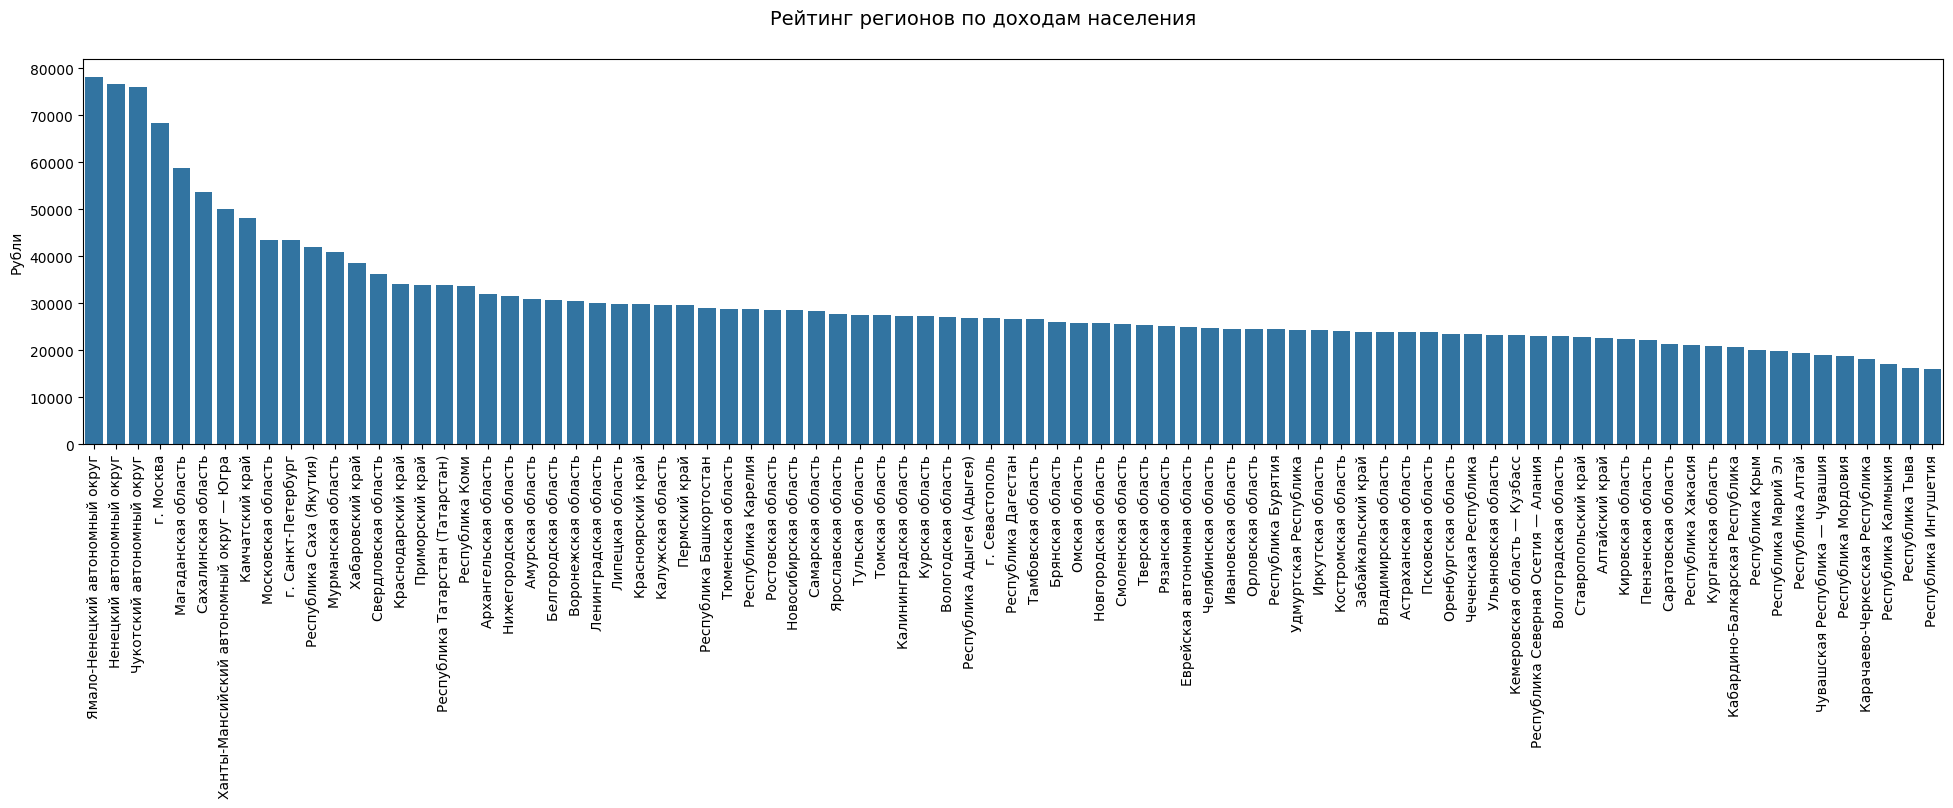

In [1814]:
# посмотрим на графике полученные данные
top_cash_real = data.sort_values(by='cash_real_income_wages', ascending=False) # сортируем по cash_real_income_wages
fig = plt.figure(figsize=(24,5))
sns.barplot(data=top_cash_real, x=top_cash_real.index, y='cash_real_income_wages')
fig.suptitle(
    'Рейтинг регионов по доходам населения',
    fontsize=14)
plt.xlabel('')
plt.ylabel('Рубли')
plt.xticks(rotation = 90);

Самые большие доходы в Ямало-Ненецком автономном, Нененцком автономном, Чукотском автономном округах и в Москве.

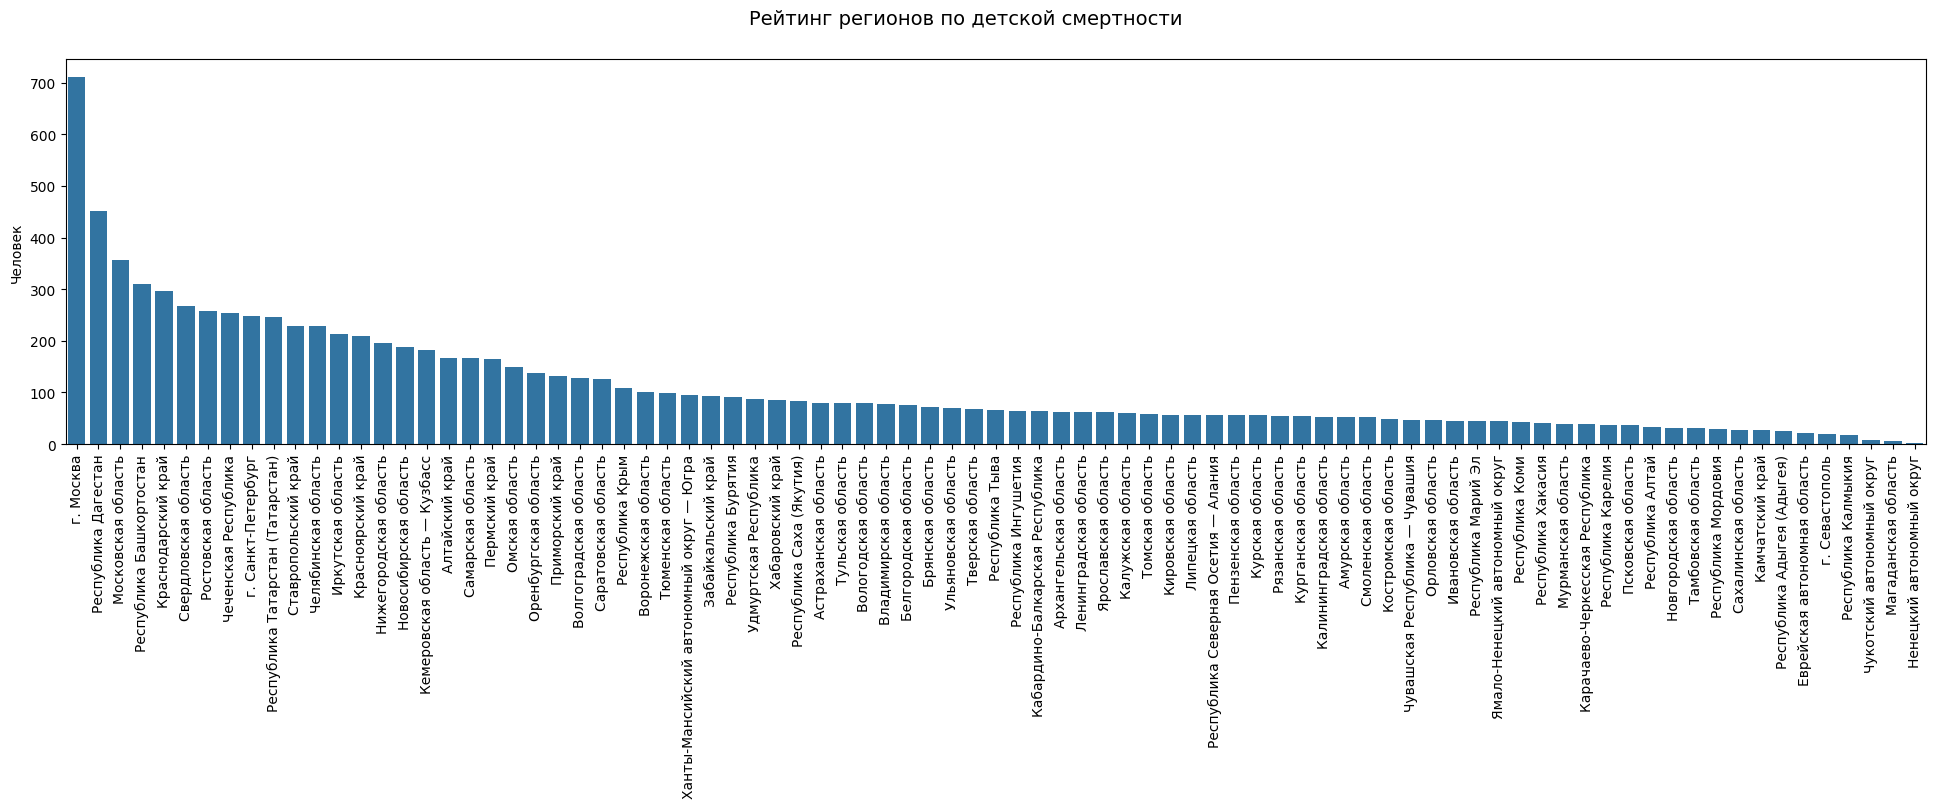

In [1815]:
# строим график
top_child_mortality = data.sort_values(by='child_mortality', ascending=False) # сортируем по child_mortality
fig = plt.figure(figsize=(24,5))
sns.barplot(data=top_child_mortality, x=top_child_mortality.index, y='child_mortality')
fig.suptitle(
    'Рейтинг регионов по детской смертности',
    fontsize=14)
plt.xlabel('')
plt.ylabel('Человек')
plt.xticks(rotation = 90);

Самая большая детская смертность в городе Москва.

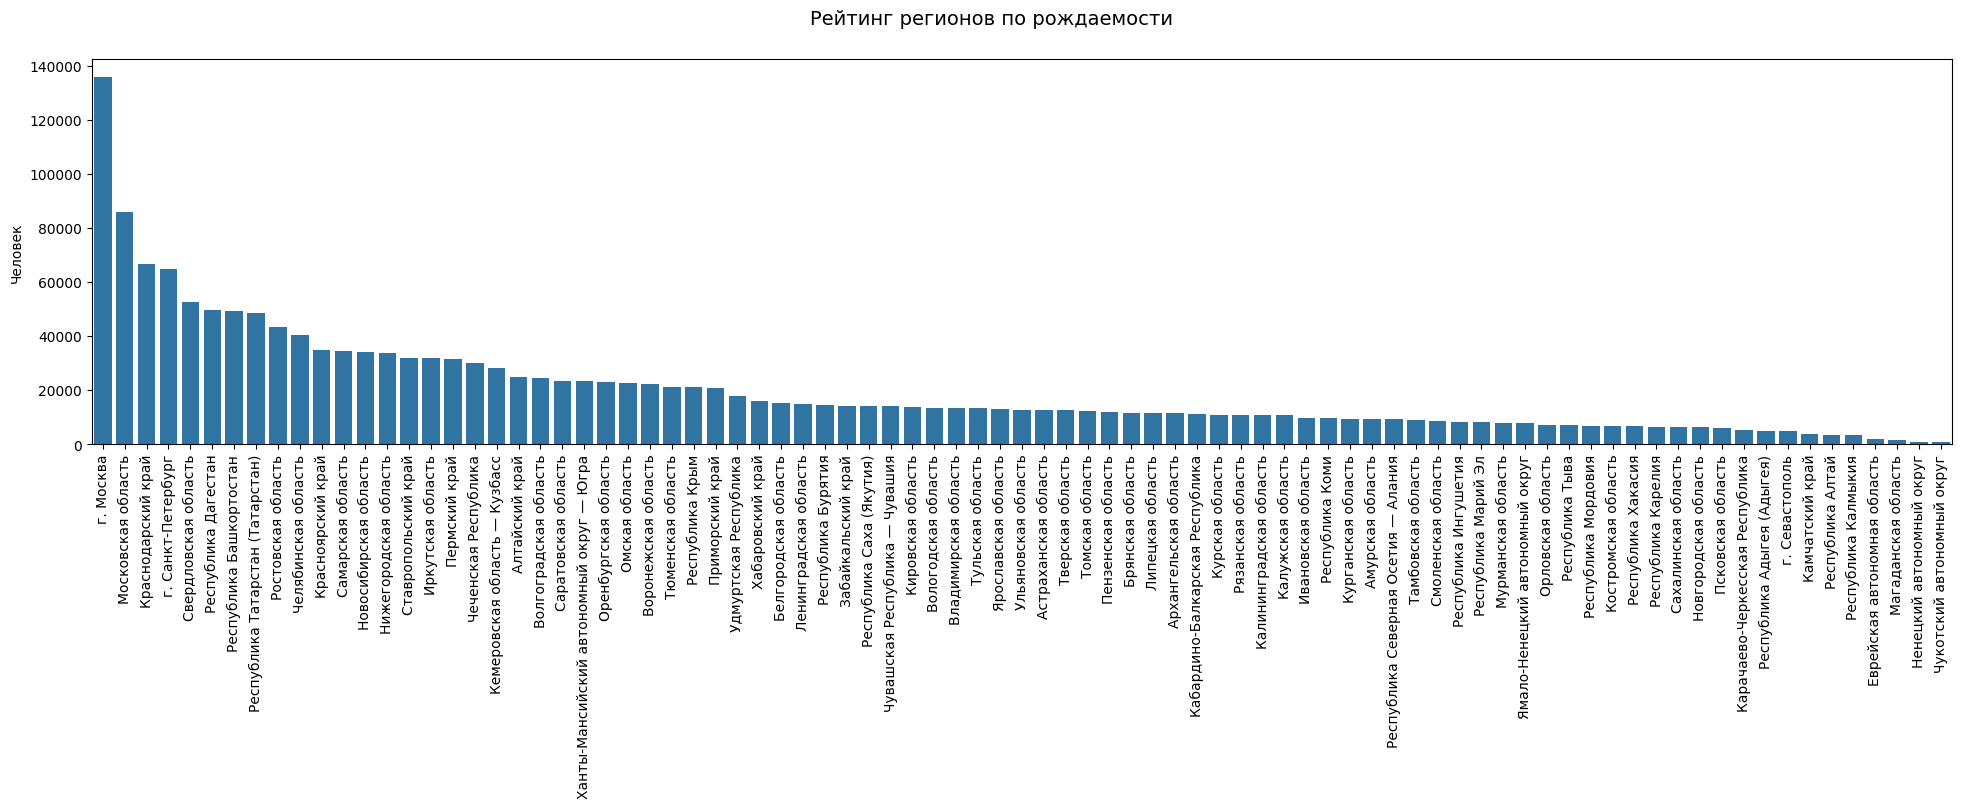

In [1816]:
# строим график
top_newborn_monthly = data.sort_values(by='newborn_monthly', ascending=False) # сортируем по newborn_monthly
fig = plt.figure(figsize=(24,5))
sns.barplot(data=top_newborn_monthly, x=top_newborn_monthly.index, y='newborn_monthly')
fig.suptitle(
    'Рейтинг регионов по рождаемости',
    fontsize=14)
plt.xlabel('')
plt.ylabel('Человек')
plt.xticks(rotation = 90);

Также лидирует Москва.

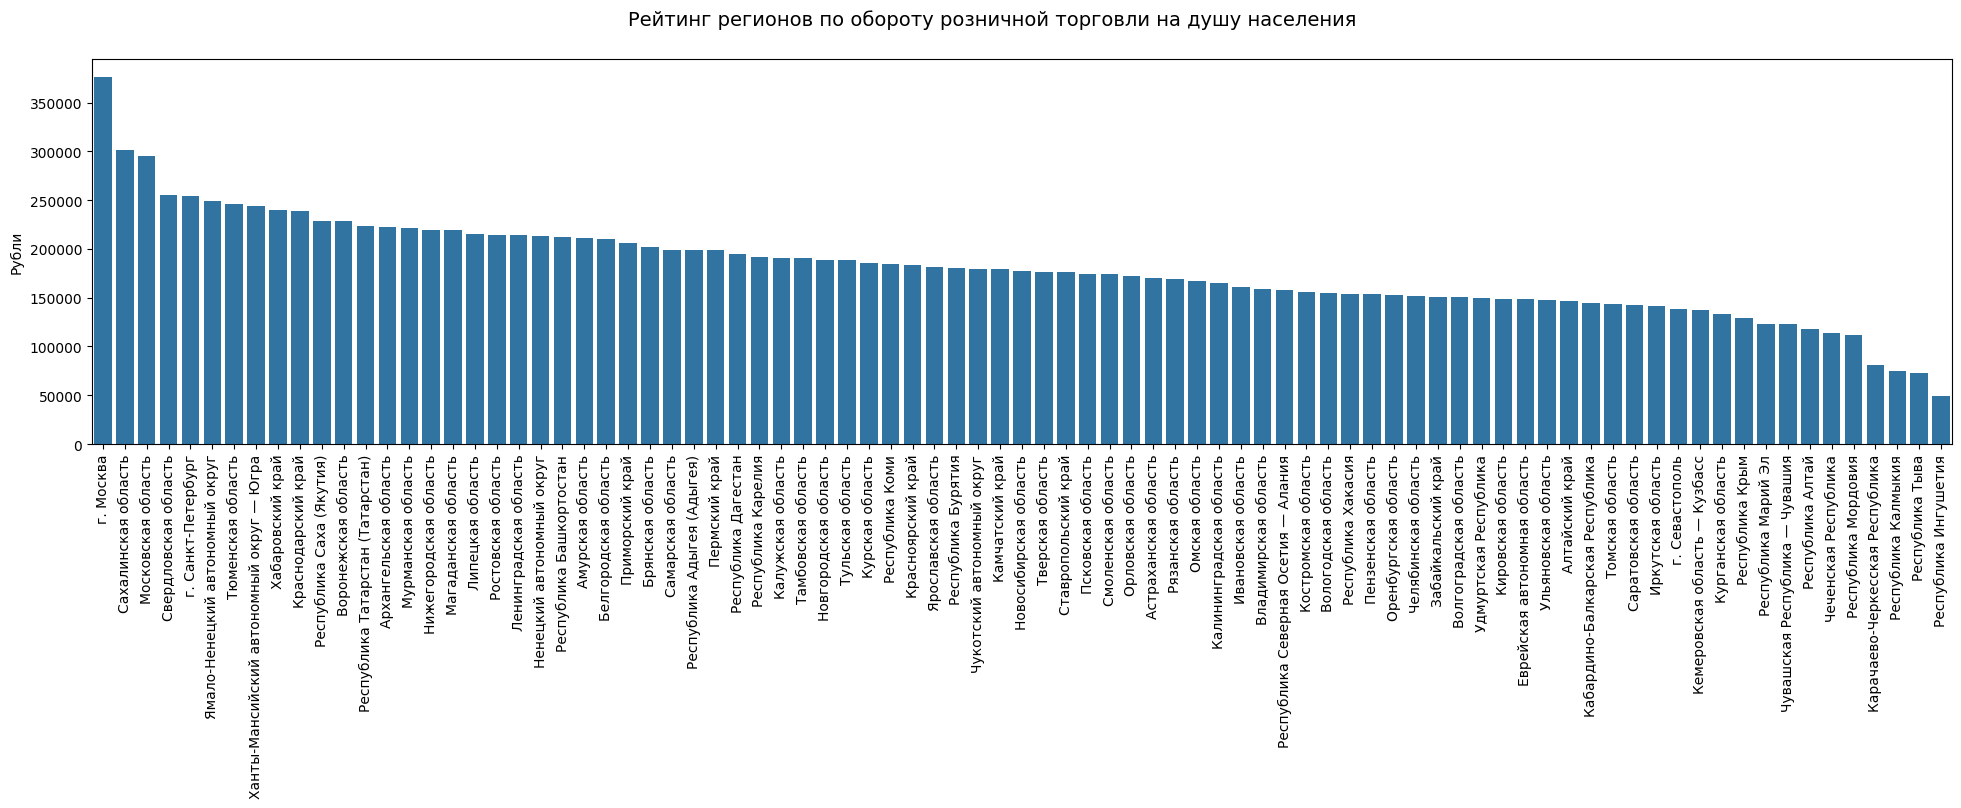

In [1817]:
# строим график
# сначала выполняем сортировку по колонке retail_turnover_per_capita
top_retail_turnover_per_capita = data.sort_values(by='retail_turnover_per_capita', ascending=False) 
fig = plt.figure(figsize=(24,5))
sns.barplot(data=top_retail_turnover_per_capita, x=top_retail_turnover_per_capita.index, y='retail_turnover_per_capita')
fig.suptitle(
    'Рейтинг регионов по обороту розничной торговли на душу населения',
    fontsize=14)
plt.xlabel('')
plt.ylabel('Рубли')
plt.xticks(rotation = 90);

Лидирует Москва, на втором месте Сахалинская область, которая также имеет высокий уровень доходов среди населения, судя по первому графику.

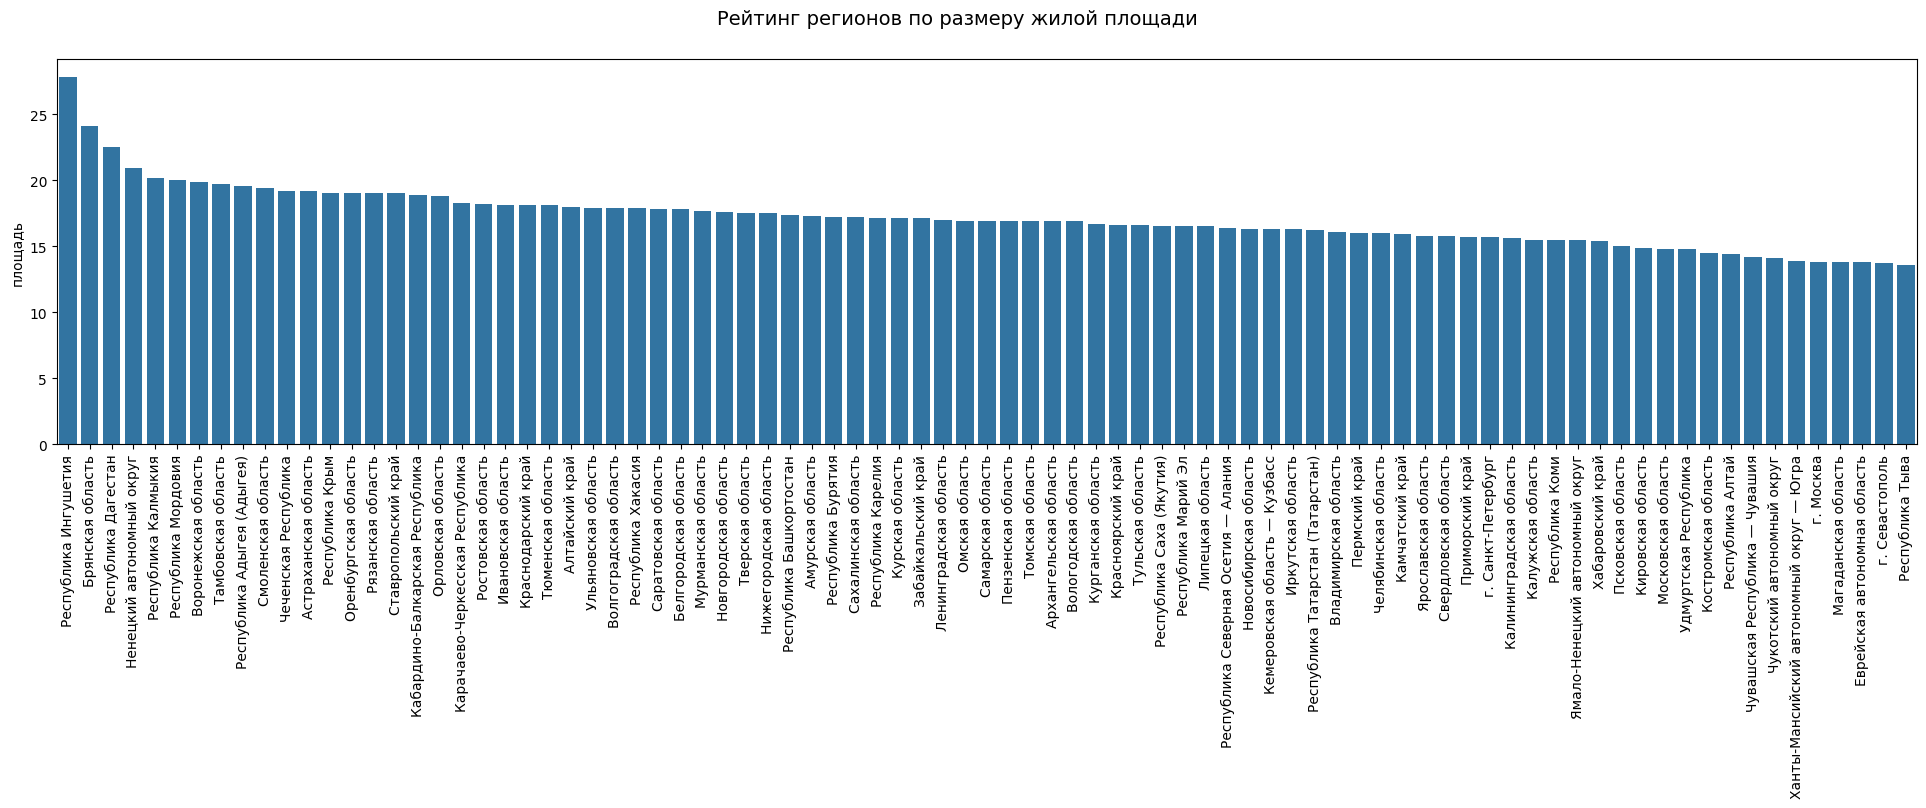

In [1818]:
# строим график
# сначала выполняем сортировку по колонке "size of living space"
top_living_space = data.sort_values(by='size of living space', ascending=False)
fig = plt.figure(figsize=(24,5))
sns.barplot(data=top_living_space, x=top_living_space.index, y='size of living space')
fig.suptitle(
    'Рейтинг регионов по размеру жилой площади',
    fontsize=14)
plt.xlabel('')
plt.ylabel('площадь')
plt.xticks(rotation = 90);

Москва оказалась в конце графика, возможно информация по проживанию не влияет на бедность населения. Возможно жилье никак не влияет на уровень бедности в регионе.

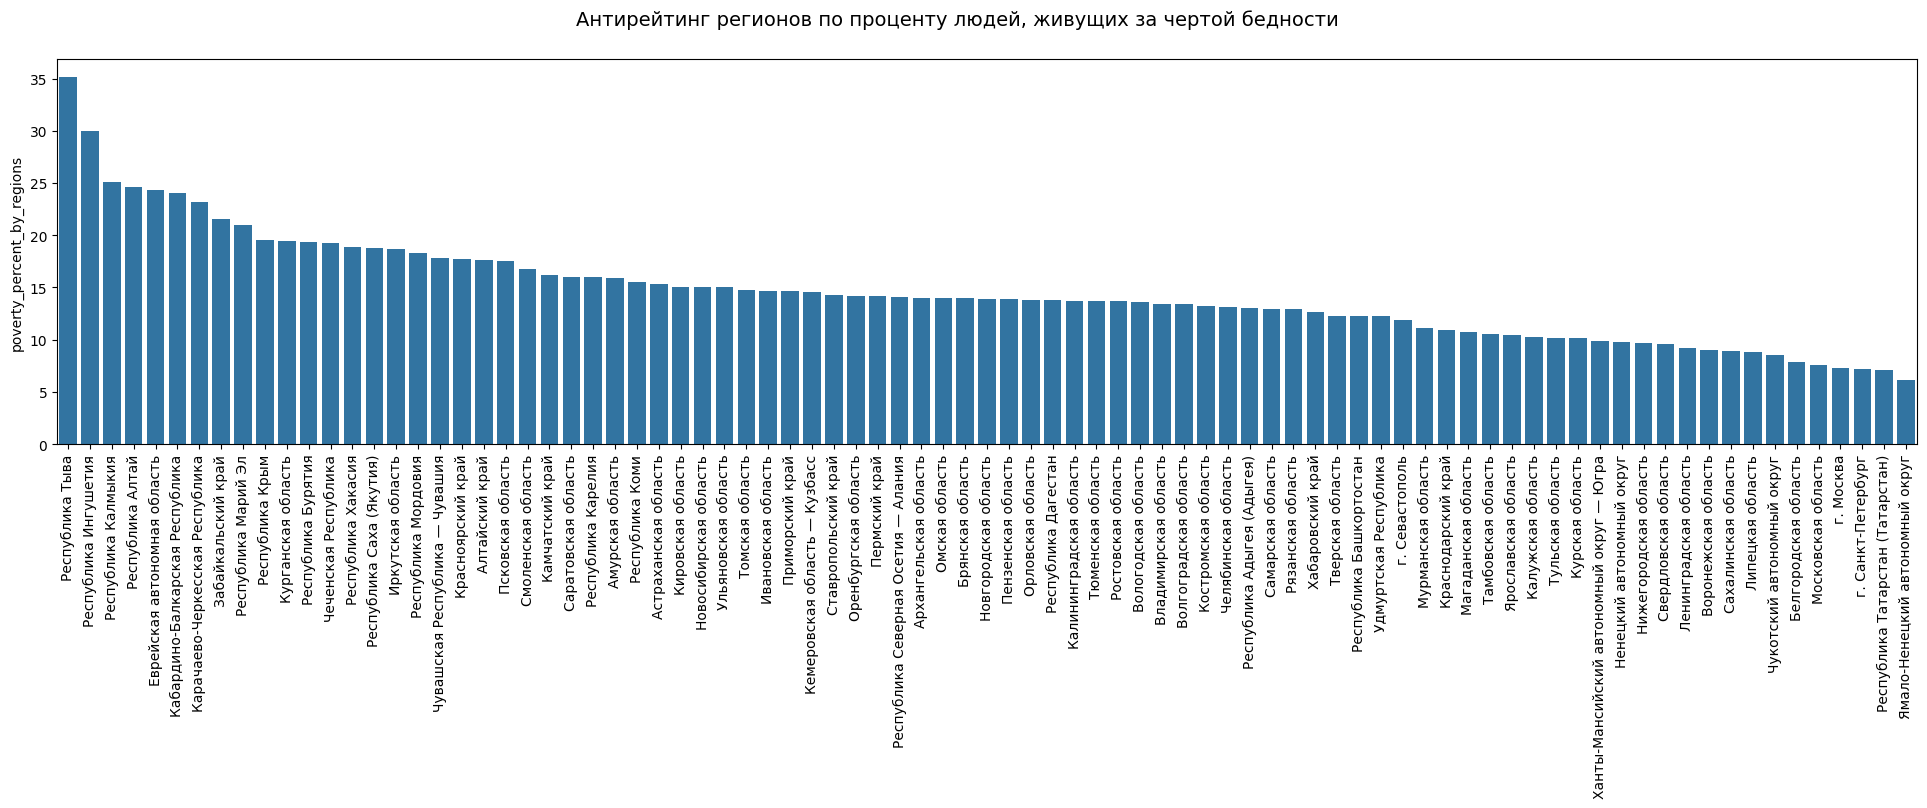

In [1819]:
# строим график
# сначала выполняем сортировку по колонке poverty_percent_by_regions
data.sort_values(by='poverty_percent_by_regions', ascending=False, inplace=True)
fig = plt.figure(figsize=(24,5))
sns.barplot(data=data, x=data.index, y='poverty_percent_by_regions')
fig.suptitle(
    'Антирейтинг регионов по проценту людей, живущих за чертой бедности',
    fontsize=14);
plt.xlabel('')
plt.xticks(rotation = 90);

Республика Тыва лидирует по количеству людей за чертой бедности, крупные города и Ямало-Ненецкий АО в конце, но они лидеры по доходам населения, т.е. можем предположить, что чем выше доходы населения в регионе, тем меньше людей за чертой бедности в регионе.

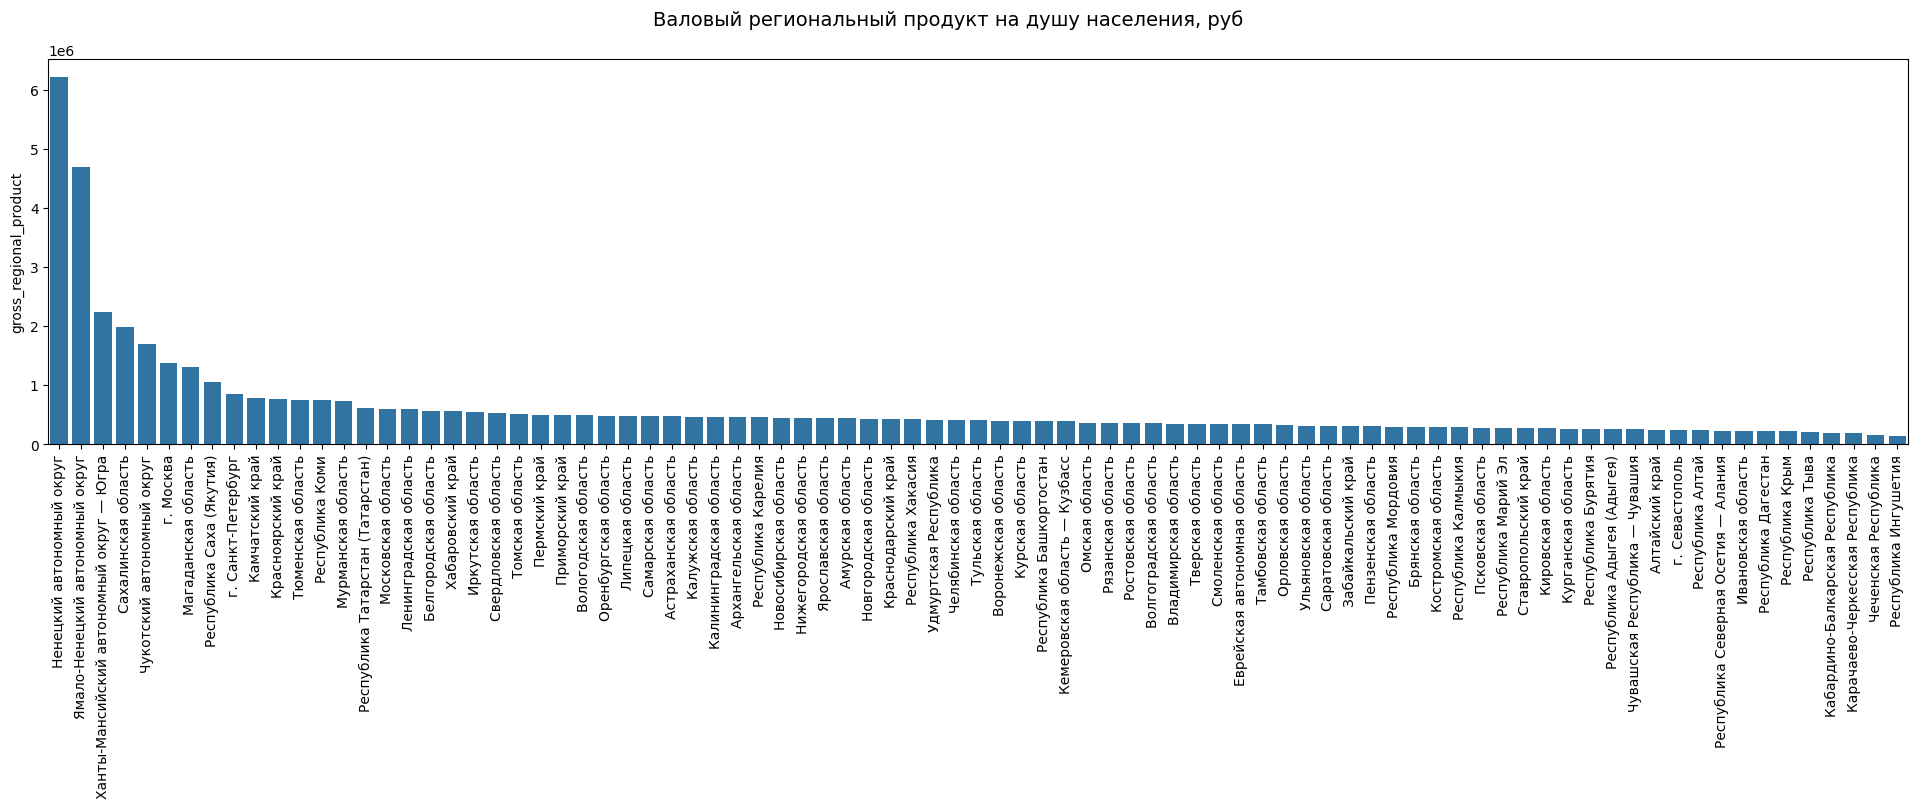

In [1820]:
# строим график
# сначала выполняем сортировку по колонке gross_regional_product
data.sort_values(by='gross_regional_product', ascending=False, inplace=True)
fig = plt.figure(figsize=(24,5))
sns.barplot(data=data, x=data.index, y='gross_regional_product')
fig.suptitle(
    'Валовый региональный продукт на душу населения, руб',
    fontsize=14);
plt.xlabel('')
plt.xticks(rotation = 90);

Высокий валовый региональный продукт также благоприятно сказывается на отсутствии бедности.

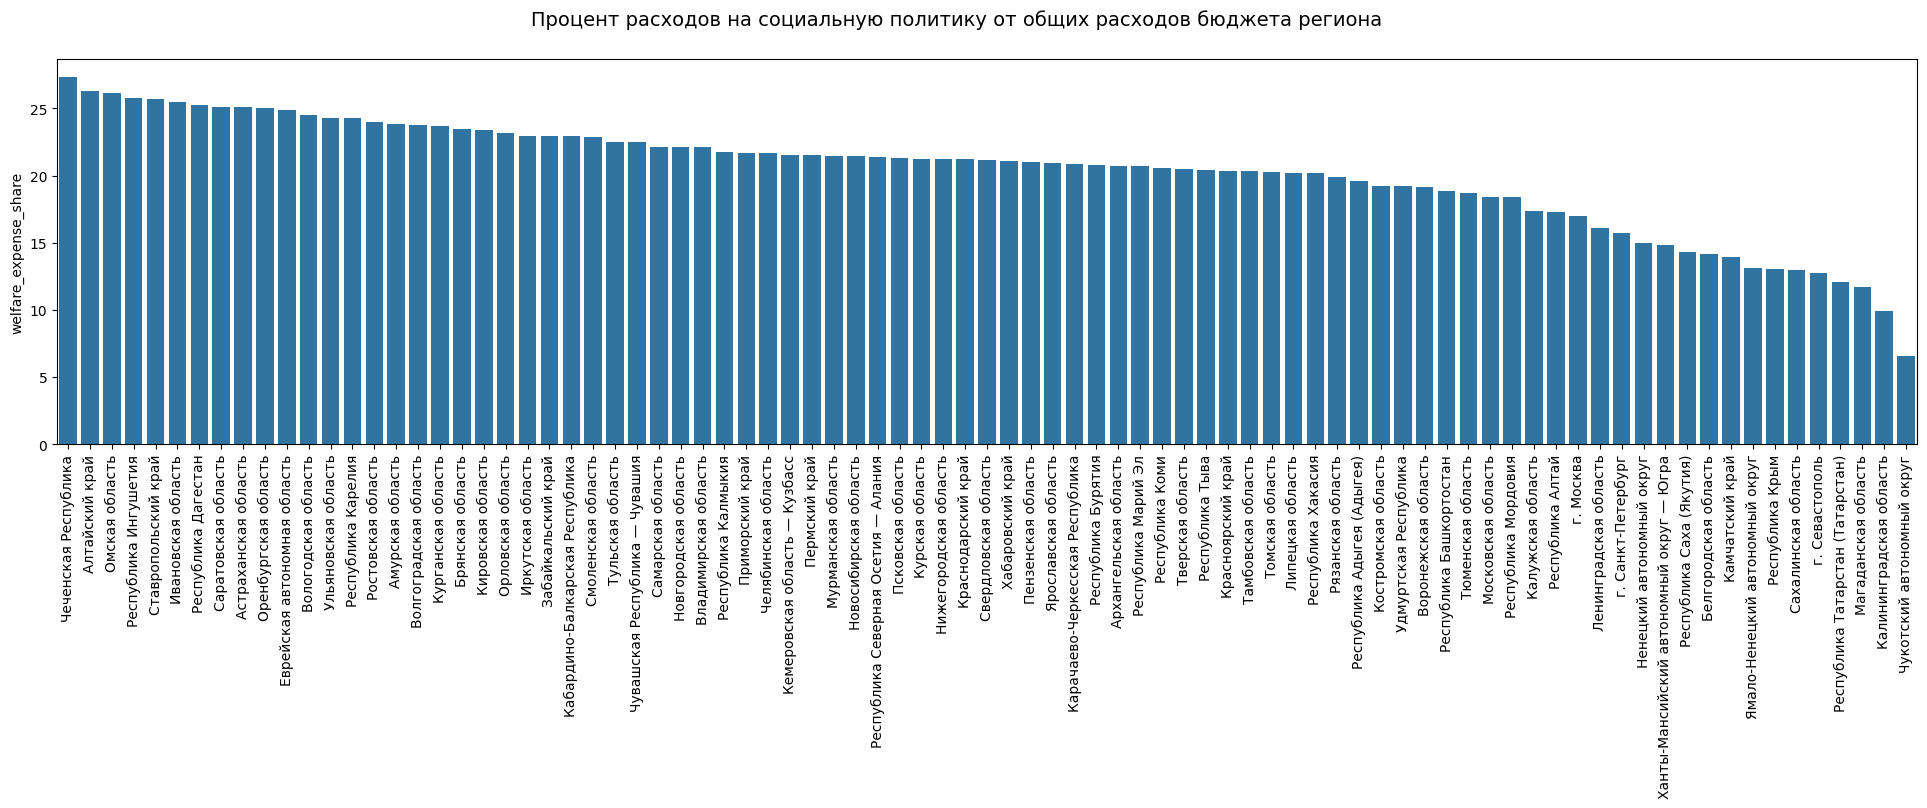

In [1821]:
# строим график
# сначала выполняем сортировку по колонке welfare_expense_share
data.sort_values(by='welfare_expense_share', ascending=False, inplace=True)
fig = plt.figure(figsize=(24,5))
sns.barplot(data=data, x=data.index, y='welfare_expense_share')
fig.suptitle(
    'Процент расходов на социальную политику от общих расходов бюджета региона',
    fontsize=14);
plt.xlabel('')
plt.xticks(rotation = 90);

Ямало-Ненецкий АО оказался в конце списка по расходам на социальную политику, как и Москва. Республика Тыва тоже не в начале рейтинга, но значения по большей части схожие. Возможно этот признак нам не нужен.

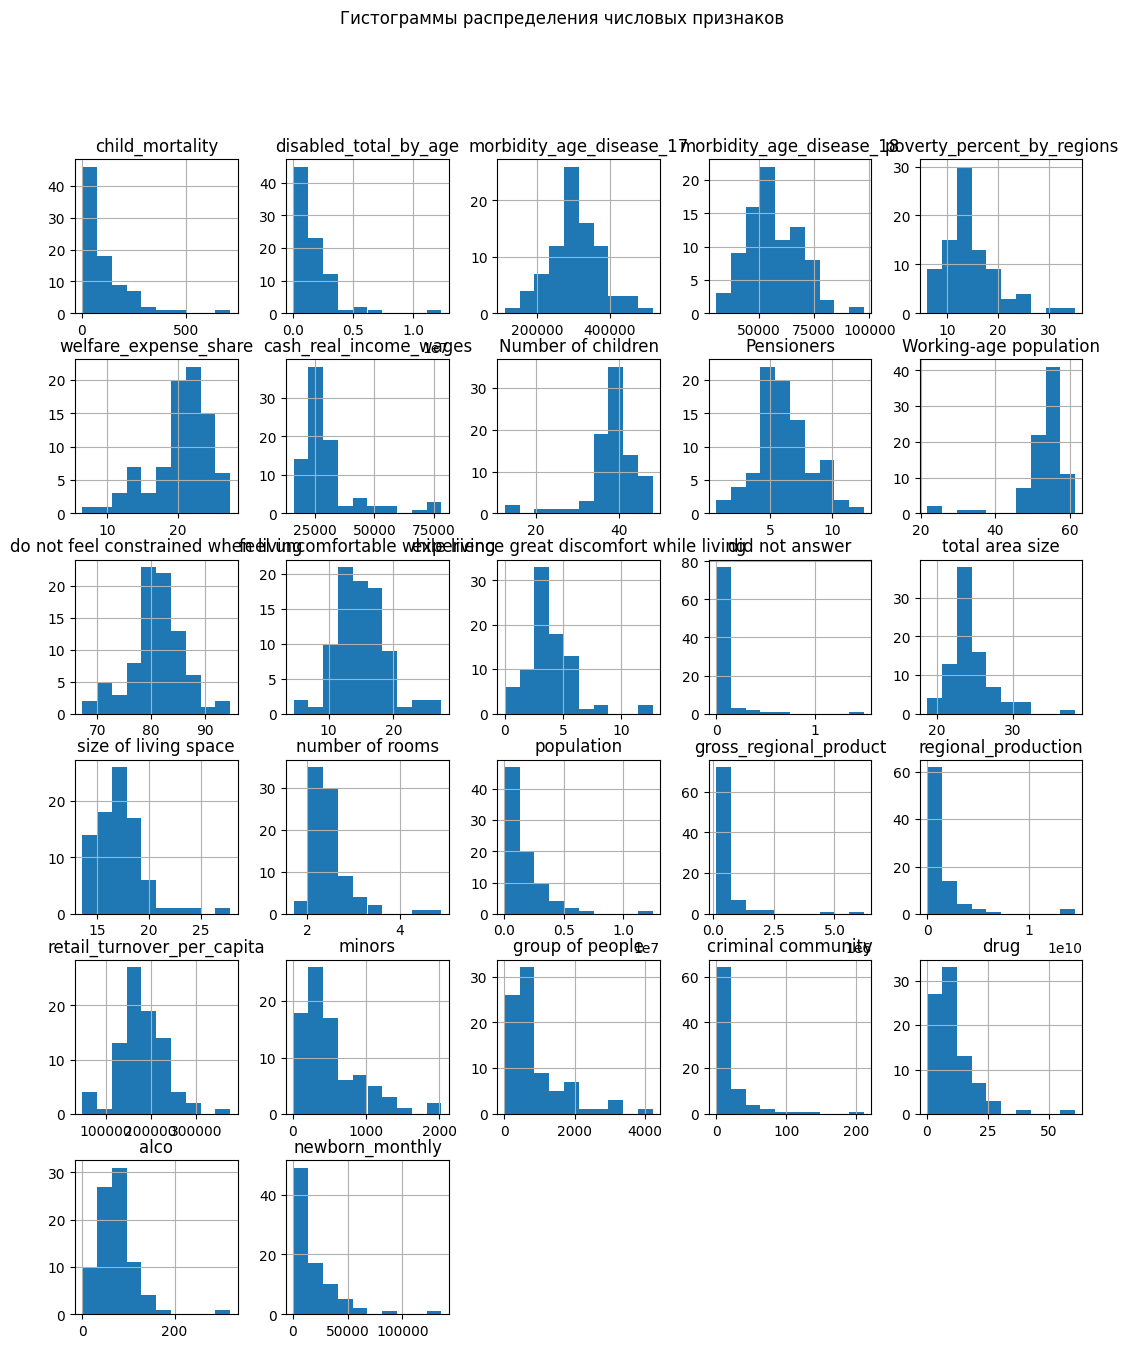

In [1822]:
# Гистограммы распределения числовых признаков
fig, (ax1) = plt.subplots(1, figsize=(13, 15))
data.hist(ax=ax1)
plt.suptitle('Гистограммы распределения числовых признаков');

Данные распределены не нормально, к нормльному распределению больше всего приближены графики "morbidity_age_disease_17", "morbidity_age_disease_18", "Pensioners", "do not feel constrained when living" и "retail_turnover_per_capita".

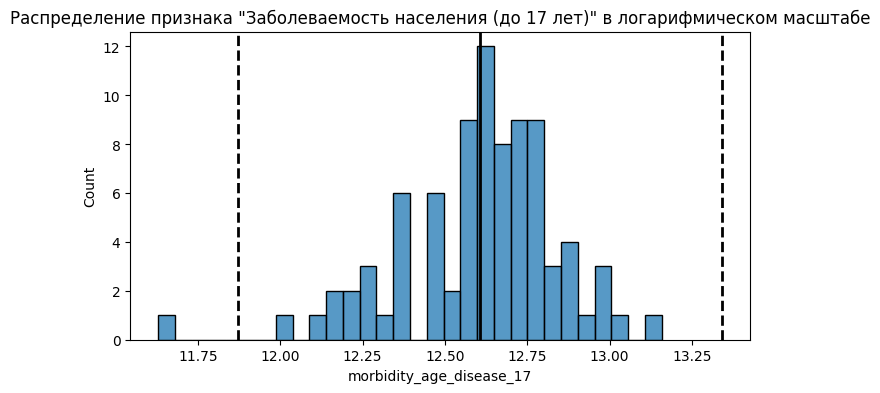

In [1823]:
# построим графика распределения для некоторых признаков
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
# логарифмируем
log_data = np.log(data['morbidity_age_disease_17'] + 1)
# строим график
histplot = sns.histplot(log_data, bins=30, ax=ax)
histplot.axvline(log_data.mean(), color='k', lw=2)
histplot.axvline(log_data.mean()+ 3 * log_data.std(), color='k', ls='--', lw=2)
histplot.axvline(log_data.mean()- 3 * log_data.std(), color='k', ls='--', lw=2)
histplot.set_title('Распределение признака "Заболеваемость населения (до 17 лет)" в логарифмическом масштабе');
#fig.savefig("data/hist_morbidity_age_disease_17.png")

Есть выбросы. Удалять не будем. Распределение похоже на нормальное.

In [1824]:
# проверим на выбросы
outliers = outliers_z_score_mod(data, 'morbidity_age_disease_17', log_scale=True, left=3, right=4)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
outliers

Число выбросов по методу z-отклонения: 1


child_mortality  disabled_total_by_age  \
Чеченская Республика       253.166667             1881876.25   

                      morbidity_age_disease_17  morbidity_age_disease_18  \
Чеченская Республика                  112481.4                   55920.9   

                      poverty_percent_by_regions  welfare_expense_share  \
Чеченская Республика                   19.266667              27.316667   

                      cash_real_income_wages  Number of children  Pensioners  \
Чеченская Республика                 23330.5              46.025        6.65   

                      Working-age population  ...    population  \
Чеченская Республика                  47.325  ...  1.425327e+06   

                      gross_regional_product  regional_production  \
Чеченская Республика           149513.866667         5.869030e+07   

                      retail_turnover_per_capita  minors  group of people  \
Чеченская Республика               114256.333333    11.4             91.0   

                      criminal community  drug  alco  newborn_monthly  
Чеченская Республика                 0.0   0.7  3.55         29996.48  

[1 rows x 27 columns]

Заболеваемость среди детей в Чеченской республике самая низкая.

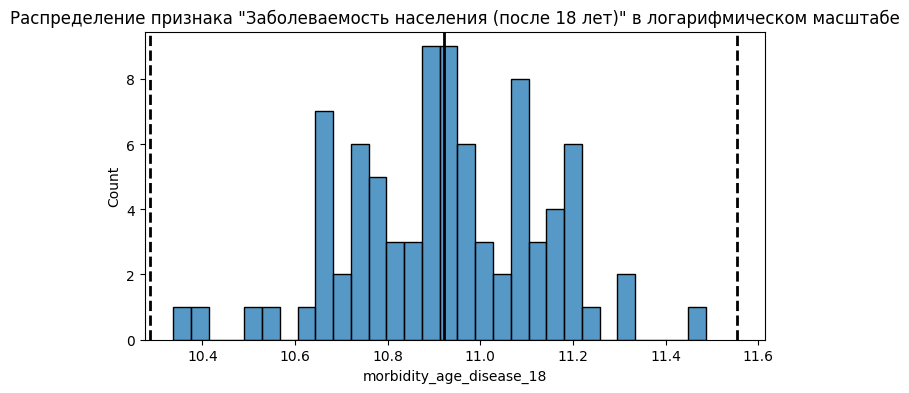

In [1825]:
#построим график распределения признака morbidity_age_disease_18
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_data = np.log(data['morbidity_age_disease_18'] + 1)
histplot = sns.histplot(log_data, bins=30, ax=ax)
histplot.axvline(log_data.mean(), color='k', lw=2)
histplot.axvline(log_data.mean()+ 3 * log_data.std(), color='k', ls='--', lw=2)
histplot.axvline(log_data.mean()- 3 * log_data.std(), color='k', ls='--', lw=2)
histplot.set_title('Распределение признака "Заболеваемость населения (после 18 лет)" в логарифмическом масштабе');
#fig.savefig("data/hist_morbidity_age_disease_18.png")

Выбросов не наблюдаем. Распределение не нормальное.

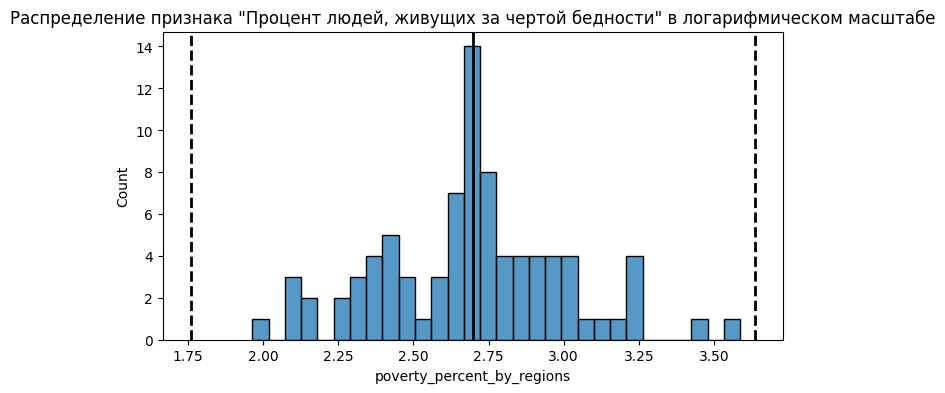

In [1826]:
#построим график распределения признака poverty_percent_by_regions
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_data = np.log(data['poverty_percent_by_regions'] + 1)
histplot = sns.histplot(log_data, bins=30, ax=ax)
histplot.axvline(log_data.mean(), color='k', lw=2)
histplot.axvline(log_data.mean()+ 3 * log_data.std(), color='k', ls='--', lw=2)
histplot.axvline(log_data.mean()- 3 * log_data.std(), color='k', ls='--', lw=2)
histplot.set_title('Распределение признака "Процент людей, живущих за чертой бедности" в логарифмическом масштабе');
#fig.savefig("data/hist_poverty_percent_by_regions.png")

Выбросов не наблюдаем. Распределение не нормальное.

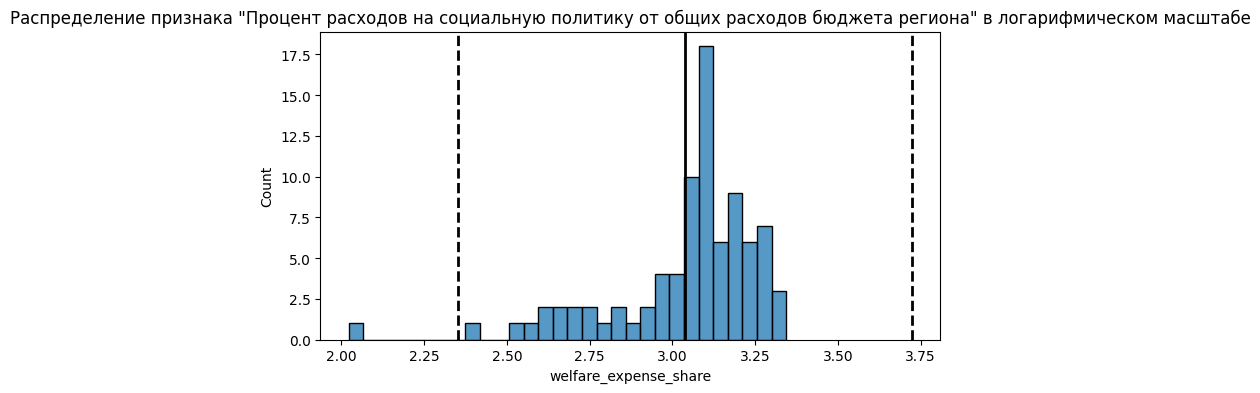

In [1827]:
#построим график распределения признака welfare_expense_share
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_data = np.log(data['welfare_expense_share'] + 1)
histplot = sns.histplot(log_data, bins=30, ax=ax)
histplot.axvline(log_data.mean(), color='k', lw=2)
histplot.axvline(log_data.mean()+ 3 * log_data.std(), color='k', ls='--', lw=2)
histplot.axvline(log_data.mean()- 3 * log_data.std(), color='k', ls='--', lw=2)
histplot.set_title('Распределение признака "Процент расходов на социальную политику от общих расходов бюджета региона" в логарифмическом масштабе');
#fig.savefig("data/hist_welfare_expense_share.png")

Распределение не нормальное.

In [1828]:
# проверим на выбросы
outliers = outliers_z_score_mod(data, 'welfare_expense_share', log_scale=True, left=3, right=4)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
outliers

Число выбросов по методу z-отклонения: 1


child_mortality  disabled_total_by_age  \
Чукотский автономный округ              8.5                19196.5   

                            morbidity_age_disease_17  \
Чукотский автономный округ                 441821.85   

                            morbidity_age_disease_18  \
Чукотский автономный округ                  72492.45   

                            poverty_percent_by_regions  welfare_expense_share  \
Чукотский автономный округ                         8.5                   6.55   

                            cash_real_income_wages  Number of children  \
Чукотский автономный округ            75961.833333              24.475   

                            Pensioners  Working-age population  ...  \
Чукотский автономный округ       0.675                   24.85  ...   

                              population  gross_regional_product  \
Чукотский автономный округ  49969.666667               1687939.8   

                            regional_production  retail_turnover_per_capita  \
Чукотский автономный округ         1.554262e+08               179575.666667   

                            minors  group of people  criminal community  drug  \
Чукотский автономный округ    19.6             18.0                 0.0   0.5   

                               alco  newborn_monthly  
Чукотский автономный округ  320.625            616.0  

[1 rows x 27 columns]

Процент расходов на социальную политику от общих расходов бюджета региона самый низкий в Чукотском автономном округе.

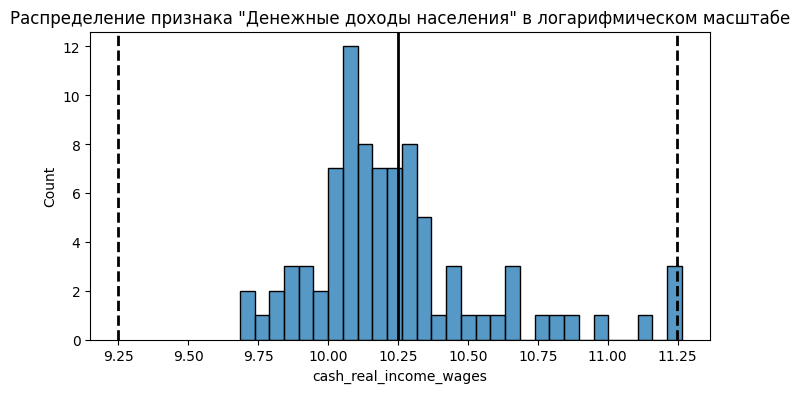

In [1829]:
#построим график распределения признака cash_real_income_wages
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_data = np.log(data['cash_real_income_wages'] + 1)
histplot = sns.histplot(log_data, bins=30, ax=ax)
histplot.axvline(log_data.mean(), color='k', lw=2)
histplot.axvline(log_data.mean()+ 3 * log_data.std(), color='k', ls='--', lw=2)
histplot.axvline(log_data.mean()- 3 * log_data.std(), color='k', ls='--', lw=2)
histplot.set_title('Распределение признака "Денежные доходы населения" в логарифмическом масштабе');
#fig.savefig("data/hist_cash_real_income_wages.png")

Выбросов не наблюдаем. Распределение не нормальное.

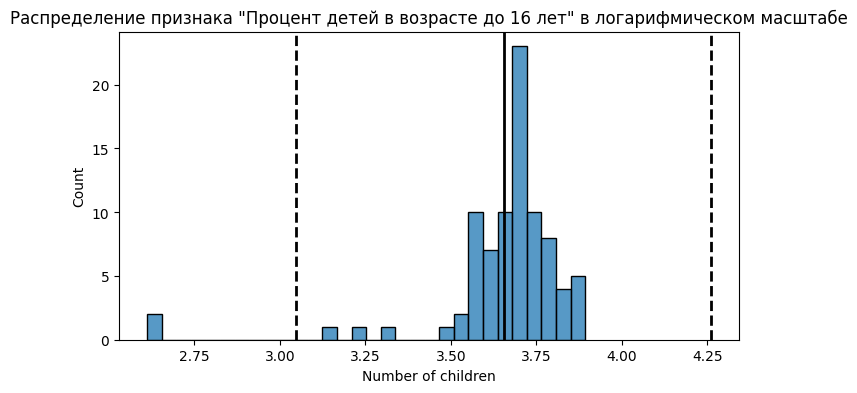

In [1830]:
#построим график распределения признака "Number of children"
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_data = np.log(data['Number of children'] + 1)
histplot = sns.histplot(log_data, bins=30, ax=ax)
histplot.axvline(log_data.mean(), color='k', lw=2)
histplot.axvline(log_data.mean()+ 3 * log_data.std(), color='k', ls='--', lw=2)
histplot.axvline(log_data.mean()- 3 * log_data.std(), color='k', ls='--', lw=2)
histplot.set_title('Распределение признака "Процент детей в возрасте до 16 лет" в логарифмическом масштабе');
#fig.savefig("data/hist_Number of children.png")

Распределение не нормальное.

In [1831]:
# проверим на выбросы
outliers = outliers_z_score_mod(data, 'Number of children', log_scale=True, left=3, right=4)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
outliers

Число выбросов по методу z-отклонения: 2


child_mortality  disabled_total_by_age  \
Ленинградская область        62.166667              1662631.0   
г. Санкт-Петербург          247.833333              7051476.5   

                       morbidity_age_disease_17  morbidity_age_disease_18  \
Ленинградская область                 283192.10                  45946.65   
г. Санкт-Петербург                    402231.35                  72330.65   

                       poverty_percent_by_regions  welfare_expense_share  \
Ленинградская область                        9.15              16.116667   
г. Санкт-Петербург                           7.15              15.733333   

                       cash_real_income_wages  Number of children  Pensioners  \
Ленинградская область            30088.166667              12.625        5.85   
г. Санкт-Петербург               43499.000000              13.075        2.45   

                       Working-age population  ...    population  \
Ленинградская область                   31.55  ...  1.813978e+06   
г. Санкт-Петербург                      34.50  ...  5.305475e+06   

                       gross_regional_product  regional_production  \
Ленинградская область           585691.516667         1.967330e+09   
г. Санкт-Петербург              841584.600000         4.562184e+09   

                       retail_turnover_per_capita  minors  group of people  \
Ленинградская область               214254.666667   385.4            810.2   
г. Санкт-Петербург                  254799.666667   558.8           1401.4   

                       criminal community   drug   alco  newborn_monthly  
Ленинградская область                 8.2  9.125  38.45     14699.666667  
г. Санкт-Петербург                   60.4  9.950  18.85     64764.660000  

[2 rows x 27 columns]

Меньше всего детей по отношению ко всему населению региона в Санкт-Петербурге и Ленинградской области.

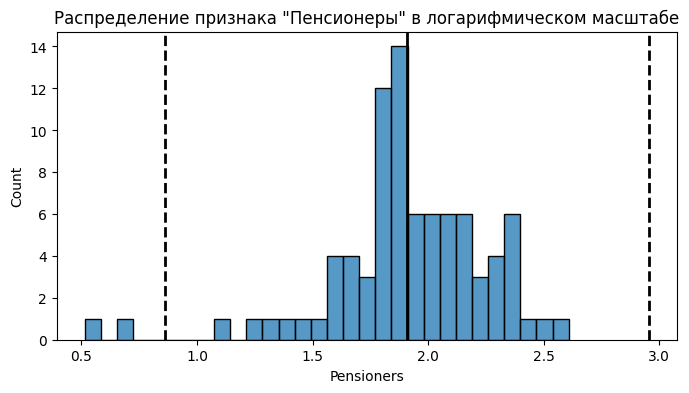

In [1832]:
#построим график распределения признака Pensioners
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_data = np.log(data['Pensioners'] + 1)
histplot = sns.histplot(log_data, bins=30, ax=ax)
histplot.axvline(log_data.mean(), color='k', lw=2)
histplot.axvline(log_data.mean()+ 3 * log_data.std(), color='k', ls='--', lw=2)
histplot.axvline(log_data.mean()- 3 * log_data.std(), color='k', ls='--', lw=2)
histplot.set_title('Распределение признака "Пенсионеры" в логарифмическом масштабе');
#fig.savefig("data/hist_Pensioners.png")

Распределение не нормальное.

In [1833]:
# проверим на выбросы
outliers = outliers_z_score_mod(data, 'Pensioners', log_scale=True, left=3, right=4)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
outliers

Число выбросов по методу z-отклонения: 2


child_mortality  disabled_total_by_age  \
Ямало-Ненецкий автономный округ             44.0               162688.5   
Чукотский автономный округ                   8.5                19196.5   

                                 morbidity_age_disease_17  \
Ямало-Ненецкий автономный округ                 397540.05   
Чукотский автономный округ                      441821.85   

                                 morbidity_age_disease_18  \
Ямало-Ненецкий автономный округ                  76471.65   
Чукотский автономный округ                       72492.45   

                                 poverty_percent_by_regions  \
Ямало-Ненецкий автономный округ                    6.133333   
Чукотский автономный округ                         8.500000   

                                 welfare_expense_share  \
Ямало-Ненецкий автономный округ              13.116667   
Чукотский автономный округ                    6.550000   

                                 cash_real_income_wages  Number of children  \
Ямало-Ненецкий автономный округ            78070.500000              47.700   
Чукотский автономный округ                 75961.833333              24.475   

                                 Pensioners  Working-age population  ...  \
Ямало-Ненецкий автономный округ       1.050                  51.225  ...   
Чукотский автономный округ            0.675                  24.850  ...   

                                    population  gross_regional_product  \
Ямало-Ненецкий автономный округ  539101.333333            4.688753e+06   
Чукотский автономный округ        49969.666667            1.687940e+06   

                                 regional_production  \
Ямало-Ненецкий автономный округ         4.308450e+09   
Чукотский автономный округ              1.554262e+08   

                                 retail_turnover_per_capita  minors  \
Ямало-Ненецкий автономный округ               248979.000000   144.2   
Чукотский автономный округ                    179575.666667    19.6   

                                 group of people  criminal community  drug  \
Ямало-Ненецкий автономный округ            236.4                 2.0  14.2   
Чукотский автономный округ                  18.0                 0.0   0.5   

                                    alco  newborn_monthly  
Ямало-Ненецкий автономный округ  106.400           7654.5  
Чукотский автономный округ       320.625            616.0  

[2 rows x 27 columns]

Меньше всего пенсионеров в Ямало-Ненецком автономном округе и Чукотском автономном округе.	

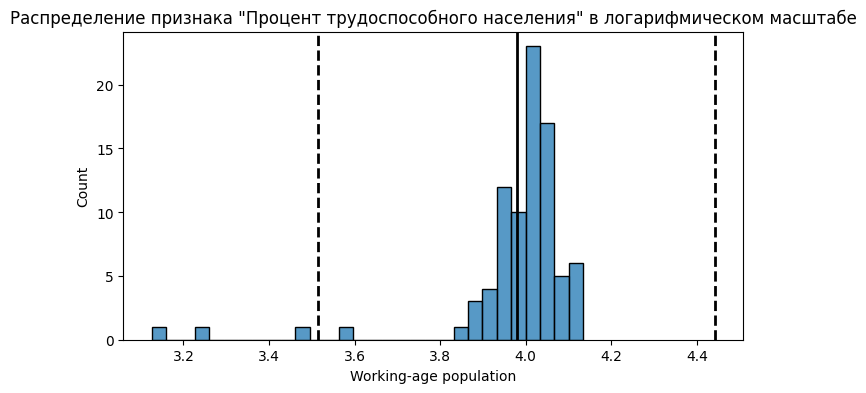

In [1834]:
#построим график распределения признака "Working-age population"
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_data = np.log(data['Working-age population'] + 1)
histplot = sns.histplot(log_data, bins=30, ax=ax)
histplot.axvline(log_data.mean(), color='k', lw=2)
histplot.axvline(log_data.mean()+ 3 * log_data.std(), color='k', ls='--', lw=2)
histplot.axvline(log_data.mean()- 3 * log_data.std(), color='k', ls='--', lw=2)
histplot.set_title('Распределение признака "Процент трудоспособного населения" в логарифмическом масштабе');
#fig.savefig("data/hist_Working-age population.png")

Распределение не нормальное.

In [1835]:
# проверим на выбросы
outliers = outliers_z_score_mod(data, 'Working-age population', log_scale=True, left=3, right=4)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
outliers

Число выбросов по методу z-отклонения: 3


child_mortality  disabled_total_by_age  \
Ленинградская область             62.166667             1662631.00   
Белгородская область              75.666667             2488511.25   
Чукотский автономный округ         8.500000               19196.50   

                            morbidity_age_disease_17  \
Ленинградская область                      283192.10   
Белгородская область                       306777.05   
Чукотский автономный округ                 441821.85   

                            morbidity_age_disease_18  \
Ленинградская область                       45946.65   
Белгородская область                        56243.05   
Чукотский автономный округ                  72492.45   

                            poverty_percent_by_regions  welfare_expense_share  \
Ленинградская область                         9.150000              16.116667   
Белгородская область                          7.816667              14.166667   
Чукотский автономный округ                    8.500000               6.550000   

                            cash_real_income_wages  Number of children  \
Ленинградская область                 30088.166667              12.625   
Белгородская область                  30692.500000              22.050   
Чукотский автономный округ            75961.833333              24.475   

                            Pensioners  Working-age population  ...  \
Ленинградская область            5.850                  31.550  ...   
Белгородская область             6.175                  21.775  ...   
Чукотский автономный округ       0.675                  24.850  ...   

                              population  gross_regional_product  \
Ленинградская область       1.813978e+06            5.856915e+05   
Белгородская область        1.549564e+06            5.569075e+05   
Чукотский автономный округ  4.996967e+04            1.687940e+06   

                            regional_production  retail_turnover_per_capita  \
Ленинградская область              1.967330e+09               214254.666667   
Белгородская область               1.429629e+09               209789.666667   
Чукотский автономный округ         1.554262e+08               179575.666667   

                            minors  group of people  criminal community  \
Ленинградская область        385.4            810.2                 8.2   
Белгородская область         235.0            483.2                42.2   
Чукотский автономный округ    19.6             18.0                 0.0   

                             drug     alco  newborn_monthly  
Ленинградская область       9.125   38.450     14699.666667  
Белгородская область        2.275   45.825     15017.663333  
Чукотский автономный округ  0.500  320.625       616.000000  

[3 rows x 27 columns]

Меньше всего трудоспособного насления (по отношению к всему населению региона) в Чукотском автономном округе, Белгородской и Ленинградской областях.	

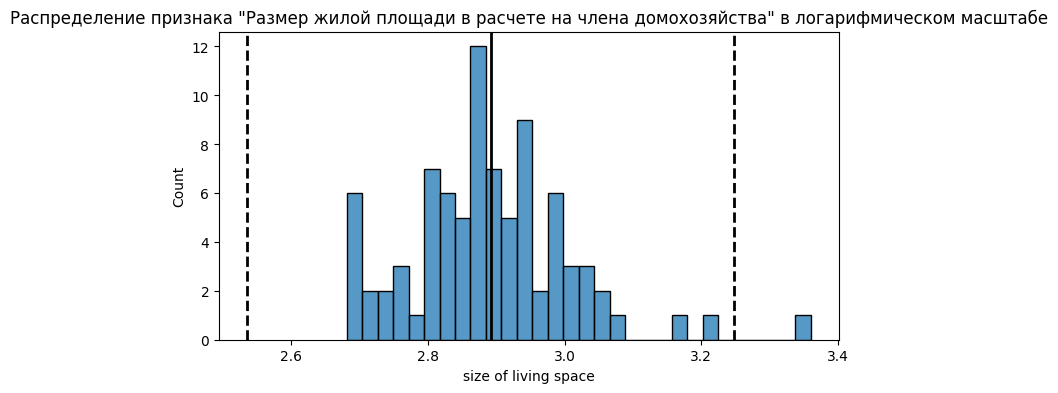

In [1836]:
#построим график распределения признака "size of living space"
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_data = np.log(data['size of living space'] + 1)
histplot = sns.histplot(log_data, bins=30, ax=ax)
histplot.axvline(log_data.mean(), color='k', lw=2)
histplot.axvline(log_data.mean()+ 3 * log_data.std(), color='k', ls='--', lw=2)
histplot.axvline(log_data.mean()- 3 * log_data.std(), color='k', ls='--', lw=2)
histplot.set_title('Распределение признака "Размер жилой площади в расчете на члена домохозяйства" в логарифмическом масштабе');
#fig.savefig("data/hist_size of living space.png")

Распределение не нормальное.

In [1837]:
# проверим на выбросы
outliers = outliers_z_score_mod(data, 'size of living space', log_scale=True, left=3, right=4)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')

Число выбросов по методу z-отклонения: 0


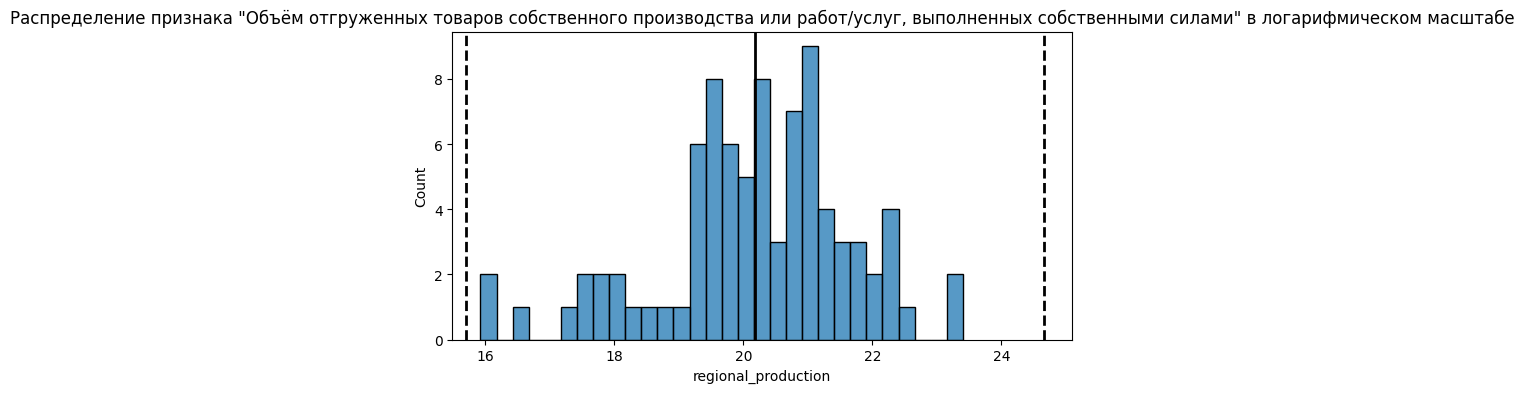

In [1838]:
#построим график распределения признака "regional_production"
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_data = np.log(data['regional_production'] + 1)
histplot = sns.histplot(log_data, bins=30, ax=ax)
histplot.axvline(log_data.mean(), color='k', lw=2)
histplot.axvline(log_data.mean()+ 3 * log_data.std(), color='k', ls='--', lw=2)
histplot.axvline(log_data.mean()- 3 * log_data.std(), color='k', ls='--', lw=2)
histplot.set_title(
    'Распределение признака "Объём отгруженных товаров собственного производства или работ/услуг, выполненных собственными силами" в логарифмическом масштабе');
#fig.savefig("data/hist_regional_production.png")

Выбросов не наблюдаем. Распределение не нормальное.

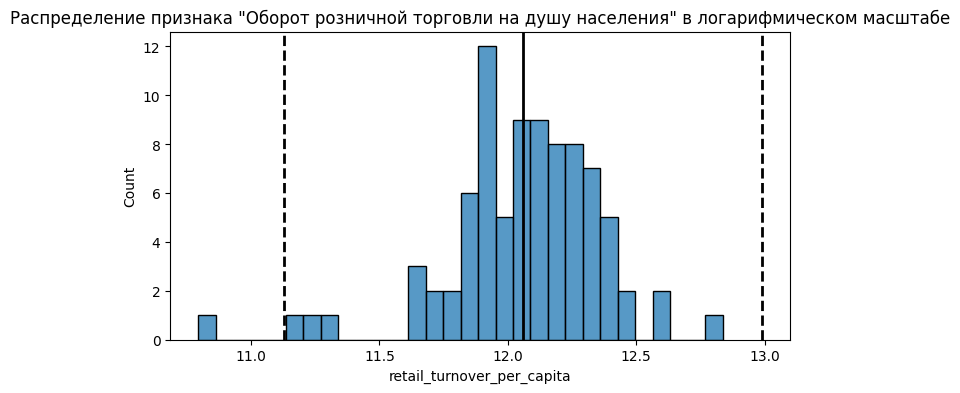

In [1839]:
#построим график распределения признака retail_turnover_per_capita
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_data = np.log(data['retail_turnover_per_capita'] + 1)
histplot = sns.histplot(log_data, bins=30, ax=ax)
histplot.axvline(log_data.mean(), color='k', lw=2)
histplot.axvline(log_data.mean()+ 3 * log_data.std(), color='k', ls='--', lw=2)
histplot.axvline(log_data.mean()- 3 * log_data.std(), color='k', ls='--', lw=2)
histplot.set_title('Распределение признака "Оборот розничной торговли на душу населения" в логарифмическом масштабе');
#fig.savefig("data/hist_retail_turnover_per_capita.png")

Распределение не нормальное.

In [1840]:
# проверим на выбросы
outliers = outliers_z_score_mod(data, 'retail_turnover_per_capita', log_scale=True, left=3, right=4)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
outliers

Число выбросов по методу z-отклонения: 1


child_mortality  disabled_total_by_age  \
Республика Ингушетия        64.666667               647907.0   

                      morbidity_age_disease_17  morbidity_age_disease_18  \
Республика Ингушетия                 202754.35                  43533.05   

                      poverty_percent_by_regions  welfare_expense_share  \
Республика Ингушетия                       29.95                   25.8   

                      cash_real_income_wages  Number of children  Pensioners  \
Республика Ингушетия            16064.166667                39.8        9.25   

                      Working-age population  ...  population  \
Республика Ингушетия                  50.925  ...    484940.0   

                      gross_regional_product  regional_production  \
Республика Ингушетия                129910.5            9098626.3   

                      retail_turnover_per_capita  minors  group of people  \
Республика Ингушетия                48744.833333    25.0             85.0   

                      criminal community  drug  alco  newborn_monthly  
Республика Ингушетия                 2.4  1.95   0.1         8195.665  

[1 rows x 27 columns]

Оборот розничной торговли на душу населения меньше всего в Республике Ингушетия.

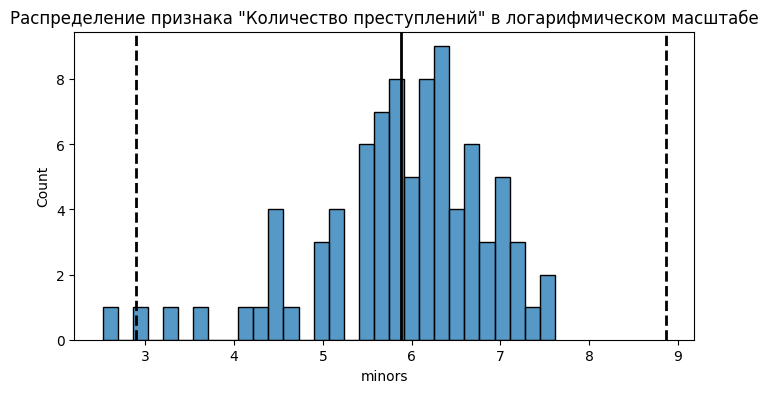

In [1841]:
#построим график распределения признака minors
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_data = np.log(data['minors'] + 1)
histplot = sns.histplot(log_data, bins=30, ax=ax)
histplot.axvline(log_data.mean(), color='k', lw=2)
histplot.axvline(log_data.mean()+ 3 * log_data.std(), color='k', ls='--', lw=2)
histplot.axvline(log_data.mean()- 3 * log_data.std(), color='k', ls='--', lw=2)
histplot.set_title('Распределение признака "Количество преступлений" в логарифмическом масштабе');
#fig.savefig("data/hist_minors.png")

Распределение не нормальное.

In [1842]:
# проверим на выбросы
outliers = outliers_z_score_mod(data, 'minors', log_scale=True, left=3, right=4)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
outliers

Число выбросов по методу z-отклонения: 1


child_mortality  disabled_total_by_age  \
Чеченская Республика       253.166667             1881876.25   

                      morbidity_age_disease_17  morbidity_age_disease_18  \
Чеченская Республика                  112481.4                   55920.9   

                      poverty_percent_by_regions  welfare_expense_share  \
Чеченская Республика                   19.266667              27.316667   

                      cash_real_income_wages  Number of children  Pensioners  \
Чеченская Республика                 23330.5              46.025        6.65   

                      Working-age population  ...    population  \
Чеченская Республика                  47.325  ...  1.425327e+06   

                      gross_regional_product  regional_production  \
Чеченская Республика           149513.866667         5.869030e+07   

                      retail_turnover_per_capita  minors  group of people  \
Чеченская Республика               114256.333333    11.4             91.0   

                      criminal community  drug  alco  newborn_monthly  
Чеченская Республика                 0.0   0.7  3.55         29996.48  

[1 rows x 27 columns]

В Чеченской республике меньше всего преступлений.

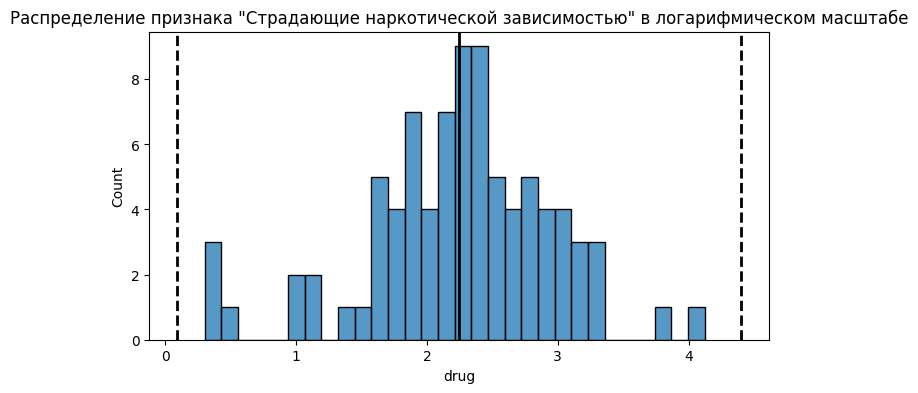

In [1843]:
#построим график распределения признака drug
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_data = np.log(data['drug'] + 1)
histplot = sns.histplot(log_data, bins=30, ax=ax)
histplot.axvline(log_data.mean(), color='k', lw=2)
histplot.axvline(log_data.mean()+ 3 * log_data.std(), color='k', ls='--', lw=2)
histplot.axvline(log_data.mean()- 3 * log_data.std(), color='k', ls='--', lw=2)
histplot.set_title('Распределение признака "Страдающие наркотической зависимостью" в логарифмическом масштабе');
#fig.savefig("data/hist_drug.png")

Выбросов не наблюдаем. Распределение не нормальное.

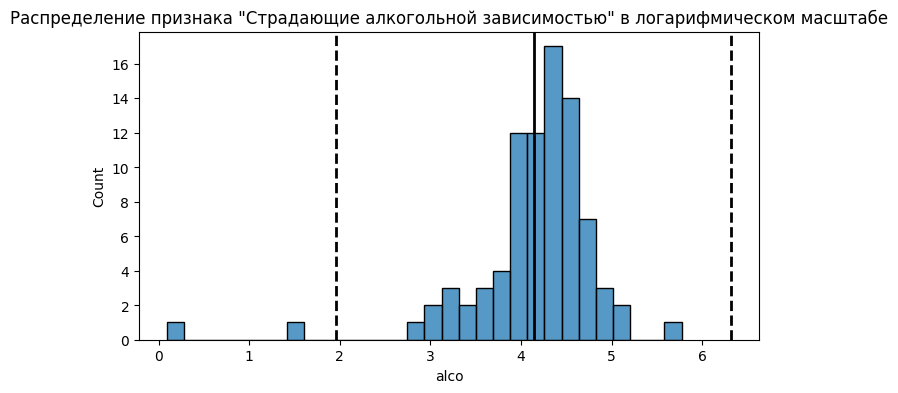

In [1844]:
#построим график распределения признака alco
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_data = np.log(data['alco'] + 1)
histplot = sns.histplot(log_data, bins=30, ax=ax)
histplot.axvline(log_data.mean(), color='k', lw=2)
histplot.axvline(log_data.mean()+ 3 * log_data.std(), color='k', ls='--', lw=2)
histplot.axvline(log_data.mean()- 3 * log_data.std(), color='k', ls='--', lw=2)
histplot.set_title('Распределение признака "Страдающие алкогольной зависимостью" в логарифмическом масштабе');
#fig.savefig("data/hist_alco.png")

Распределение не нормальное.

In [1845]:
# проверим на выбросы
outliers = outliers_z_score_mod(data, 'alco', log_scale=True, left=3, right=4)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
outliers

Число выбросов по методу z-отклонения: 2


child_mortality  disabled_total_by_age  \
Чеченская Республика       253.166667             1881876.25   
Республика Ингушетия        64.666667              647907.00   

                      morbidity_age_disease_17  morbidity_age_disease_18  \
Чеченская Республика                 112481.40                  55920.90   
Республика Ингушетия                 202754.35                  43533.05   

                      poverty_percent_by_regions  welfare_expense_share  \
Чеченская Республика                   19.266667              27.316667   
Республика Ингушетия                   29.950000              25.800000   

                      cash_real_income_wages  Number of children  Pensioners  \
Чеченская Республика            23330.500000              46.025        6.65   
Республика Ингушетия            16064.166667              39.800        9.25   

                      Working-age population  ...    population  \
Чеченская Республика                  47.325  ...  1.425327e+06   
Республика Ингушетия                  50.925  ...  4.849400e+05   

                      gross_regional_product  regional_production  \
Чеченская Республика           149513.866667         5.869030e+07   
Республика Ингушетия           129910.500000         9.098626e+06   

                      retail_turnover_per_capita  minors  group of people  \
Чеченская Республика               114256.333333    11.4             91.0   
Республика Ингушетия                48744.833333    25.0             85.0   

                      criminal community  drug  alco  newborn_monthly  
Чеченская Республика                 0.0  0.70  3.55        29996.480  
Республика Ингушетия                 2.4  1.95  0.10         8195.665  

[2 rows x 27 columns]

В республиках Ингушения и Чеченская меньше всего людей, страдающий алкогольной зависимотью.

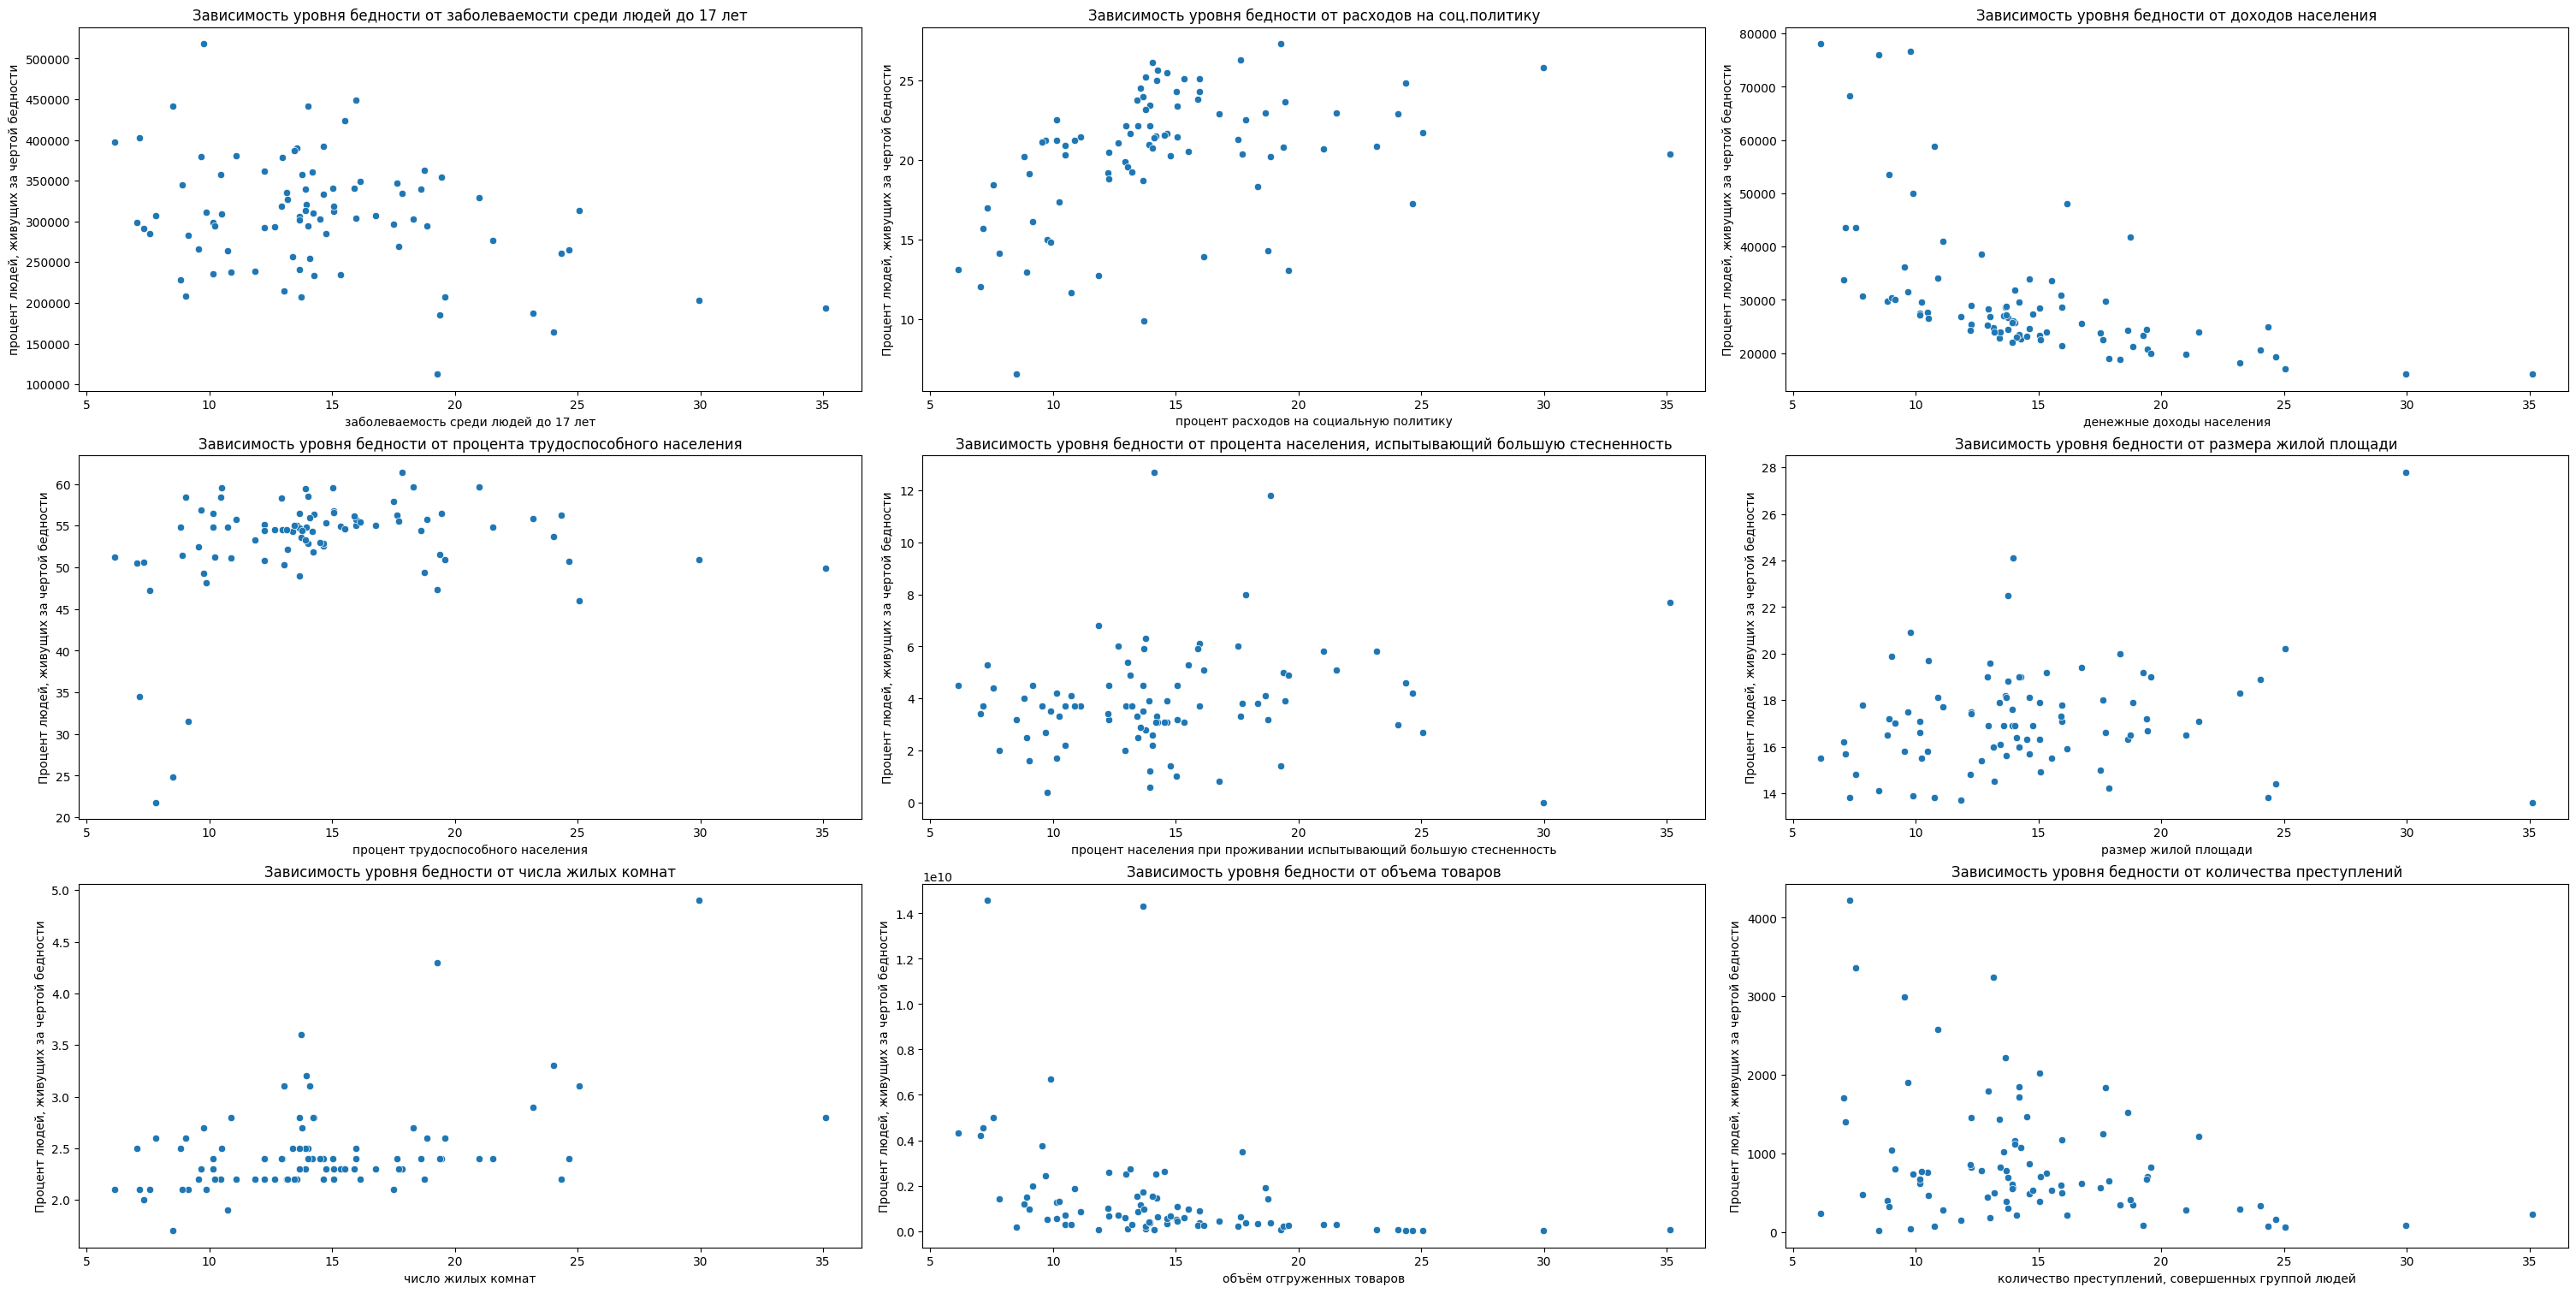

In [1846]:
# посмотрим на распределение признаков в зависимости от уровня бедности
fig, axes = plt.subplots(3, 3, layout='constrained', figsize=(30, 15))

sns.scatterplot(data=data, x='poverty_percent_by_regions', y='morbidity_age_disease_17', ax=axes[0, 0])
axes[0, 0].set(ylabel='процент людей, живущих за чертой бедности',xlabel='заболеваемость среди людей до 17 лет')
axes[0, 0].set_title('Зависимость уровня бедности от заболеваемости среди людей до 17 лет')

sns.scatterplot(data=data, x='poverty_percent_by_regions', y='welfare_expense_share', ax=axes[0, 1])
axes[0, 1].set(ylabel='Процент людей, живущих за чертой бедности',xlabel='процент расходов на социальную политику')
axes[0, 1].set_title('Зависимость уровня бедности от расходов на соц.политику')

sns.scatterplot(data=data, x='poverty_percent_by_regions', y='cash_real_income_wages', ax=axes[0, 2])
axes[0, 2].set(ylabel='Процент людей, живущих за чертой бедности', xlabel='денежные доходы населения')
axes[0, 2].set_title('Зависимость уровня бедности от доходов населения')

sns.scatterplot(data=data, x='poverty_percent_by_regions', y='Working-age population', ax=axes[1, 0])
axes[1, 0].set(ylabel='Процент людей, живущих за чертой бедности',xlabel='процент трудоспособного населения')
axes[1, 0].set_title('Зависимость уровня бедности от процента трудоспособного населения')

sns.scatterplot(data=data, x='poverty_percent_by_regions', y='experience great discomfort while living', ax=axes[1, 1])
axes[1, 1].set(ylabel='Процент людей, живущих за чертой бедности',xlabel='процент населения при проживании испытывающий большую стесненность')
axes[1, 1].set_title('Зависимость уровня бедности от процента населения, испытывающий большую стесненность')

sns.scatterplot(data=data, x='poverty_percent_by_regions', y='size of living space', ax=axes[1, 2])
axes[1, 2].set(ylabel='Процент людей, живущих за чертой бедности',xlabel='размер жилой площади')
axes[1, 2].set_title('Зависимость уровня бедности от размера жилой площади')

sns.scatterplot(data=data, x='poverty_percent_by_regions', y='number of rooms', ax=axes[2, 0])
axes[2, 0].set(ylabel='Процент людей, живущих за чертой бедности',xlabel='число жилых комнат')
axes[2, 0].set_title('Зависимость уровня бедности от числа жилых комнат')

sns.scatterplot(data=data, x='poverty_percent_by_regions', y='regional_production', ax=axes[2, 1])
axes[2, 1].set(ylabel='Процент людей, живущих за чертой бедности',xlabel='объём отгруженных товаров')
axes[2, 1].set_title('Зависимость уровня бедности от объема товаров')

sns.scatterplot(data=data, x='poverty_percent_by_regions', y='group of people', ax=axes[2, 2])
axes[2, 2].set(ylabel='Процент людей, живущих за чертой бедности',xlabel='количество преступлений, совершенных группой людей')
axes[2, 2].set_title('Зависимость уровня бедности от количества преступлений')

plt.show();
#fig.savefig("data/Зависимость уровня бедности от других признаков.png")

По визуализации можем наблюдать некую зависимость для процента расходов на соц.политику и доходов населения.

In [1847]:
# проверим распределение числовых признаков на нормальность с помощью теста Шапиро—Уилка
# задаём уровень значимости
alpha = 0.05 

for col in data.columns:
    _, p = stats.shapiro(data[col])
    
    print(f'{col}:   p-value = {p:.3f}')
    # интерпретируем результат
    if p <= alpha:
        print('Распределение не нормальное')
    else:
        print('Распределение нормальное')

child_mortality:   p-value = 0.000
Распределение не нормальное
disabled_total_by_age:   p-value = 0.000
Распределение не нормальное
morbidity_age_disease_17:   p-value = 0.746
Распределение нормальное
morbidity_age_disease_18:   p-value = 0.149
Распределение нормальное
poverty_percent_by_regions:   p-value = 0.000
Распределение не нормальное
welfare_expense_share:   p-value = 0.000
Распределение не нормальное
cash_real_income_wages:   p-value = 0.000
Распределение не нормальное
Number of children:   p-value = 0.000
Распределение не нормальное
Pensioners:   p-value = 0.237
Распределение нормальное
Working-age population:   p-value = 0.000
Распределение не нормальное
do not feel constrained when living:   p-value = 0.105
Распределение нормальное
feel uncomfortable while living:   p-value = 0.123
Распределение нормальное
experience great discomfort while living:   p-value = 0.000
Распределение не нормальное
did not answer:   p-value = 0.000
Распределение не нормальное
total area size:   p

Тест Шапиро на нормальность распределения показывает, что только признаки "morbidity_age_disease_17", "morbidity_age_disease_18", "Pensioners", "do not feel constrained when living", "feel uncomfortable while living".

In [1848]:
# объединим некоторые признаки
data['crimes'] = data['group of people'] + data['minors'] + data['criminal community']
data['morbidity_age_disease'] = data['morbidity_age_disease_17'] + data['morbidity_age_disease_18']
data['drug+alco'] = data['drug'] + data['alco']

In [1849]:
# удалим часть признаков
data.drop(columns=['total area size', 'experience great discomfort while living',  
                   'do not feel constrained when living', 'did not answer',
                   'group of people', 'minors', 'criminal community',
                   'morbidity_age_disease_17', 'morbidity_age_disease_18',
                   'drug', 'alco', 'number of rooms'], axis=1, inplace=True) 

Так как признаки распределены не нормально, то проверим корреляцию Спирмена.

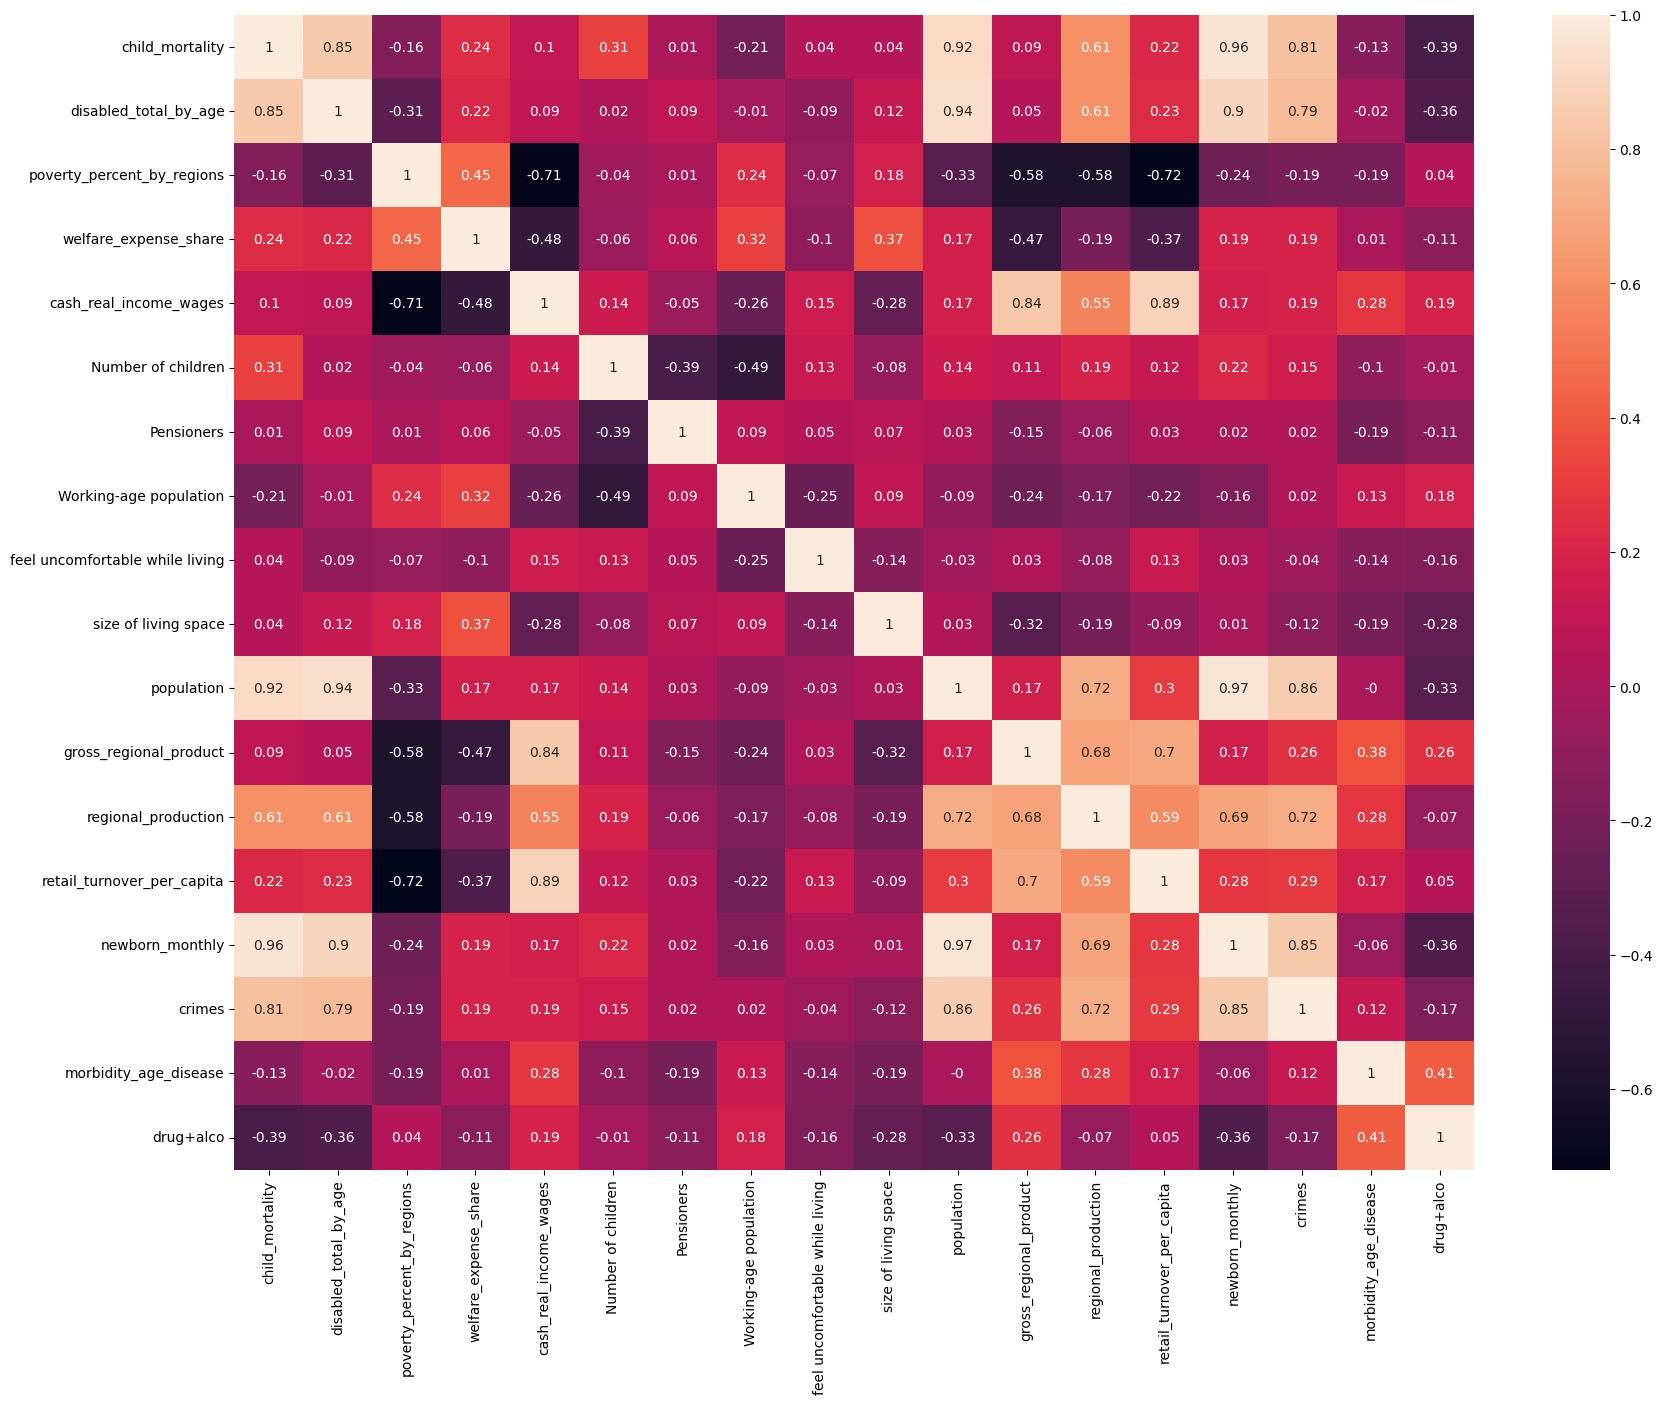

In [1850]:
# посмотрим тепловую карту
plt.figure(figsize=(20, 15))
sns.heatmap(data.corr(method='spearman').round(decimals=2), annot=True)
plt.show()
#fig.savefig("data/heatmap.png")

* Детская смертность коррелирует с количеством инвалидов, количеством населения, количеством преступлений и с рождаемостью.
* Количество инвалидов коррелирует с детской смертностью, с рождаемостью, количеством населения и количеством преступлений.
* Процент людей, живущих за чертой бедности имеет сильную обратную корреляцию с денежными доходами населения (что логично), а также с оборотом розничной торговли на душу населения.
* Денежные доходы населения имеют сильную обратную корреляцию с процентом людей, живущих за чертой бедности, а также сильную корреляцию с валовым региональным продуктом и оборотом розничной торговли на душу населения (логично, чем больше доходы населения, тем больше они могут тратить).
* ВРП сильно коррелирует с количеством населения и количеством преступлений.
* Оборот розничной торговли коррелирует с валовым региональным продуктом на душу населения.
* Объём отгруженных товаров собственного производства или работ/услуг, выполненных собственными силами коррелирует с количеством преступлений, количеством населения и доходами населения.
* Количество рожденных коррелирует с количеством преступлений.

Сформируем и проверим гипотезы

In [1851]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

### Процент детей и пенсионеров больше, чем процент трудоспособного населения влияет на процент уровня бедности

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: процент уровеня бедности для регионов с процентом пенсионеров и детей выше, чем процент трудоспосбного населения статистически больше либо равен проценту уровня бедности для регионов, где трудоспосбного населения больше, чем пенсионеров и детей: регионы, где процент детей и пенсионеров больше или равен, чем процент трудоспособного населения ($μ_1$), регионы, где процент пенсионеров и детей меньше процента трудоспосбного населения($μ_2$).

$$ H_0 : μ_1 >= μ_2$$

*Альтернативная гипотеза*: процент уровеня бедности для регионов с процентом пенсионеров и детей выше, чем процент трудоспосбного населения статистически меньше процента уровня бедности для регионов, где трудоспосбного населения больше, чем пенсионеров и детей: регионы, где процент детей и пенсионеров больше или равен, чем процент трудоспособного населени ($μ_1$), регионы, где процент пенсионеров и детей меньше процента трудоспосбного населения($μ_2$).

$$ H_1 : μ_1 < μ_2$$


**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [1852]:
# вводим доп.колонку - процент пенсионеров выше или ниже, чем процент
# трудоспосбного населения
data['pensioners_over'] = (data['Pensioners'] + data['Number of children']) >= data['Working-age population']

# соберем данные для теста
percent_high = data[data['pensioners_over']==True]['poverty_percent_by_regions']
percent_lower = data[data['pensioners_over']==False]['poverty_percent_by_regions']

# проводим тест Шапиро-Уилка
print('Для большого количетсва пенсионеров и детей:')
result = stats.shapiro(percent_high)
decision_normality(result[1])

print('Для небольшого количества пенсионеров и детей:')
result = stats.shapiro(percent_lower)
decision_normality(result[1])

Для большого количетсва пенсионеров и детей:
p-value = 0.012
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для небольшого количества пенсионеров и детей:
p-value = 0.003
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Процент уровная бедности»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

**Проведём тест**

In [1853]:
# проводим тест
_, p = stats.mannwhitneyu(percent_high, percent_lower, alternative='less')
decision_hypothesis(p)

p-value = 0.150
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Процент уровеня бедности для регионов с процентом пенсионеров и детей выше, чем процент трудоспосбного населения больше либо равен проценту уровня бедности для регионов, где трудоспосбного населения больше, чем пенсионеров и детей.

### Количество инвалидов влияет на процент уровня бедности

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: процент уровня бедности для регионов, где процент инвалидов больше 60% статистически больше либо равен проценту уровня бедности для регионов, где инвалидов менее или равно 60%: регионы, где инвалидов белее 60% ($μ_1$), регионы, где процент инвалидов более 60% ($μ_2$).

$$ H_0 : μ_1 >= μ_2$$

*Альтернативная гипотеза*: процент уровня бедности для регионов, где процент инвалидов больше 60% статистически меньше процента уровня бедности для регионов, где инвалидов менее или равно 60%: регионы, где инвалидов белее 60% ($μ_1$), регионы, где процент инвалидов более 60% ($μ_2$).

$$ H_1 : μ_1 < μ_2$$

In [1854]:
# посчитаем процент инвалидов от общего количества населения
# (приблизительный расчет, 
# т.к. данные за периоды разные и в итоге работаем со средними значениями)
data['percent_disabled'] = (data['disabled_total_by_age'] * 100) / data['population']

In [1855]:
# соберем данные для теста
percent_disabled_high = data[data['percent_disabled']>60]['poverty_percent_by_regions']
percent_disabled_lower = data[data['percent_disabled']<=60]['poverty_percent_by_regions']

# проводим тест Шапиро-Уилка
print('Для большого количества инвалидов:')
result = stats.shapiro(percent_disabled_high)
decision_normality(result[1])

print('Для небольшого количества инвалидов:')
result = stats.shapiro(percent_disabled_lower)
decision_normality(result[1])

Для большого количества инвалидов:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для небольшого количества инвалидов:
p-value = 0.919
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Процент уровная бедности»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

**Проведём тест**

In [1856]:
# проводим тест
_, p = stats.mannwhitneyu(percent_disabled_high, percent_disabled_lower, alternative='less')
decision_hypothesis(p)

p-value = 0.993
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Процент уровня бедности, где большое количество инвалидов, выше или равен проценту уровня бедности, где инвалидов не так много.

In [1857]:
# посчитаем отношение количества преступлений к численности населения
data['crimes_norm'] = data['crimes'] / data['population'] *100 # количество преступлений на одного человека

Примем, что количество преступления на одного человека более 0,1 это высокая преступность в регионе.

### Высокая преступность в регионе влияет на процент уровня бедности

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: процент уровня бедности для регионов, где высокая преступность статистически больше либо равен проценту уровня бедности для регионов, где преступность низкая: регионы, где высокая преступность ($μ_1$), регионы, где низкая преступность ($μ_2$).

$$ H_0 : μ_1 >= μ_2$$

*Альтернативная гипотеза*: процент уровня бедности для регионов, где высокая преступность статистически меньше процента уровня бедности для регионов, где преступность низкая: регионы, где высокая преступность ($μ_1$), регионы, где низкая преступность ($μ_2$).

$$ H_1 : μ_1 < μ_2$$

In [1858]:
# соберем данные для теста
crimes_norm_high = data[data['crimes_norm']>=0.1]['poverty_percent_by_regions']
crimes_norm_lower = data[data['crimes_norm']<0.1]['poverty_percent_by_regions']

# проводим тест Шапиро-Уилка
print('Высокая преступность:')
result = stats.shapiro(crimes_norm_high)
decision_normality(result[1])

print('Низкая преступность:')
result = stats.shapiro(crimes_norm_lower)
decision_normality(result[1])

Высокая преступность:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Низкая преступность:
p-value = 0.003
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Процент уровная бедности»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

**Проведём тест**

In [1859]:
# проводим тест
_, p = stats.mannwhitneyu(crimes_norm_high, crimes_norm_lower, alternative='less')
decision_hypothesis(p)

p-value = 0.984
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Высокая преступность влияет на процент уровня бедности в регионе.

In [1860]:
# посчитаем отношение ВРП к численности населения
data['gross_regional_product_norm'] = data['gross_regional_product'] / data['population'] * 100

### Валовый региональный продукт влияет на процент уровня бедности

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: процент уровня бедности для регионов, где низкий ВРП (примем, что отношение ВРП к численности населения менее 100) статистически больше либо равен проценту уровня бедности для регионов, где высокий ВРП: регионы, где низкий ВРП ($μ_1$), регионы, где высокий ВРП ($μ_2$).

$$ H_0 : μ_1 >= μ_2$$

*Альтернативная гипотеза*: процент уровня бедности для регионов, где низкий ВРП статистически меньше процента уровня бедности для регионов, где ВРП низкий: регионы, где низкий ВРП ($μ_1$), регионы, где высокий ВРП ($μ_2$).

$$ H_1 : μ_1 < μ_2$$

In [1861]:
# соберем данные для теста
gross_regional_product_norm_lower = data[data['gross_regional_product_norm']<100]['poverty_percent_by_regions']
gross_regional_product_norm_high = data[data['gross_regional_product_norm']>=100]['poverty_percent_by_regions']

# проводим тест Шапиро-Уилка
print('Низкий ВРП:')
result = stats.shapiro(gross_regional_product_norm_lower)
decision_normality(result[1])

print('Высокий ВРП:')
result = stats.shapiro(gross_regional_product_norm_high)
decision_normality(result[1])

Низкий ВРП:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Высокий ВРП:
p-value = 0.044
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Процент уровная бедности»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

**Проведём тест**

In [1862]:
# проводим тест
_, p = stats.mannwhitneyu(gross_regional_product_norm_lower, gross_regional_product_norm_high, alternative='less')
decision_hypothesis(p)

p-value = 0.636
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

ВРП влияет на процент уровня бедности в регионе, больше ВРП - меньше процент бедности.

### Расходы на соц.политику влияют на процент уровня бедности

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: процент уровня бедности для регионов, где маленький процент расходов на соц.политику (примем, что высокий процент расходов это более 20), статистически больше либо равен проценту уровня бедности для регионов, где высокие расходы на соц.политику: регионы, где низкие расходы на соц.политику ($μ_1$), регионы, где высокие расходы на соц.политику ($μ_2$).

$$ H_0 : μ_1 >= μ_2$$

*Альтернативная гипотеза*: процент уровня бедности для регионов, где высокие расходы на соц.политику, статистически меньше процента уровня бедности для регионов, где низкие расходы на соц.политику: регионы, где низкие расходы на соц.политику ($μ_1$), регионы, где высокие расходы на соц.политику ($μ_2$).

$$ H_1 : μ_1 < μ_2$$

In [1863]:
# соберем данные для теста
welfare_expense_share_lower = data[data['welfare_expense_share']<20]['poverty_percent_by_regions']
welfare_expense_share_high = data[data['welfare_expense_share']>=20]['poverty_percent_by_regions']

# проводим тест Шапиро-Уилка
print('Низкие расходы на соц.политику:')
result = stats.shapiro(welfare_expense_share_lower)
decision_normality(result[1])

print('Высокие расходы на соц.политику:')
result = stats.shapiro(welfare_expense_share_high)
decision_normality(result[1])

Низкие расходы на соц.политику:
p-value = 0.017
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Высокие расходы на соц.политику:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Процент уровная бедности»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

**Проведём тест**

In [1864]:
# проводим тест
_, p = stats.mannwhitneyu(welfare_expense_share_lower, welfare_expense_share_high, alternative='less')
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Процент уровня бедности для регионов, где высокие расходы на соц.политику, меньше процента уровня бедности для регионов, где низкие расходы на соц.политику.

In [1865]:
# удалим вспомогательные признаки
data.drop(columns=['pensioners_over', 'percent_disabled', 
                   'crimes_norm', 'gross_regional_product_norm'], 
          axis=1, inplace=True) 

In [1866]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, Чеченская Республика to Чукотский автономный округ
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   child_mortality                  85 non-null     float64
 1   disabled_total_by_age            85 non-null     float64
 2   poverty_percent_by_regions       85 non-null     float64
 3   welfare_expense_share            85 non-null     float64
 4   cash_real_income_wages           85 non-null     float64
 5   Number of children               85 non-null     float64
 6   Pensioners                       85 non-null     float64
 7   Working-age population           85 non-null     float64
 8   feel uncomfortable while living  85 non-null     float64
 9   size of living space             85 non-null     float64
 10  population                       85 non-null     float64
 11  gross_regional_product           85 non-null    

В датафрейме 18 признаков.

Удалять признаки не будем, далее используем метод понижения размерности и уже потом будем выполнять кластеризацию - снижение размерности может убрать лишние сильно скоррелированные признаки у наблюдений и подготовить данные для дальнейшей обработки.

## Часть 2. Моделирование и оценка качества моделей

### 2.1. Кластеризация

Чтобы результаты кластеризации было удобнее интерпретировать, уменьшим размерность исходных признаков до двух компонент. За базовую модель примем KMeans.

In [1867]:
models = []  # список моделей
clusters = []  # количество кластеров для каждой модели
silhouette = [] # список коэффициентов силуэта
calinski_harabasz = [] # список коэффициентов Калински-Харабаса
davies_bouldin = [] # список коэффициентов Дэвиса-Болдина
# не знаем истинную кластеризацию, сравним разные модели с базовой
rand = [] # список индексов Рэнда (мера сходства между двумя кластеризациями данных) 
clusters_sizes = [] # размеры кластеров

In [1868]:
def add_list_metrics(data, labels, model, num_cluster, cluster_size, baseline_labels):    
    # рассчитываем коэффициенты
    silhouette_coef = metrics.silhouette_score(data, labels)  
    calinski_harabasz_coef = metrics.calinski_harabasz_score(data, labels)  
    davies_bouldin_coef = metrics.davies_bouldin_score(data, labels)
    index_rand = metrics.adjusted_rand_score(baseline_labels, labels)
    
    # добавляем значения в списки
    silhouette.append(silhouette_coef)
    calinski_harabasz.append(calinski_harabasz_coef)
    davies_bouldin.append(davies_bouldin_coef)
    models.append(model)
    rand.append(index_rand)
    clusters.append(num_cluster)
    clusters_sizes.append(cluster_size)
    
    # выводим значения коэффициентов
    print('Silhouette: {:.3f}'.format(metrics.silhouette_score(data, labels)))
    print('Calinski-Harabatz: {:.3f}'.format(metrics.calinski_harabasz_score(data, labels)))
    print('Davis-Bouldin: {:.3f}'.format(metrics.davies_bouldin_score(data, labels)))
    print('Индекс Рэнда (сравнение с базовой моделью): %.3f' % index_rand)
    print('Размеры кластеров: ', cluster_size)

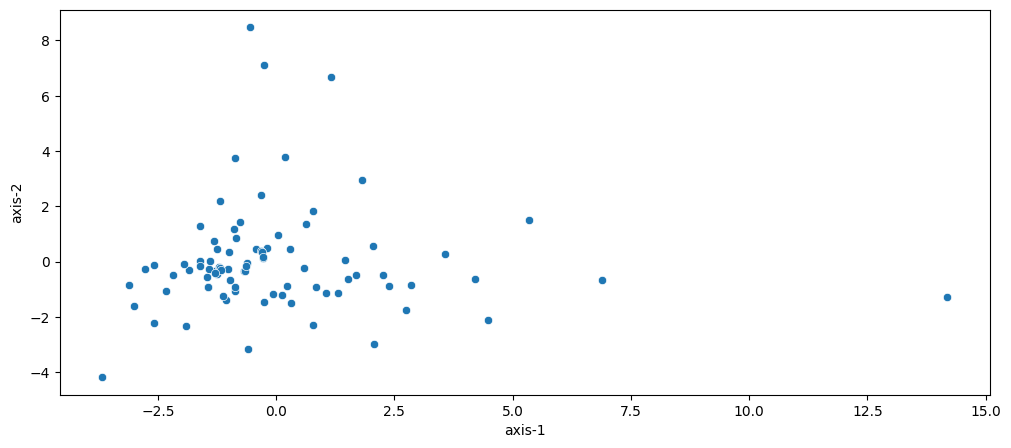

In [1869]:
# чтобы методы понижения размерности работали стабильно, данные необходимо стандартизировать/нормализовать
scaler = StandardScaler() 
#scaler = MinMaxScaler() # при нормализации количество кластеров увеличивалось, но коэффициент Калински-Харабаса выше

# применяем PCA для понижения размерности
pca = PCA(n_components=2, random_state=RANDOM_SEED)
pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca)])
data_processed = pipe.fit_transform(data)
data_processed = pd.DataFrame(data_processed, columns=['axis-1', 'axis-2'])

fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=data_processed, x='axis-1', y='axis-2');

Визуально не видим разделения на кластеры.

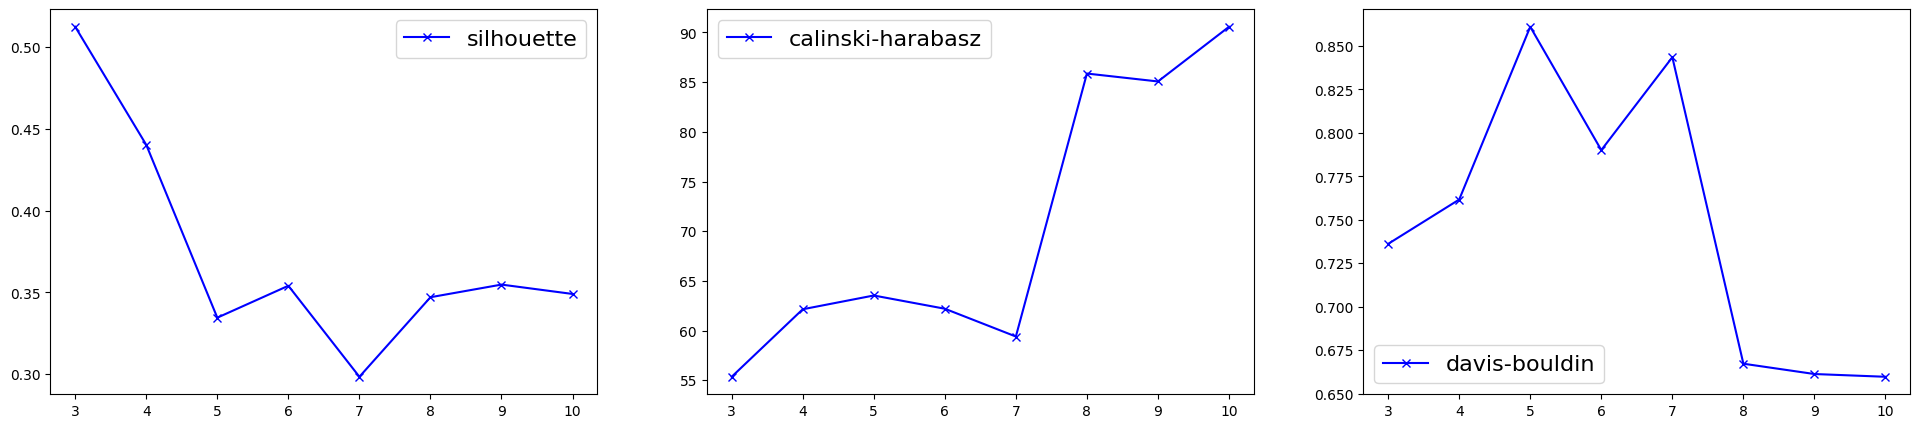

In [1870]:
#узнаем оптимальное количество кластеров для метода KMeans
def get_metrics(cluster_num, X):
    k_means =  KMeans(n_clusters=cluster_num, random_state=RANDOM_SEED)
    k_means.fit(X)
    silhouette_element = metrics.silhouette_score(X, k_means.labels_, metric='euclidean') 
    calinski_harabasz_element = metrics.calinski_harabasz_score(X, k_means.labels_)  
    davis_bouldin_element = metrics.davies_bouldin_score(X, k_means.labels_) 
    
    return silhouette_element, calinski_harabasz_element, davis_bouldin_element

silhouettes_list = []
calinski_harabasz_list = []
davis_bouldin_list = []
#перебираем количество от 3 до 10 включительно
for i in range(3, 11):
    silhouette_element, calinski_harabasz_element, davis_bouldin_element = get_metrics(i, data_processed)
    silhouettes_list.append(silhouette_element)
    calinski_harabasz_list.append(calinski_harabasz_element)
    davis_bouldin_list.append(davis_bouldin_element)
    
# строим графики для выбранных метрик для выбора количества кластеров   
fig, ax = plt.subplots(1, 3, figsize=(24,5))
    
ax[0].plot(range(3, 11), silhouettes_list, 'xb-', label='silhouette')
ax[1].plot(range(3, 11), calinski_harabasz_list, 'xb-', label='calinski-harabasz')
ax[2].plot(range(3, 11), davis_bouldin_list, 'xb-', label='davis-bouldin')
ax[0].legend(prop={'size': 16})
ax[1].legend(prop={'size': 16})
ax[2].legend(prop={'size': 16})

Коэффициент силуэта указывает на 3 кластера. Коэффициент Калински-Харабаса указывает на оптимальное колличество кластеров равное 10, коэффициент Дэвиса-Болдина - на 10 кластеров. Примем значение числа кластеров равное 10.

<Axes: xlabel='axis-1', ylabel='axis-2'>

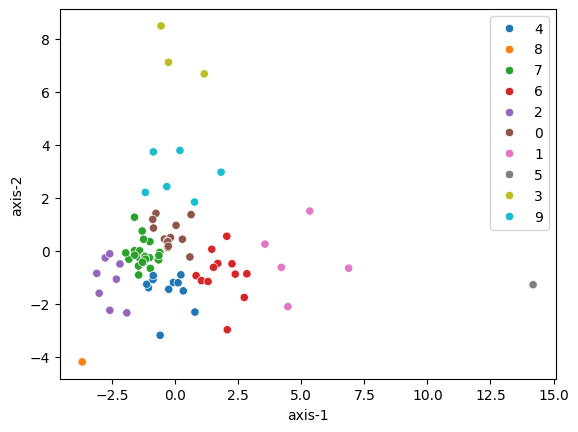

In [1871]:
# оптимальное количество кластеров=10, строим базовую модель
model_KMeans = KMeans(n_clusters=10, random_state=RANDOM_SEED)
model_KMeans.fit(data_processed)

#рисуем график
sns.scatterplot(data=data_processed, x='axis-1', y='axis-2', hue=model_KMeans.labels_.astype('str'))

In [1872]:
# запоминаем базовую модель
baseline = model_KMeans

# рассчитываем и запоминаем метрики
add_list_metrics(data_processed, model_KMeans.labels_, 
                 model_KMeans, len(set(model_KMeans.labels_)), 
                 np.bincount(model_KMeans.labels_), baseline.labels_)

Silhouette: 0.349
Calinski-Harabatz: 90.574
Davis-Bouldin: 0.660
Индекс Рэнда (сравнение с базовой моделью): 1.000
Размеры кластеров:  [13  5  8  3 11  1 12 25  1  6]


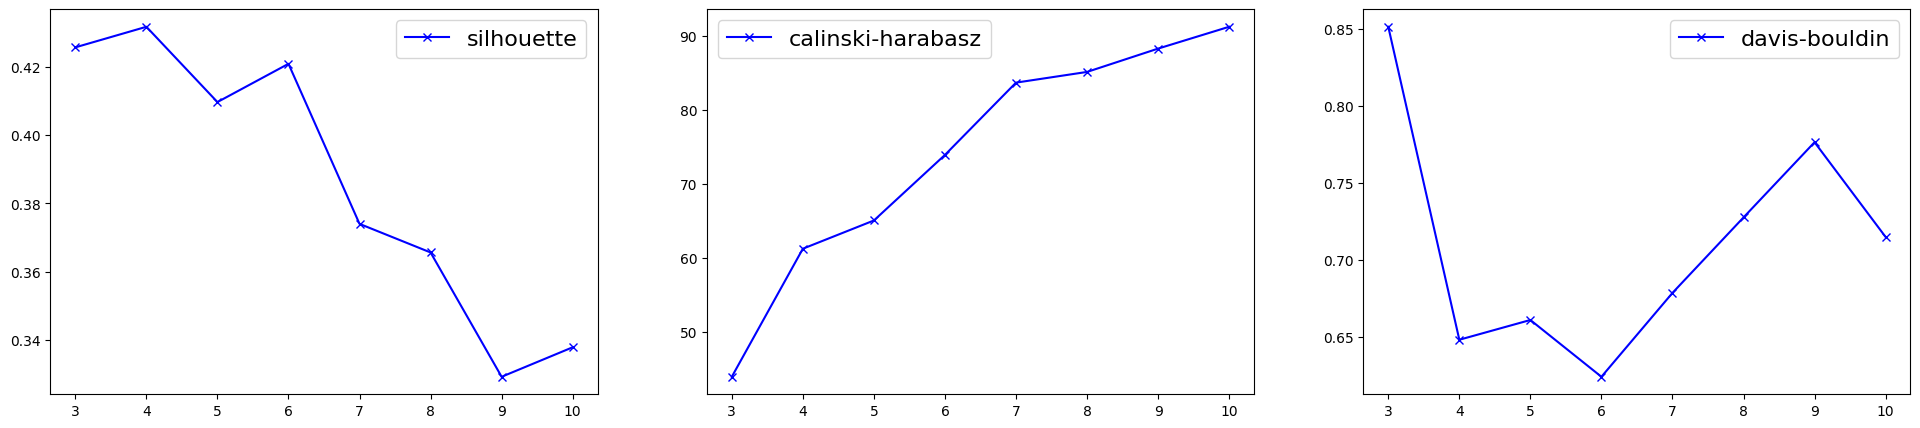

In [1873]:
#узнаем оптимальное количество кластеров для метода AgglomerativeClustering
def get_metrics(cluster_num, X):
    agglomerative_clustering =  AgglomerativeClustering(n_clusters=cluster_num)
    agglomerative_clustering.fit(X)
    silhouette_element = metrics.silhouette_score(X, agglomerative_clustering.labels_, metric='euclidean') 
    calinski_harabasz_element = metrics.calinski_harabasz_score(X, agglomerative_clustering.labels_)  
    davis_bouldin_element = metrics.davies_bouldin_score(X, agglomerative_clustering.labels_) 
    
    return silhouette_element, calinski_harabasz_element, davis_bouldin_element

silhouettes_list = []
calinski_harabasz_list = []
davis_bouldin_list = []
#перебираем количество от 3 до 10 включительно
for i in range(3, 11):
    silhouette_element, calinski_harabasz_element, davis_bouldin_element = get_metrics(i, data_processed)
    silhouettes_list.append(silhouette_element)
    calinski_harabasz_list.append(calinski_harabasz_element)
    davis_bouldin_list.append(davis_bouldin_element)
    
# строим графики для выбранных метрик для выбора количества кластеров   
fig, ax = plt.subplots(1, 3, figsize=(24,5))
    
ax[0].plot(range(3, 11), silhouettes_list, 'xb-', label='silhouette')
ax[1].plot(range(3, 11), calinski_harabasz_list, 'xb-', label='calinski-harabasz')
ax[2].plot(range(3, 11), davis_bouldin_list, 'xb-', label='davis-bouldin')
ax[0].legend(prop={'size': 16})
ax[1].legend(prop={'size': 16})
ax[2].legend(prop={'size': 16})

Коэффициент силуэта указывает на 4 кластера. Коэффициент Калински-Харабаса указывает на оптимальное колличество кластеров равное 10, коэффициент Дэвиса-Болдина - на 6 кластеров. Примем значение числа кластеров равное 6.

<Axes: xlabel='axis-1', ylabel='axis-2'>

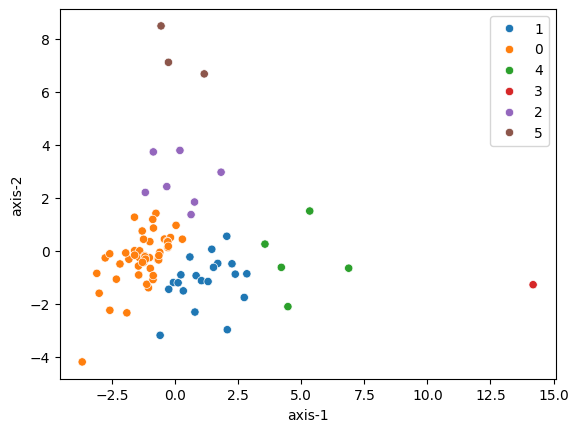

In [1874]:
# оптимальное количество кластеров=6, строим модель
model_agglomerative = AgglomerativeClustering(n_clusters=6)
model_agglomerative.fit(data_processed)

#посмотрим на график
sns.scatterplot(data=data_processed, x='axis-1', y='axis-2', hue=model_agglomerative.labels_.astype('str'))

In [1875]:
# рассчитываем и запоминаем метрики
add_list_metrics(data_processed, model_agglomerative.labels_, 
                 model_KMeans, len(set(model_agglomerative.labels_)), 
                 np.bincount(model_agglomerative.labels_), baseline.labels_)

Silhouette: 0.421
Calinski-Harabatz: 73.888
Davis-Bouldin: 0.624
Индекс Рэнда (сравнение с базовой моделью): 0.377
Размеры кластеров:  [49 20  7  1  5  3]


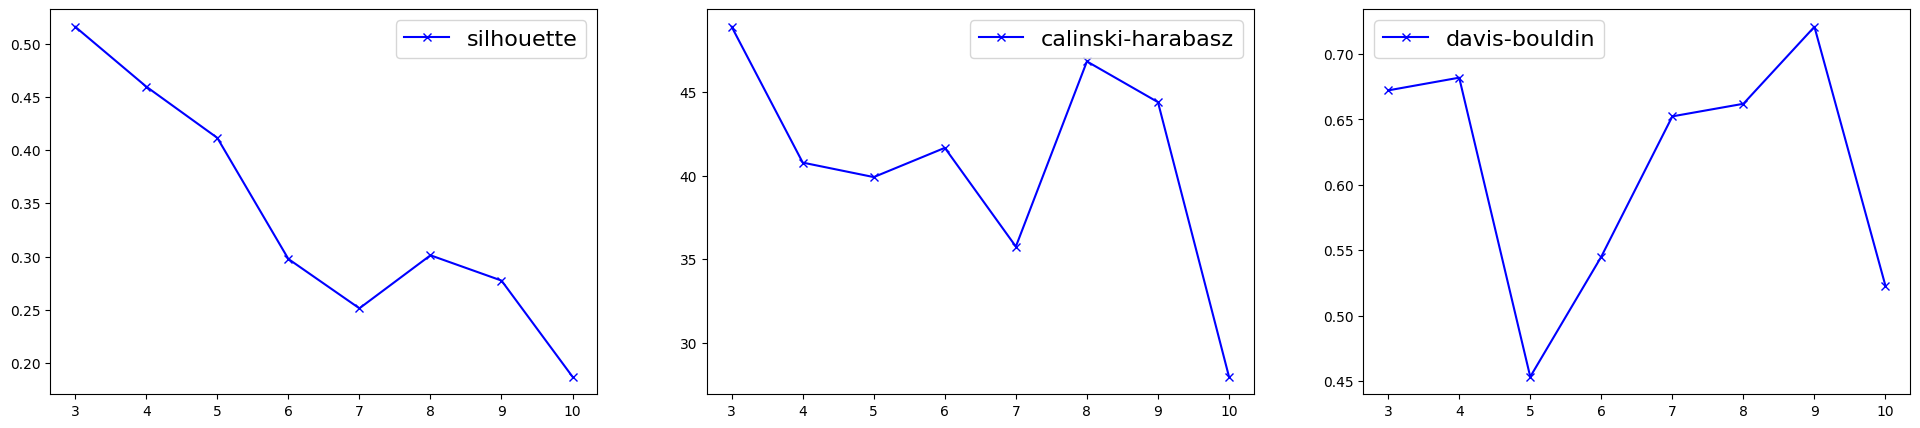

In [1876]:
#узнаем оптимальное количество кластеров для метода SpectralClustering
def get_metrics(cluster_num, X):
    spectral_clustering =  SpectralClustering(n_clusters=cluster_num, random_state=RANDOM_SEED)
    spectral_clustering.fit(X)
    silhouette_element = metrics.silhouette_score(X, spectral_clustering.labels_, metric='euclidean') 
    calinski_harabasz_element = metrics.calinski_harabasz_score(X, spectral_clustering.labels_)  
    davis_bouldin_element = metrics.davies_bouldin_score(X, spectral_clustering.labels_) 
    
    return silhouette_element, calinski_harabasz_element, davis_bouldin_element

silhouettes_list = []
calinski_harabasz_list = []
davis_bouldin_list = []
#перебираем количество от 3 до 10 включительно
for i in range(3, 11):
    silhouette_element, calinski_harabasz_element, davis_bouldin_element = get_metrics(i, data_processed)
    silhouettes_list.append(silhouette_element)
    calinski_harabasz_list.append(calinski_harabasz_element)
    davis_bouldin_list.append(davis_bouldin_element)
    
# строим графики для выбранных метрик для выбора количества кластеров   
fig, ax = plt.subplots(1, 3, figsize=(24,5))
    
ax[0].plot(range(3, 11), silhouettes_list, 'xb-', label='silhouette')
ax[1].plot(range(3, 11), calinski_harabasz_list, 'xb-', label='calinski-harabasz')
ax[2].plot(range(3, 11), davis_bouldin_list, 'xb-', label='davis-bouldin')
ax[0].legend(prop={'size': 16})
ax[1].legend(prop={'size': 16})
ax[2].legend(prop={'size': 16})

Коэффициент силуэта указывает на 3 кластера. Коэффициент Калински-Харабаса указывает на оптимальное колличество кластеров равное 3, коэффициент Дэвиса-Болдина на 9 кластеров. Примем значение числа кластеров равное 3.

<Axes: xlabel='axis-1', ylabel='axis-2'>

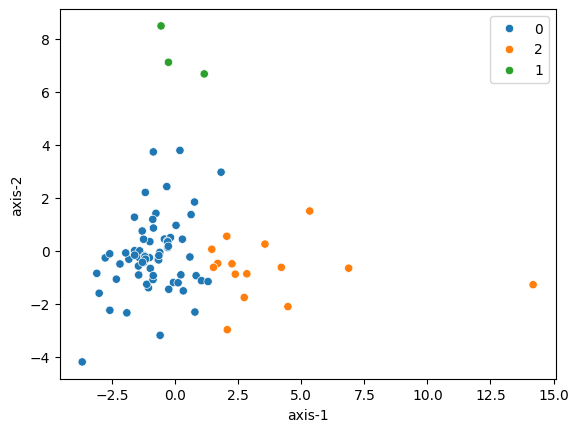

In [1877]:
# оптимальное количество кластеров=3, строим модель
spectral_clustering = SpectralClustering(n_clusters=3)
spectral_clustering.fit(data_processed)

# рисуем график
sns.scatterplot(data=data_processed, x='axis-1', y='axis-2', hue=spectral_clustering.labels_.astype('str'))

In [1878]:
# рассчитываем и запоминаем метрики
add_list_metrics(data_processed, spectral_clustering.labels_, 
                 model_KMeans, len(set(spectral_clustering.labels_)), 
                 np.bincount(spectral_clustering.labels_), baseline.labels_)

Silhouette: 0.516
Calinski-Harabatz: 48.915
Davis-Bouldin: 0.672
Индекс Рэнда (сравнение с базовой моделью): 0.156
Размеры кластеров:  [67  3 15]


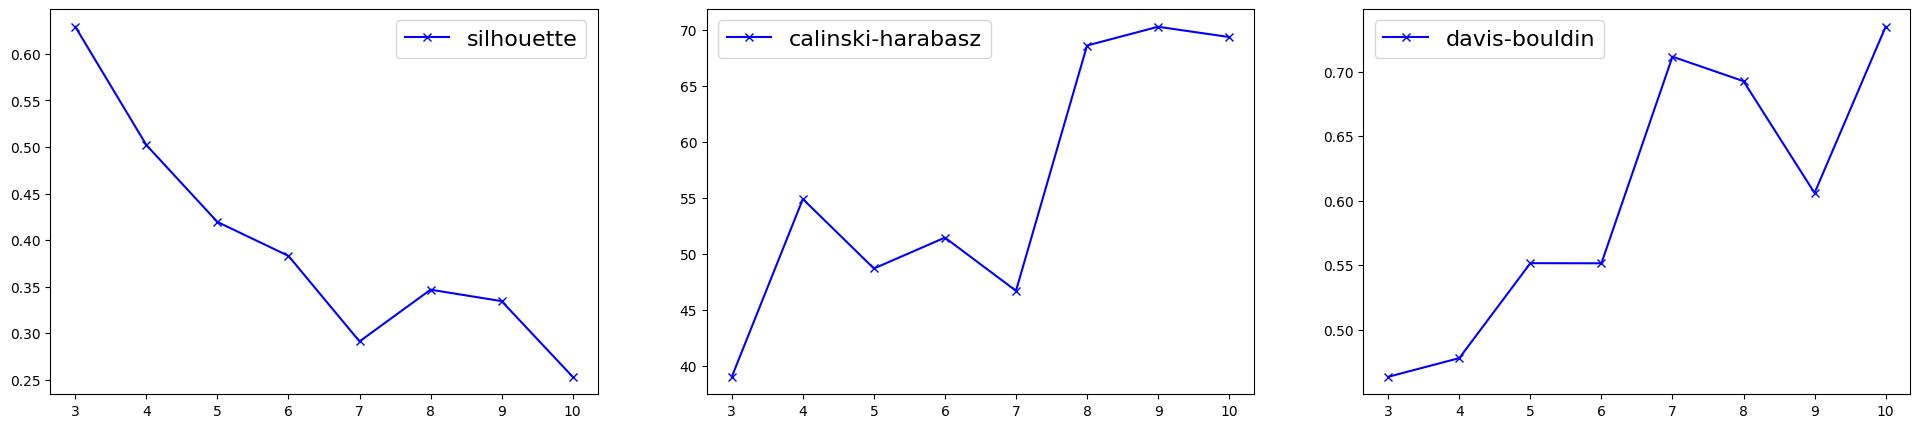

In [1879]:
#узнаем оптимальное количество кластеров для метода GaussianMixture
def get_metrics(cluster_num, X):
    gm_clustering =  GaussianMixture(n_components=cluster_num, random_state=RANDOM_SEED, covariance_type='tied')
    silhouette_element = metrics.silhouette_score(X, gm_clustering.fit_predict(X), metric='euclidean') 
    calinski_harabasz_element = metrics.calinski_harabasz_score(X, gm_clustering.fit_predict(X))  
    davis_bouldin_element = metrics.davies_bouldin_score(X, gm_clustering.fit_predict(X)) 
    
    return silhouette_element, calinski_harabasz_element, davis_bouldin_element

silhouettes_list = []
calinski_harabasz_list = []
davis_bouldin_list = []
#перебираем количество от 3 до 10 включительно
for i in range(3, 11):
    silhouette_element, calinski_harabasz_element, davis_bouldin_element = get_metrics(i, data_processed)
    silhouettes_list.append(silhouette_element)
    calinski_harabasz_list.append(calinski_harabasz_element)
    davis_bouldin_list.append(davis_bouldin_element)
    
# строим графики для выбранных метрик для выбора количества кластеров   
fig, ax = plt.subplots(1, 3, figsize=(24,5))
    
ax[0].plot(range(3, 11), silhouettes_list, 'xb-', label='silhouette')
ax[1].plot(range(3, 11), calinski_harabasz_list, 'xb-', label='calinski-harabasz')
ax[2].plot(range(3, 11), davis_bouldin_list, 'xb-', label='davis-bouldin')
ax[0].legend(prop={'size': 16})
ax[1].legend(prop={'size': 16})
ax[2].legend(prop={'size': 16})

Коэффициент силуэта указывает на 3 кластера. Коэффициент Калински-Харабаса указывает на оптимальное колличество кластеров равное 9, коэффициент Дэвиса-Болдина - на 3 кластера. Примем значение числа кластеров равное 3.

<Axes: xlabel='axis-1', ylabel='axis-2'>

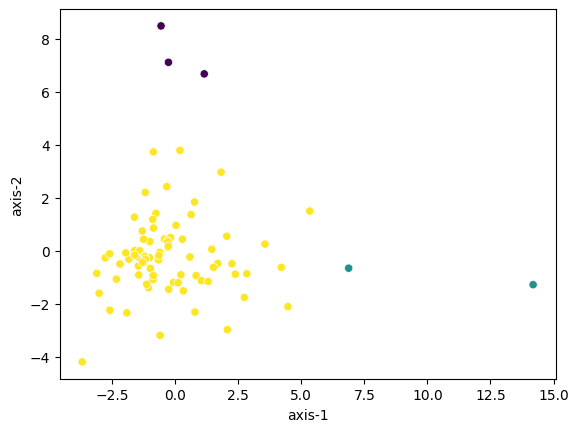

In [1880]:
# оптимальное количество кластеров=3, строим модель
gm_clustering = GaussianMixture(n_components=3, random_state=RANDOM_SEED, covariance_type='tied')
gm_clustering.fit(data_processed)
gm_prediction = gm_clustering.predict(data_processed)

#рисуем график
sns.scatterplot(x=data_processed['axis-1'], y=data_processed['axis-2'], c=gm_prediction)

In [1881]:
# рассчитываем и запоминаем метрики
add_list_metrics(data_processed, gm_prediction, 
                 gm_prediction, len(set(gm_prediction)), 
                 np.bincount(gm_prediction), baseline.labels_)

Silhouette: 0.629
Calinski-Harabatz: 39.008
Davis-Bouldin: 0.464
Индекс Рэнда (сравнение с базовой моделью): 0.043
Размеры кластеров:  [ 3  2 80]


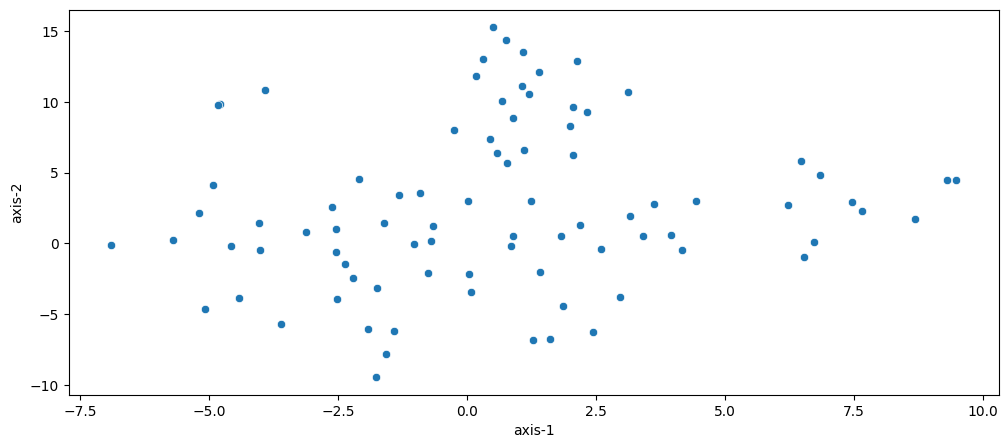

In [1882]:
# применим другой метод понижения размерности - TSNE
t_sne = TSNE(n_components=2, perplexity=17, random_state=RANDOM_SEED)
pipe = Pipeline(steps=[('scaler', scaler), ('t_sne', t_sne)])
data_processed = pipe.fit_transform(data)
data_processed = pd.DataFrame(data_processed, columns=['axis-1', 'axis-2'])

fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=data_processed, x='axis-1', y='axis-2');

Тут уже можно выделить некое разделение, при уменьшении perplexity происходит лучше деление на группы, но тогда и количество кластеров увеличивается, что усложняет задачу описания кластеров.

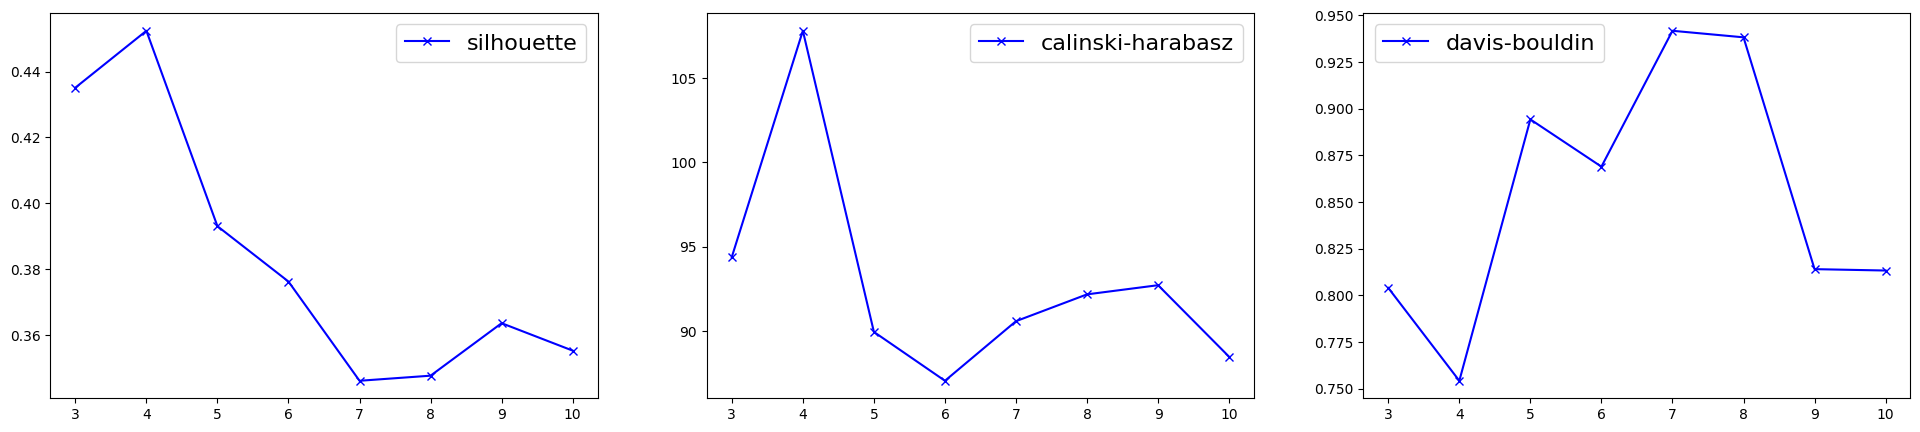

In [1883]:
#узнаем оптимальное количество кластеров для метода KMeans
def get_metrics(cluster_num, X):
    k_means =  KMeans(n_clusters=cluster_num, random_state=RANDOM_SEED)
    k_means.fit(X)
    silhouette_element = metrics.silhouette_score(X, k_means.labels_, metric='euclidean') 
    calinski_harabasz_element = metrics.calinski_harabasz_score(X, k_means.labels_)  
    davis_bouldin_element = metrics.davies_bouldin_score(X, k_means.labels_) 
    
    return silhouette_element, calinski_harabasz_element, davis_bouldin_element

silhouettes_list = []
calinski_harabasz_list = []
davis_bouldin_list = []
#перебираем количество от 3 до 10 включительно
for i in range(3, 11):
    silhouette_element, calinski_harabasz_element, davis_bouldin_element = get_metrics(i, data_processed)
    silhouettes_list.append(silhouette_element)
    calinski_harabasz_list.append(calinski_harabasz_element)
    davis_bouldin_list.append(davis_bouldin_element)
    
# строим графики для выбранных метрик для выбора количества кластеров   
fig, ax = plt.subplots(1, 3, figsize=(24,5))
    
ax[0].plot(range(3, 11), silhouettes_list, 'xb-', label='silhouette')
ax[1].plot(range(3, 11), calinski_harabasz_list, 'xb-', label='calinski-harabasz')
ax[2].plot(range(3, 11), davis_bouldin_list, 'xb-', label='davis-bouldin')
ax[0].legend(prop={'size': 16})
ax[1].legend(prop={'size': 16})
ax[2].legend(prop={'size': 16})

Коэффициент силуэта указывает на 4 кластера. Коэффициент Калински-Харабаса указывает на оптимальное колличество кластеров равное 4, коэффициент Дэвиса-Болдина - на 4 кластеров. Примем значение числа кластеров равное 4.

<Axes: xlabel='axis-1', ylabel='axis-2'>

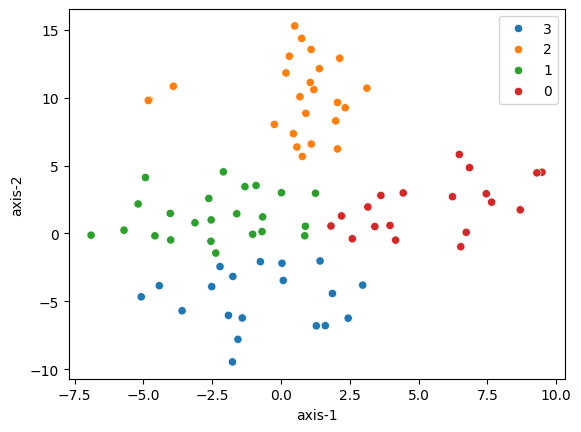

In [1884]:
# оптимальное количество кластеров=4, строим модель
model_KMeans = KMeans(n_clusters=4, random_state=RANDOM_SEED)
model_KMeans.fit(data_processed)

#рисуем график
sns.scatterplot(data=data_processed, x='axis-1', y='axis-2', hue=model_KMeans.labels_.astype('str'))

In [1885]:
# рассчитываем и запоминаем метрики
add_list_metrics(data_processed, model_KMeans.labels_, model_KMeans,
                 len(set(model_KMeans.labels_)), 
                 np.bincount(model_KMeans.labels_), baseline.labels_)

Silhouette: 0.452
Calinski-Harabatz: 107.797
Davis-Bouldin: 0.754
Индекс Рэнда (сравнение с базовой моделью): 0.223
Размеры кластеров:  [19 23 24 19]


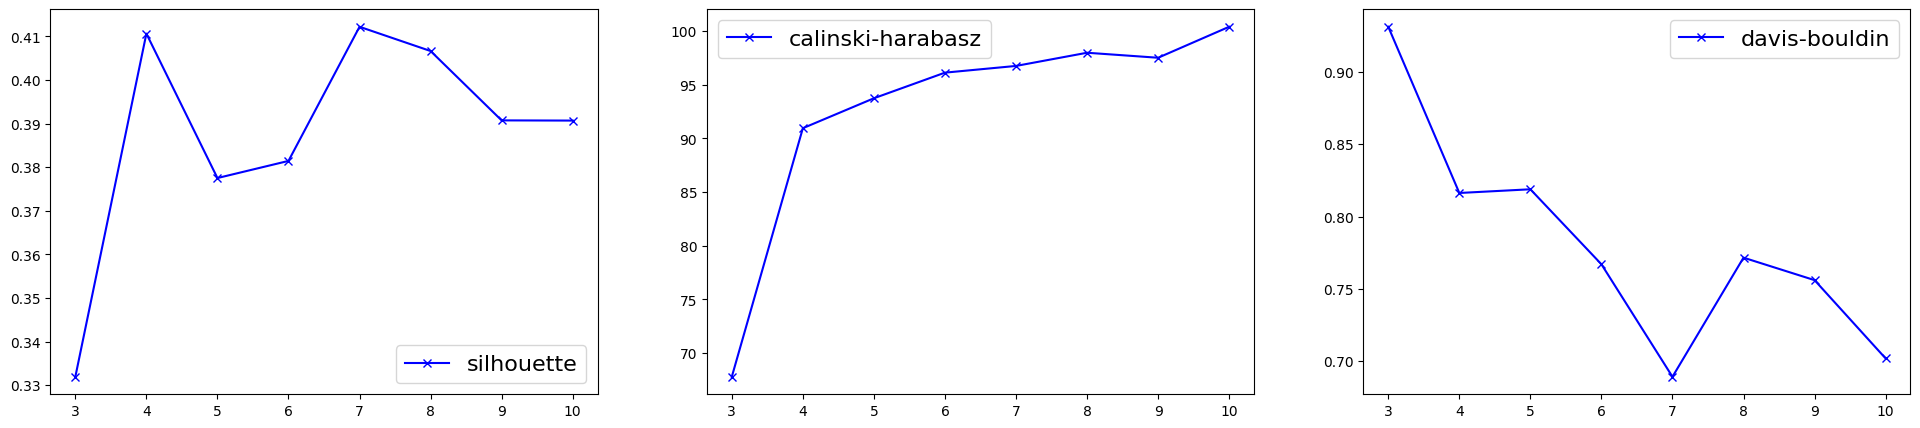

In [1886]:
#узнаем оптимальное количество кластеров для метода AgglomerativeClustering
def get_metrics(cluster_num, X):
    agglomerative_clustering =  AgglomerativeClustering(n_clusters=cluster_num)
    agglomerative_clustering.fit(X)
    silhouette_element = metrics.silhouette_score(X, agglomerative_clustering.labels_, metric='euclidean') 
    calinski_harabasz_element = metrics.calinski_harabasz_score(X, agglomerative_clustering.labels_)  
    davis_bouldin_element = metrics.davies_bouldin_score(X, agglomerative_clustering.labels_) 
    
    return silhouette_element, calinski_harabasz_element, davis_bouldin_element

silhouettes_list = []
calinski_harabasz_list = []
davis_bouldin_list = []
#перебираем количество от 3 до 10 включительно
for i in range(3, 11):
    silhouette_element, calinski_harabasz_element, davis_bouldin_element = get_metrics(i, data_processed)
    silhouettes_list.append(silhouette_element)
    calinski_harabasz_list.append(calinski_harabasz_element)
    davis_bouldin_list.append(davis_bouldin_element)
    
# строим графики для выбранных метрик для выбора количества кластеров   
fig, ax = plt.subplots(1, 3, figsize=(24,5))
    
ax[0].plot(range(3, 11), silhouettes_list, 'xb-', label='silhouette')
ax[1].plot(range(3, 11), calinski_harabasz_list, 'xb-', label='calinski-harabasz')
ax[2].plot(range(3, 11), davis_bouldin_list, 'xb-', label='davis-bouldin')
ax[0].legend(prop={'size': 16})
ax[1].legend(prop={'size': 16})
ax[2].legend(prop={'size': 16})

Коэффициент силуэта указывает на 4 или 7 кластеров. Коэффициент Калински-Харабаса указывает на оптимальное колличество кластеров равное 10, коэффициент Дэвиса-Болдина - на 7 кластеров. Примем значение числа кластеров равное 7.

<Axes: xlabel='axis-1', ylabel='axis-2'>

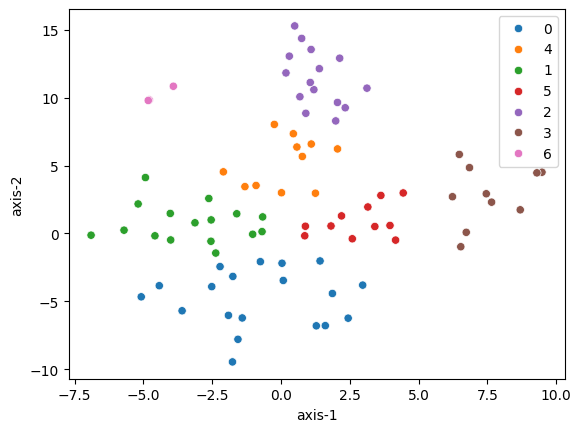

In [1887]:
# оптимальное количество кластеров = 7, строим модель
agglomerative_clustering = AgglomerativeClustering(n_clusters=7)
agglomerative_clustering.fit(data_processed)

#рисуем график
sns.scatterplot(data=data_processed, x='axis-1', y='axis-2', hue=agglomerative_clustering.labels_.astype('str'))

In [1888]:
# рассчитываем и запоминаем метрики
add_list_metrics(data_processed, agglomerative_clustering.labels_, 
                 agglomerative_clustering,
                 len(set(agglomerative_clustering.labels_)), 
                 np.bincount(agglomerative_clustering.labels_), baseline.labels_)

Silhouette: 0.412
Calinski-Harabatz: 96.743
Davis-Bouldin: 0.689
Индекс Рэнда (сравнение с базовой моделью): 0.305
Размеры кластеров:  [19 16 15 10 11 11  3]


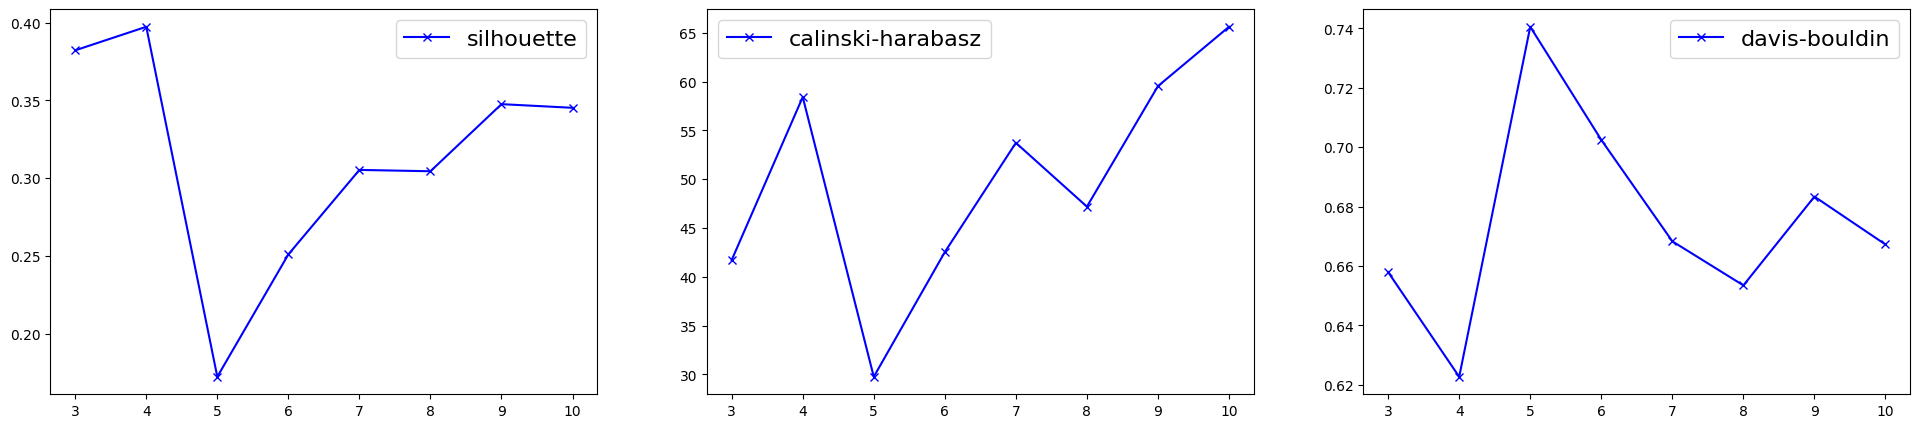

In [1889]:
#узнаем оптимальное количество кластеров для метода SpectralClustering
def get_metrics(cluster_num, X):
    spectral_clustering =  SpectralClustering(n_clusters=cluster_num, random_state=RANDOM_SEED)
    spectral_clustering.fit(X)
    silhouette_element = metrics.silhouette_score(X, spectral_clustering.labels_, metric='euclidean') 
    calinski_harabasz_element = metrics.calinski_harabasz_score(X, spectral_clustering.labels_)  
    davis_bouldin_element = metrics.davies_bouldin_score(X, spectral_clustering.labels_) 
    
    return silhouette_element, calinski_harabasz_element, davis_bouldin_element

silhouettes_list = []
calinski_harabasz_list = []
davis_bouldin_list = []
#перебираем количество от 3 до 10 включительно
for i in range(3, 11):
    silhouette_element, calinski_harabasz_element, davis_bouldin_element = get_metrics(i, data_processed)
    silhouettes_list.append(silhouette_element)
    calinski_harabasz_list.append(calinski_harabasz_element)
    davis_bouldin_list.append(davis_bouldin_element)
    
# строим графики для выбранных метрик для выбора количества кластеров   
fig, ax = plt.subplots(1, 3, figsize=(24,5))
    
ax[0].plot(range(3, 11), silhouettes_list, 'xb-', label='silhouette')
ax[1].plot(range(3, 11), calinski_harabasz_list, 'xb-', label='calinski-harabasz')
ax[2].plot(range(3, 11), davis_bouldin_list, 'xb-', label='davis-bouldin')
ax[0].legend(prop={'size': 16})
ax[1].legend(prop={'size': 16})
ax[2].legend(prop={'size': 16})

Коэффициент силуэта указывает на 4 кластера. Коэффициент Калински-Харабаса указывает на оптимальное колличество кластеров равное 10, коэффициент Дэвиса-Болдина - на 4 кластеров. Примем значение числа кластеров равное 4.

<Axes: xlabel='axis-1', ylabel='axis-2'>

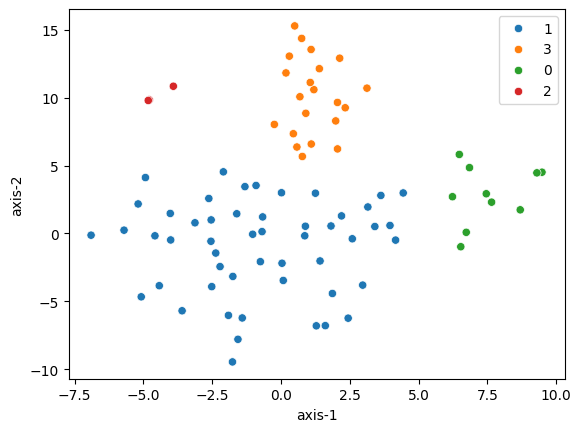

In [1890]:
# оптимальное количество кластеров=4, строим модель
spectral_clustering = SpectralClustering(n_clusters=4, random_state=RANDOM_SEED)
spectral_clustering.fit(data_processed)

#рисуем график
sns.scatterplot(data=data_processed, x='axis-1', y='axis-2', hue=spectral_clustering.labels_.astype('str'))

In [1891]:
# рассчитываем и запоминаем метрики
add_list_metrics(data_processed, spectral_clustering.labels_, spectral_clustering,
                 len(set(spectral_clustering.labels_)), 
                 np.bincount(spectral_clustering.labels_), baseline.labels_)

Silhouette: 0.397
Calinski-Harabatz: 58.423
Davis-Bouldin: 0.623
Индекс Рэнда (сравнение с базовой моделью): 0.274
Размеры кластеров:  [10 51  3 21]


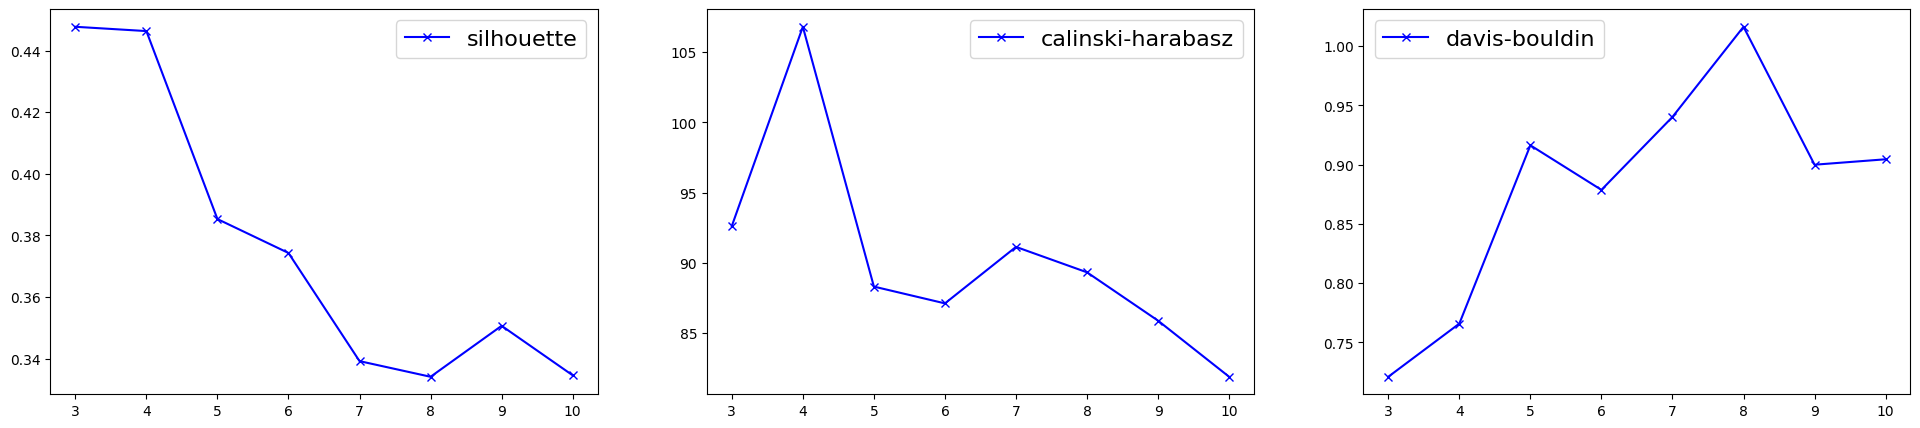

In [1892]:
#узнаем оптимальное количество кластеров для метода GaussianMixture
def get_metrics(cluster_num, X):
    gm_clustering =  GaussianMixture(n_components=cluster_num, random_state=RANDOM_SEED, covariance_type='tied')
    silhouette_element = metrics.silhouette_score(X, gm_clustering.fit_predict(X), metric='euclidean') 
    calinski_harabasz_element = metrics.calinski_harabasz_score(X, gm_clustering.fit_predict(X))  
    davis_bouldin_element = metrics.davies_bouldin_score(X, gm_clustering.fit_predict(X)) 
    
    return silhouette_element, calinski_harabasz_element, davis_bouldin_element

silhouettes_list = []
calinski_harabasz_list = []
davis_bouldin_list = []
#перебираем количество от 3 до 10 включительно
for i in range(3, 11):
    silhouette_element, calinski_harabasz_element, davis_bouldin_element = get_metrics(i, data_processed)
    silhouettes_list.append(silhouette_element)
    calinski_harabasz_list.append(calinski_harabasz_element)
    davis_bouldin_list.append(davis_bouldin_element)
    
# строим графики для выбранных метрик для выбора количества кластеров   
fig, ax = plt.subplots(1, 3, figsize=(24,5))
    
ax[0].plot(range(3, 11), silhouettes_list, 'xb-', label='silhouette')
ax[1].plot(range(3, 11), calinski_harabasz_list, 'xb-', label='calinski-harabasz')
ax[2].plot(range(3, 11), davis_bouldin_list, 'xb-', label='davis-bouldin')
ax[0].legend(prop={'size': 16})
ax[1].legend(prop={'size': 16})
ax[2].legend(prop={'size': 16})

Коэффициент силуэта указывает на 3 кластера. Коэффициент Калински-Харабаса указывает на оптимальное колличество кластеров равное 4, коэффициент Дэвиса-Болдина - на 3 кластеров. Примем значение числа кластеров равное 4.

<Axes: xlabel='axis-1', ylabel='axis-2'>

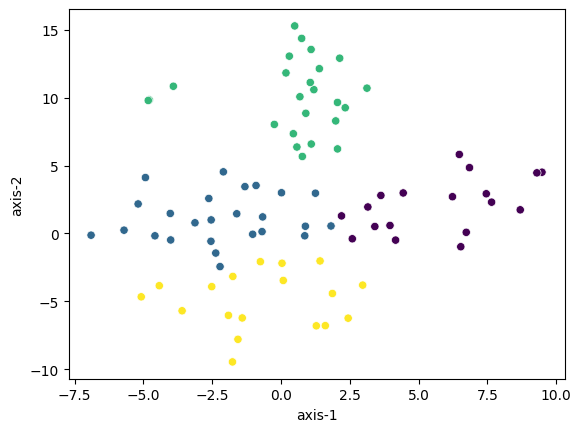

In [1893]:
# оптимальное количество кластеров=4, строим модель
gm_clustering = GaussianMixture(n_components=4, random_state=RANDOM_SEED, covariance_type='tied')
gm_clustering.fit(data_processed)
gm_prediction = gm_clustering.predict(data_processed)

#рисуем график
sns.scatterplot(x=data_processed['axis-1'], y=data_processed['axis-2'], c=gm_prediction)

In [1894]:
# рассчитываем и запоминаем метрики
add_list_metrics(data_processed, gm_prediction, gm_prediction,
                 len(set(gm_prediction)), 
                 np.bincount(gm_prediction), baseline.labels_)

Silhouette: 0.446
Calinski-Harabatz: 106.810
Davis-Bouldin: 0.766
Индекс Рэнда (сравнение с базовой моделью): 0.229
Размеры кластеров:  [18 25 24 18]


Итоговая таблица с моделями и метриками:

In [1895]:
# объединяем данные в однц таблицу
data_metrics = {'models': ['PCA+KMeans (baseline)',
                           'PCA+AgglomerativeClustering', 
                           'PCA+SpectralClustering', 
                           'PCA+GaussianMixture',  
                           'TSNE+KMeans', 
                           'TSNE+AgglomerativeClustering', 
                           'TSNE+ SpectralClustering', 
                           'TSNE+GaussianMixture'], 
                'count of clusters': clusters,
                'Размеры кластеров': clusters_sizes,
                'silhouette': silhouette,
                'calinski_harabasz': calinski_harabasz,
                'davies_bouldin': davies_bouldin,
                'index Rand': rand}
metrics_table = pd.DataFrame.from_dict(data_metrics, orient='index').T 
metrics_table

models count of clusters  \
0         PCA+KMeans (baseline)                10   
1   PCA+AgglomerativeClustering                 6   
2        PCA+SpectralClustering                 3   
3           PCA+GaussianMixture                 3   
4                   TSNE+KMeans                 4   
5  TSNE+AgglomerativeClustering                 7   
6      TSNE+ SpectralClustering                 4   
7          TSNE+GaussianMixture                 4   

                    Размеры кластеров silhouette calinski_harabasz  \
0  [13, 5, 8, 3, 11, 1, 12, 25, 1, 6]   0.349003         90.573843   
1                [49, 20, 7, 1, 5, 3]   0.420826         73.888192   
2                         [67, 3, 15]   0.515706         48.915335   
3                          [3, 2, 80]   0.629198         39.007798   
4                    [19, 23, 24, 19]   0.452415        107.796604   
5         [19, 16, 15, 10, 11, 11, 3]   0.412209          96.74266   
6                     [10, 51, 3, 21]   0.397344         58.422858   
7                    [18, 25, 24, 18]   0.446311        106.809797   

  davies_bouldin index Rand  
0       0.659709        1.0  
1       0.624227   0.376853  
2        0.67222   0.155584  
3       0.463569   0.043227  
4       0.754197   0.222635  
5       0.689243   0.305042  
6       0.622731   0.273902  
7       0.765807   0.228563

Лучший вариант по коэффициенту силуэта - PCA+GaussianMixture, наилучший коэффициент Калински-Харабаса у TSNE+KMeans и TSNE+GaussianMixture.
Если смотреть на коэффициент Дэвиса-Болдина, то лучшая модель PCA+GaussianMixture. 
Из этих моделей визуально лучшая кластеризация у TSNE+KMeans и TSNE+GaussianMixture. 

Возьмем TSNE+KMeans как лучшую модель, у неё коэффициент силуэта и коэффициент Дэвиса-Болдина лучше, чем у TSNE+GaussianMixture.

Значение "Индекс Рэнда" означает, что кластеризация имеет мало общего между собой и базовой моделью.

In [1896]:
# понижаем размерность
t_sne = TSNE(n_components=2, perplexity=17, random_state=RANDOM_SEED)
pipe = Pipeline(steps=[('scaler', scaler), ('t_sne', t_sne)])
data_processed = pipe.fit_transform(data)
data_processed = pd.DataFrame(data_processed, columns=['axis-1', 'axis-2'])

# сохраним модель кластеризации и датафрейм с метками кластеров
pipe = Pipeline([('scaler', scaler), 
                 ('TSNE', TSNE(n_components=2, perplexity=17, random_state=RANDOM_SEED)), 
                 ('KMeans', KMeans(n_clusters=4, random_state=RANDOM_SEED))])

# сохраним модель в виде pickle-файла
with open('data/model.pkl', 'wb') as pkl_file:
    pickle.dump(pipe, pkl_file)
    
# добавим метки кластеров в датасет
model_KMeans  = KMeans(n_clusters=4, random_state=RANDOM_SEED)
data['cluster'] = model_KMeans .fit_predict(data_processed) 

# упорядочим нумерацию кластеров по количеству регионов
data['cluster'] = data['cluster'].replace({3:0, 0:1, 2:2, 1:3})

# сохраним датафрейм с метками
data.to_csv('./data/data_labels.csv')

### 2.2. Интерпретация результатов кластеризации

Перейдём к интерпретации полученных кластеров.

In [1897]:
# Функция для визуализации профиля кластеров в виде полярной диаграммы
def plot_cluster_profile(grouped_data, n_clusters):
    """Функция для визуализации профиля кластеров в виде полярной диаграммы.

    Args:
        grouped_data (DataFrame): таблица, сгруппированная по номерам кластеров с агрегированными характеристиками объектов.
        n_clusters (int): количество кластеров
    """
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаём список признаков
    features = grouped_data.columns
    # Создаём пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаём полярную диаграмму и добавляем её на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название — номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
    )
    # Отображаем фигуру
    fig.show()
    fig.write_html("data/plot_cluster_profile.html")

In [1898]:
# группируем по кластерам
grouped_data = data.groupby('cluster').mean()
display(grouped_data)

child_mortality  disabled_total_by_age  poverty_percent_by_regions  \
cluster                                                                       
0              85.517544           8.520765e+05                   19.885088   
1              53.078947           6.541379e+05                   12.718860   
2             221.402778           3.350615e+06                   12.409722   
3              58.318841           1.148352e+06                   14.023913   

         welfare_expense_share  cash_real_income_wages  Number of children  \
cluster                                                                      
0                    21.350877            22204.421053           38.263158   
1                    17.608772            42759.508772           40.196053   
2                    20.988194            30670.305556           37.179167   
3                    21.163768            25572.449275           37.839130   

         Pensioners  Working-age population  feel uncomfortable while living  \
cluster                                                                        
0          6.847368               53.572368                        17.873684   
1          5.307895               51.863158                        16.705263   
2          5.931250               50.637500                        15.158333   
3          6.354348               55.805435                        11.330435   

         size of living space    population  gross_regional_product  \
cluster                                                               
0                   17.289474  8.958972e+05            2.734681e+05   
1                   16.184211  8.631664e+05            1.317784e+06   
2                   16.887500  3.667954e+06            5.099965e+05   
3                   18.121739  1.096431e+06            3.710388e+05   

         regional_production  retail_turnover_per_capita  newborn_monthly  \
cluster                                                                     
0               2.331762e+08               142230.736842     12275.049211   
1               1.878209e+09               208225.842105     10161.708860   
2               2.817749e+09               201694.854167     41476.848403   
3               6.016743e+08               166355.362319     11026.613261   

              crimes  morbidity_age_disease   drug+alco  
cluster                                                  
0         747.263158          295802.776316   69.065789  
1         896.231579          421931.431579  122.852632  
2        2874.541667          368063.616667   68.373958  
3         922.147826          365443.426087   83.284783

In [1899]:
# строим полярную диаграмму
plot_cluster_profile(grouped_data, 4)

Рассмотрим некоторые признаки в кластерах:

**0 кластер** - самый высокий процент людей, живущих за чертой бедности, самые низкие доходы населения, самый большой процент пенсионеров, больше всего людей, испытывающих стесненность при проживании, хотя размер жилой площади один из высоких, самый маленький ВРП, самый маленький оборот розничной торговли. Т.е. это бедные регионы.

**1 кластер** - больше всего инвалидов, самые высокие доходы населения, самый большой процент детей, самый большой ВРП, самый большой оборот розничной торговли, больше всего людей с заболеваниями и страдающих алкогольной или наркотической зависимостями. Видимо это бизнес-регионы.

**2 кластер** - самая высокая детская смертность, больше всего населения, самый большой объем отгруженных товаров собственного производства или работ/услуг, выполненных собственными силами, больше всего рожденных и больше всего преступлений. Похоже, что это производственные регионы - живет много людей, работает (объем отгруженных товаров собственного производства), рожает, совершает преступления. По доходам населения этот регион на втором месте.

**3 кластер** - самый большой процент трудоспособного населения, но в целом "средние" регионы. Назовем их среднестатистические регионы. 

In [1900]:
# посмотрим на первый кластер
mask = data['cluster'] == 0
cluster_0 = list(data[mask].index)
print("Регионы первого кластера")
print(data[mask].index.value_counts())

Регионы первого кластера
Чеченская Республика                   1
Карачаево-Черкесская Республика        1
Республика Алтай                       1
Калужская область                      1
Республика Адыгея (Адыгея)             1
Республика Хакасия                     1
Республика Тыва                        1
Республика Марий Эл                    1
Республика Бурятия                     1
Псковская область                      1
Республика Дагестан                    1
Республика Северная Осетия — Алания    1
Республика Калмыкия                    1
Чувашская Республика — Чувашия         1
Кабардино-Балкарская Республика        1
Забайкальский край                     1
Еврейская автономная область           1
Астраханская область                   1
Республика Крым                        1
Name: count, dtype: int64


В списке "Бедных регионов" оказалась Республика Тыва (мы видели на графике ранее, что она лидирует по проценту бедности).

In [1901]:
# посмотрим на второй кластер
mask = data['cluster'] == 1
cluster_1 = list(data[mask].index)
print("Регионы второго кластера")
print(data[mask].index.value_counts())

Регионы второго кластера
Ивановская область                          1
Ненецкий автономный округ                   1
Магаданская область                         1
г. Севастополь                              1
Сахалинская область                         1
Ямало-Ненецкий автономный округ             1
Камчатский край                             1
Республика Саха (Якутия)                    1
Ханты-Мансийский автономный округ — Югра    1
Тюменская область                           1
Республика Карелия                          1
Республика Коми                             1
Архангельская область                       1
Ярославская область                         1
Хабаровский край                            1
Приморский край                             1
Владимирская область                        1
Амурская область                            1
Чукотский автономный округ                  1
Name: count, dtype: int64


Видим с писке Ямало-Ненецкий автономный округ, Ненецкий автономный округ, Чукотский автономный округ - ранее на графике видели, что в этих регионах самые большие доходы населения

In [1902]:
# посмотрим на третий кластер
mask = data['cluster'] == 2
cluster_2 = list(data[mask].index)
print("Регионы третьего кластера")
print(data[mask].index.value_counts())

Регионы третьего кластера
Алтайский край                      1
Омская область                      1
Белгородская область                1
г. Санкт-Петербург                  1
Ленинградская область               1
г. Москва                           1
Московская область                  1
Республика Башкортостан             1
Красноярский край                   1
Свердловская область                1
Краснодарский край                  1
Нижегородская область               1
Новосибирская область               1
Пермский край                       1
Кемеровская область — Кузбасс       1
Челябинская область                 1
Самарская область                   1
Иркутская область                   1
Волгоградская область               1
Ростовская область                  1
Оренбургская область                1
Саратовская область                 1
Ставропольский край                 1
Республика Татарстан (Татарстан)    1
Name: count, dtype: int64


Список регионов, куда люди уезжают жить и работать по более высокой ставке.

In [1903]:
# посмотрим на четвертый кластер
mask = data['cluster'] == 3
cluster_3 = list(data[mask].index)
print("Регионы четвертого кластера")
print(data[mask].index.value_counts())

Регионы четвертого кластера
Республика Ингушетия       1
Пензенская область         1
Республика Мордовия        1
Воронежская область        1
Удмуртская Республика      1
Костромская область        1
Рязанская область          1
Липецкая область           1
Томская область            1
Тамбовская область         1
Тверская область           1
Курская область            1
Вологодская область        1
Мурманская область         1
Новгородская область       1
Тульская область           1
Смоленская область         1
Орловская область          1
Кировская область          1
Брянская область           1
Курганская область         1
Ульяновская область        1
Калининградская область    1
Name: count, dtype: int64


ОСтавшиеся "средние регионы".

Посмотрим на графики некоторых признаков по кластерам.

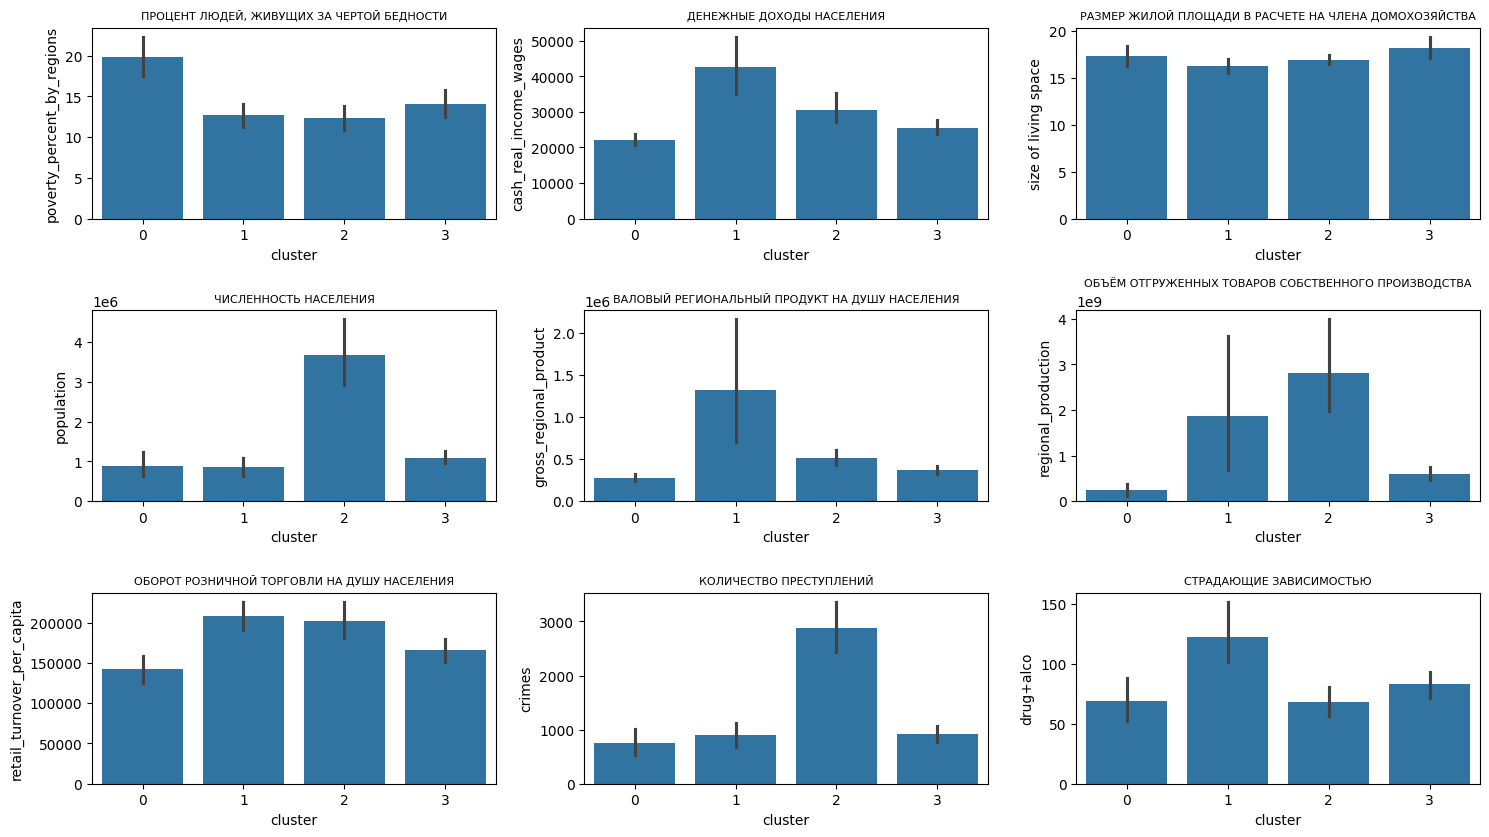

In [1904]:
# заголовки графиков
title=['процент людей, живущих за чертой бедности',
       'денежные доходы населения',
       'размер жилой площади в расчете на члена домохозяйства', 
       'численность населения',
       'валовый региональный продукт на душу населения', 
       'объём отгруженных товаров собственного производства',
       'оборот розничной торговли на душу населения', 
       'количество преступлений',
       'страдающие зависимостью']
# отберем колонки, по которым будем строить графики
cols = data[
    [
        'poverty_percent_by_regions',
        'cash_real_income_wages',
        'size of living space',
        'population',
        'gross_regional_product',
        'regional_production',
        'retail_turnover_per_capita',
        'crimes',
        'drug+alco'        
    ]
].columns.tolist()
plt.figure(figsize=(15, 25))
# для каждой колонки строится график
for i, variable in enumerate(cols):
    plt.subplot(9, 3, i + 1)
    sns.barplot(x=data['cluster'], y=data[variable])
    plt.tight_layout()
    plt.title(title[i].upper(), fontsize = 8)
plt.show()

Резюмируем еще раз:

**кластер 0** - высокий процент людей, живущих за чертой бедности, небольшая численность населения, самый маленький ВРП и объем отгруженных товаров собственного производства.

**кластер 1** - самые высокие доходы населения, ВРП и оборота розничной торговли, но также самое большое количество страдающих зависимостью.

**кластер 2** - самый большой объем отгруженных товаров собственного производства, больше всего преступлений.

**кластер 3** - средние значений по всем рассматриваемым признакам.

Также видим, что в самых бедных регионах не высокая преступность, хотя ранее пришли к выводу, что преступность влияет на бедность в регионе. ВРП сильно влияет на бедность в регионе, гипотеза сказала тоже самое.

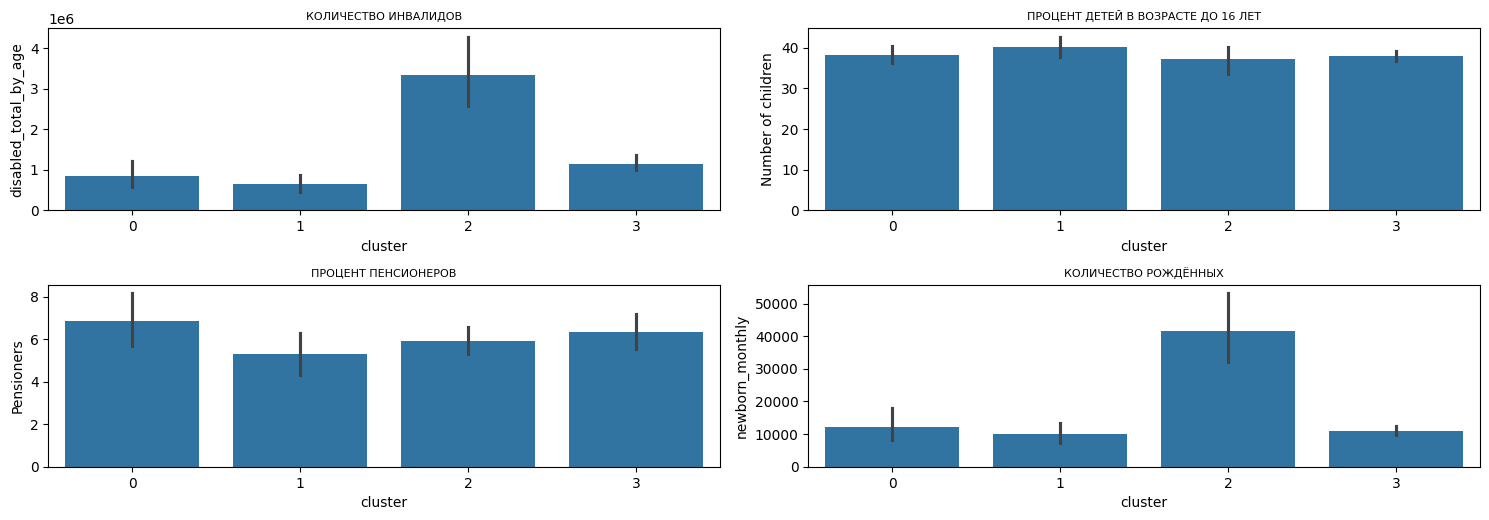

In [1905]:
# построим другие признаки по кластерам
# заголовки графиков
title=['количество инвалидов',
       'процент детей в возрасте до 16 лет',
       'процент пенсионеров',
       'количество рождённых'
    ]
# колонки, по которым построим графики
cols = data[
    ['disabled_total_by_age',
     'Number of children',
     'Pensioners',
     'newborn_monthly'
    ]
].columns.tolist()
plt.figure(figsize=(15, 10))
# строим сами графики по выбранным колонкам
for i, variable in enumerate(cols):
    plt.subplot(4, 2, i + 1)
    sns.barplot(x=data['cluster'], y=data[variable])
    plt.tight_layout()
    plt.title(title[i].upper(), fontsize = 8)
plt.show()

Инвалидов в кластерах 2 и 3, больше чем в кластере 0 - "Бедные регионы", процент детей примерно одинаковый, процент пенсионеров выше в "Бедных регионах", но различия не такие большие, рожденных больше всего в кластере 2.
Число детей, пенсионеров и других социально уязвимых групп на уровень бедности в регионе не влияет на бедность региона, гипотеза не подтвердилась после проверки кластеров.

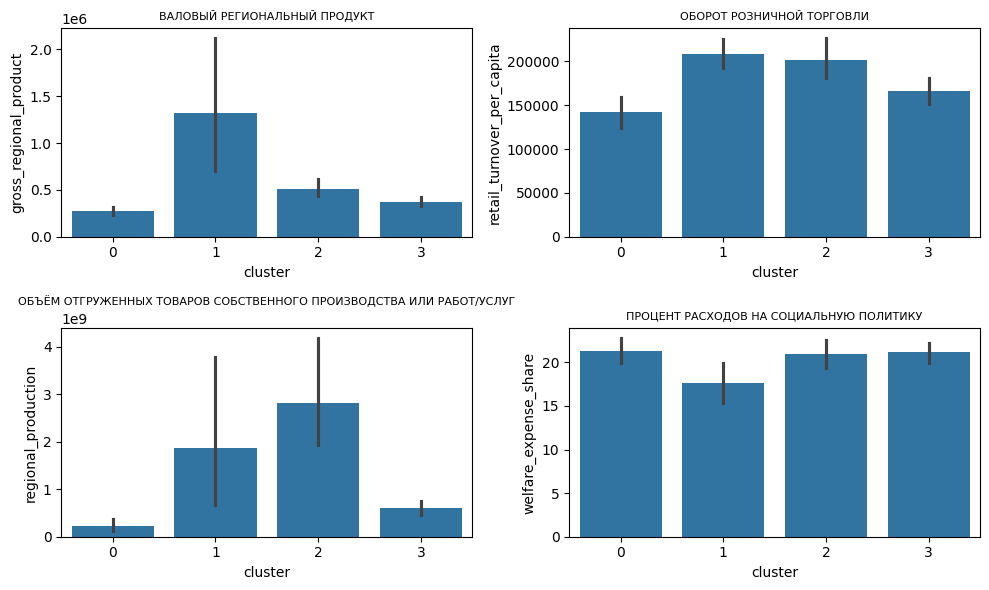

In [1906]:
# построим столбчатые диаграмы признаков 
# валовый региональный продукт,
# объём отгруженных товаров и оборот розничной торговли
title=['валовый региональный продукт',
       'оборот розничной торговли',
       'объём отгруженных товаров собственного производства или работ/услуг',
       'процент расходов на социальную политику'
    ]
# выбираем колонки для графиков
cols = data[
    ['gross_regional_product',
     'retail_turnover_per_capita',
     'regional_production',
     'welfare_expense_share'
    ]
].columns.tolist()
plt.figure(figsize=(10, 6))
# строим графики
for i, variable in enumerate(cols):
    plt.subplot(2, 2, i + 1)
    sns.barplot(x=data['cluster'], y=data[variable])
    plt.tight_layout()
    plt.title(title[i].upper(), fontsize = 8)
plt.show()

Самый маленький ВРП, объём отгруженных товаров собственного производства или работ/услуг, выполненных собственными силами и оборот торговли в "бедных" регионах, тогда как самые высокие значения в бизнес-регионах, а для объёма отгруженных товаров собственного производства или работ/услуг, выполненных собственными силами - во втором кластере. Признаки влияют на уровень бедности.
А вот процент расходов на рекламу примерно одинаковый, т.е. не влияет на бедность региона, хотя гипотеза говорила об обратном.

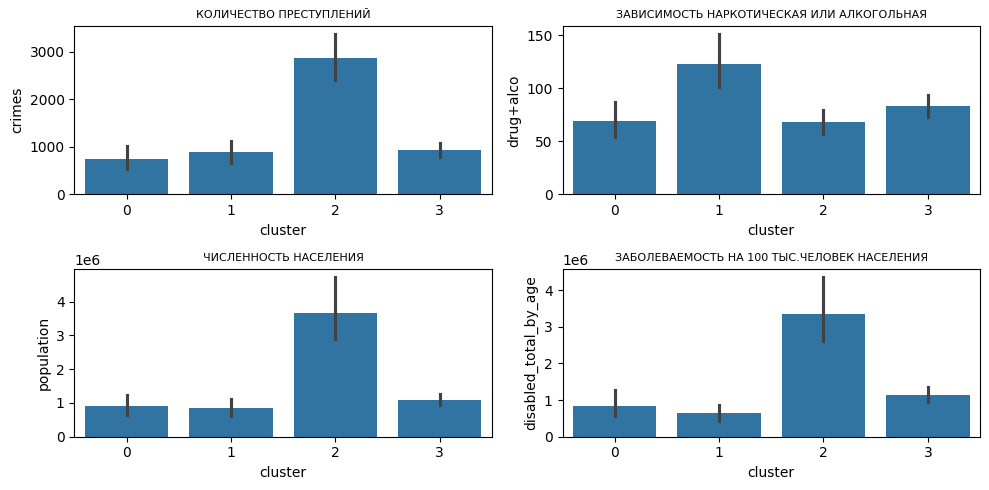

In [1907]:
# построим столбчатые диаграмы признаков 
title=['количество преступлений',
       'зависимость наркотическая или алкогольная',
       'численность населения',
       'заболеваемость на 100 тыс.человек населения'
    ]

cols = data[
    ['crimes',
     'drug+alco',
     'population',
     'disabled_total_by_age'
    ]
].columns.tolist()
plt.figure(figsize=(10, 5))

for i, variable in enumerate(cols):
    plt.subplot(2, 2, i + 1)
    sns.barplot(x=data['cluster'], y=data[variable])
    plt.tight_layout()
    plt.title(title[i].upper(), fontsize = 8)
plt.show()

Заболеваемость и количество преступлений зависят от численности населения, наркотическая или алкогольная зависимость не влияют на бедность региона.

## Часть 3. Выводы

Получены кластеры регионов:

- Бедные регионы
- Бизнес-регионы
- Производственные регионы
- Среднестатистические регионы

На уровень бедности влияет валовый региональный продукт, объём отгруженных товаров собственного производства или работ/услуг, выполненных собственными силами и оборот розничной торговли. Нужно запускать производство в этих регионах и увеличивать рабочие места с конкуретноспособной зарплатой.

Был создан телеграмм-бот, который по имени региона выдает информацию о нем, а также по выбранной кнопке - получает список регионов, относящихся к выбранному кластеру.
@information_about_regions_Bot

Файл с кодом для работы с ботом - bot.py

Примеры работы бота в папке data.